# Setup and importing packages

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from collections import Counter
import pickle
from datetime import datetime, timedelta
from scipy import io
from glob import glob
import os
import pickle

from osgeo import gdal


import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as mc
import cmocean
import cmocean.cm as cmo

import requests
import rasterio
import netCDF4 as nc
import cartopy.feature as cfeature

import pygrib
import cdsapi






# import colour cycles
from cycler import cycler
from palettable.colorbrewer.qualitative import Set3_12
from palettable.colorbrewer.qualitative import Set1_9
from palettable.cmocean.sequential import Matter_14
from palettable.cmocean.sequential import Thermal_14
from palettable.cmocean.sequential import Ice_6
from palettable.cmocean.diverging import Curl_14
from palettable.cmocean.sequential import Haline_5
from palettable.scientific.diverging import Roma_14
from palettable.cmocean.diverging import Curl_6
from palettable.matplotlib import Inferno_6
from palettable.matplotlib import Plasma_5
from palettable.colorbrewer.qualitative import Set1_5


# format the colour cycles into cyclers
line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))
marker_cycler = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["none", "none", "none", "none", "none", "none", "none"]) +
                 cycler(marker=[".", ".", ".", ".", ".", ".", "."]))
buoy_cycler = (cycler(color=Set1_9.mpl_colors)+cycler(marker=np.repeat(["."],9)))
scatter_cycler = (cycler(color=(reversed(Plasma_5.mpl_colors)))+cycler(marker=np.repeat(["."],5))+cycler(linestyle=np.repeat(["none"],5 )))
ice_cycler = (cycler(color=(reversed(Plasma_5.mpl_colors)))+cycler(marker=np.repeat(["."],5))+cycler(linestyle=np.repeat(["none"],5)))


# matplotlib's standard cycler
bcyc_list = [ '#E8ECFB', '#D9CCE3', '#D1BBD7', '#CAACCB', '#BA8DB4', '#AE76A3', '#AA6F9E', '#994F88', '#882E72', '#1965B0', '#437DBF', '#5289C7', '#6195CF', '#7BAFDE', '#4EB265', '#90C987', '#CAE0AB', '#F7F056', '#F7CB45', '#F6C141', '#F4A736', '#F1932D', '#EE8026', '#E8601C', '#E65518', '#DC050C', '#A5170E', '#72190E', '#42150A']
binds14 = [3,5,7,9,10,11,13,14,15,16,17,18,23,26]
binds14 = [ x - 1 for x in binds14 ]

standard_cycler = cycler("color", ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"])
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc("axes", prop_cycle=line_cycler)
plt.rc("text", usetex=False)
plt.rc("font", family="serif", size=15.)
plt.rc("savefig", dpi=250)
plt.rc("legend", loc="best", fontsize="medium", fancybox=True, framealpha=0.4)
plt.rc("lines", linewidth=2.5, markersize=5, markeredgewidth=2.5)

## Some constants for all of the code
pr = "/projects/sciences/maths_stats/seaice_ww3/"
directory = pr
si_dir = "SeaIce/"
data_dir = "ww3_data/Processed/"
ddir = directory + data_dir

The following bits of code are borrowed from this github:
https://github.com/mikedorfman/NSIDC-MIZ-Comparison


In [3]:
def datetime_to_cdr_fname(date):
    """
    Generate a CDR FTP path given the datetime hemisphere
    :param date: datetime - desired datetime for file
    :param hemisphere: string - 'south' or 'north' - hemisphere to generate the filename for
    :return:
    """
    #check_hemisphere(hemisphere)
    # Before this date, files had a different naming convention and live in a different spot
    #cutoff = datetime.datetime(2019, 1, 1)
    #hemisphere_letter = hemisphere[0]  # "n" for north, "s" for south
    archive_url = f"https://noaadata.apps.nsidc.org/NOAA/G02135/south/daily/geotiff/{date:%Y}/{date:%m}_{date:%b}/"
    r_file = f"S_{date:%Y%m%d}_concentration_v3.0.tif"  
    save_file = f"../SI_Concentration/seaice_conc_daily_icdr_sh_f18_{date:%Y%m%d}_v03.tif"
    return archive_url, r_file, save_file

def get_cdr_data(url,rf, save_file):
    if os.path.exists(save_file):
        print("...file already exists...")
        return
    else:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(save_file, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
    return

The following bits of code are from: https://github.com/polarwatch/code-gallery

In [4]:

# There are many ways to get data.  We will create a function that points to 
# NOAA PolarWatch ERDDAP Server gridded dataset page to get data with its unique ID

def point_to_dataset(dataset_id, base_url='https://polarwatch.noaa.gov/erddap/griddap'):
    base_url = base_url.rstrip('/')
    full_url = '/'.join([base_url, dataset_id])
    return nc.Dataset(full_url)
 

# 'nsidcG02202v4nhmday' is the unique ID of our interested data 
# from PolarWatch ERDDAP data server
p_da = point_to_dataset('nsidcG02202v4sh1day')
c    = cdsapi.Client()

def check_datetime_era5(dtim):
    fname = directory + si_dir + dtim.strftime("%Y%m%d_%H") + ".grib"
    if not os.path.exists(fname):
        c.retrieve('reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'format': 'grib',
            'variable': 'sea_ice_cover',
            'year': str(dtim.year),
            'month': str(dtim.month),
            'day': str(dtim.day),
            'time': dtim.strftime('%H:00'),
            'area': [-50, -180, -90, 180,],
        },   fname)
    return fname

# function to interpolate the buoy data to the model time
def buoy_interp(bs,mt,hw = np.timedelta64(31,'m'),th = 0.5):
    eft = np.array(bs)
    sc  = np.array(bs['seaice'])
    bt  = np.array(bs['time'])
    mt = np.array(mt)
        
    number_of_intervals = hw/ np.timedelta64(15,'m')
    #print(number_of_intervals)
    nint = int(np.ceil(number_of_intervals))*2 -1
    #print(nint)
    bout = np.zeros((np.shape(eft)[0],len(mt)))
    sc_out = np.zeros(len(mt))
    count = 0
    for i,m in enumerate(mt):
        t1 = m + hw
        t2 = m - hw
        inds = np.where(np.logical_and(bt>=t2, bt<=t1))
        #print(inds)
        chk = len(inds[0])/nint
        if chk > th:
            count+=1
            sc_out[i] = np.mean(sc[inds])
            bout[:,i] = np.mean(eft[:,inds[0]],1)
   
            
    #print(count)    
    bdf = xr.DataArray(bout, coords={'frequency':bs['frequency'], 'time':mt}, dims=['frequency', 'time'])  
    buoy_data = bdf.assign_coords( seaice=('time', sc_out))
    return buoy_data  

# loads the model points for a specific model
def read_models(fname):
    ds = xr.open_mfdataset(fname)
    return ds

# prints variable names
p_da.variables.keys()
orig_d = datetime(1978,10,25)
dtim = datetime(2022,12,31)
p_da.variables.keys()

dict_keys(['time', 'ygrid', 'xgrid', 'cdr_seaice_conc', 'nsidc_bt_seaice_conc', 'nsidc_nt_seaice_conc', 'qa_of_cdr_seaice_conc', 'spatial_interpolation_flag', 'stdev_of_cdr_seaice_conc', 'temporal_interpolation_flag'])

## Importing Data

In [5]:
# sorts the buoy data into a xarray
def sort_buoy_data(data,time):
    d_o = {}
    freq = np.array(data['freq'][:,0])
    df = [freq[i+1]-freq[i] for i in range(len(freq)-1)]; df.append(df[-1])
    for i in range(len(data['lat'][0,:])):
        lats = np.array(data['lat'][:,i])
        lons = np.array(data['lon'][:,i])
        spec = np.array(data['psd_filt'][0,i])
        m0 = np.array([np.nansum(spec[:,t]*df) for t in range(len(data['time']))])
        m1 = np.array([np.nansum(spec[:,t]*freq*df) for t in range(len(data['time']))])
        hs = 4*np.sqrt(m0)
        tm = m0/m1
        l_inds = np.where(~np.isnan(lats))
        l_inds = l_inds[0]
        buoy_data = xr.DataArray(spec[:,l_inds], coords={'frequency':freq, 'time':time[l_inds]}, dims=['frequency', 'time'])
        d_o[i] = [time,lats,lons,buoy_data,l_inds,m0,m1,hs,tm]
    return d_o

data_out = io.loadmat(ddir+"outbound_psd_data.mat")

time_raw = np.array(data_out['time_days_dec'][:,0])
EPOCH = datetime(2017, 4, 1)  # midnight 1st Apr 2017

def from_ordinal(ordinal, _epoch=EPOCH):
    return _epoch + timedelta(days=ordinal)

time_dto = []
for t in range(len(time_raw)):
    time_dto.append(from_ordinal(time_raw[t]))
print("start time for outbound:",time_dto[0]," and end time:", time_dto[-1])

data_in = io.loadmat(ddir+'inbound_psd_data.mat')

time_raw = np.array(data_in['time'][:,0])
EPOCH = datetime(2017, 4, 1)  # midnight 1st Apr 2017

time_dti = []
for t in range(len(time_raw)):
    time_dti.append(from_ordinal(time_raw[t]))
print("start time for inbound:",time_dti[0]," and end time: ", time_dti[-1])

start time for outbound: 2017-06-02 03:00:00  and end time: 2017-07-26 03:45:00
start time for inbound: 2017-04-22 04:00:00  and end time:  2017-07-08 04:00:00


In [6]:
# save the buoy data
with open('d_sorted_sc.pkl', 'rb') as f:
    d_sorted = pickle.load(f)

freq = np.array(d_sorted[1][3]['frequency'])

# Bouy location plots

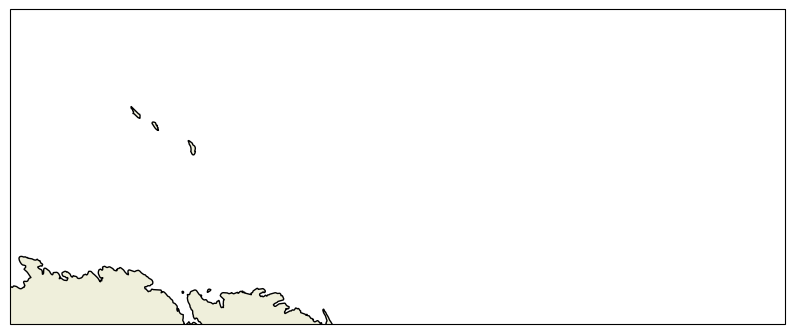

In [7]:
# Set data projection using EPSG Code 
data_crs = ccrs.epsg('3412')
crs_epsg = ccrs.SouthPolarStereo(central_longitude=180)

# set the basemap 
fig = plt.figure(figsize=[10, 10])
ax = plt.axes(projection = crs_epsg)
#ax.set_extent([-3850000.0, 3750000.0, -5350000, 5850000.0],ccrs.NorthPolarStereo(central_longitude=-45))
ax.set_extent([157.5,195,-70.4,-64.5], ccrs.PlateCarree())
#ax.set_extent([0,195,-75,-61], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.coastlines()

In [8]:
def sort_buoy_date(d_to_sort,mdat):
    d_o = {}
    dn = -1
    for d in d_to_sort:
        tim = d_to_sort[d][0]
        if tim[0] < mdat:
            dn += 1
            indices = np.where(tim < mdat)[0]
            vals = np.where(~np.isnan(d_to_sort[d][1]))[0]
            endc = True
            if vals[-1] > indices[-1]:
                endc = False
            indices = indices[::15]
            tim = tim[indices]
            lat = d_to_sort[d][1][indices]
            lon = d_to_sort[d][2][indices]
            d_o[dn]=[tim,lat,lon,endc]
    return d_o

def plot_buoy_date(mdat,out_file):
    plt.clf(); fig = plt.figure(figsize=(20,13)); ax = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=180))
    #plt.rc("axes", prop_cycle=buoy_cycler)
    # get the date for the sea-ice concentration
    delta = (mdat-orig_d).days
    
    cs = ax.pcolormesh(p_da['xgrid'], p_da['ygrid'], p_da['cdr_seaice_conc'][delta][:], 
                   cmap=plt.cm.Blues_r,  transform= data_crs)
    
    
    # plot all of the data in grey 
    # for i in range(len(d_sorted)):
    #     lons = d_sorted[i][2]
    #     lats = d_sorted[i][1]
    #     cax1 = ax.plot(lons, lats, marker='none',color = 'k', linestyle='dashed',linewidth=0.5,label='_nolegend_' ,transform=ccrs.PlateCarree(),alpha=0.7)
    # make a local version of d_sorted that includes only the deployed buoys
    d_local = sort_buoy_date(d_sorted,mdat)
    ax.set_prop_cycle(buoy_cycler)
    for i in range(len(d_local)):
        lons = d_local[i][2]
        lats = d_local[i][1]
        nonnan = np.where(~np.isnan(lons))
        nonnan = nonnan[0]
        p = ax.plot(lons, lats, linewidth = 1, marker='none',linestyle='solid',label = "_buoy "+str(i+1) ,transform=ccrs.PlateCarree())
        ax.plot(lons[nonnan[-1]], lats[nonnan[-1]], color = p[0].get_color(), marker='o',markersize=10,mec = 'k', markeredgewidth=0.4, linestyle='none',label = "buoy "+str(i+1) ,transform=ccrs.PlateCarree())
    
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False; gl.ylabels_right = False; gl.xlabel_style={'size':15}; gl.ylabel_style={'size':15}; 
    ax.tick_params(axis='y', labelsize=15)
    ax.add_feature(cfeature.LAND)
    ax.coastlines('50m'); #ticks=np.arange(0.,20.000001,0.5)); 
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=7, fancybox=True, shadow=True)
    ax.set_extent([157.5,195,-70.2,-64.4], ccrs.PlateCarree())
    axins = inset_axes(ax, width="18%", height="40%", loc = "lower right", axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=ccrs.SouthPolarStereo(central_longitude=180)))
    axins.set_position([0.05, 0.05, 0.3, 0.4])
    axins.set_extent([0, 360, -90, -64], ccrs.PlateCarree())
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    axins.add_patch(plt.Rectangle((xl[0], yl[0]), xl[1]-xl[0], yl[1]-yl[0], ls="--", ec="k", fc="none"))#,
                           #transform=ccrs.PlateCarree()))
    cs2 = axins.pcolormesh(p_da['xgrid'], p_da['ygrid'], p_da['cdr_seaice_conc'][delta][:], 
                   cmap=plt.cm.Blues_r,  transform= data_crs) 
    axins.add_feature(cfeature.LAND)
    axins.add_feature(cfeature.COASTLINE)
    axins.add_patch(plt.Rectangle((xl[0], yl[0]), xl[1]-xl[0], yl[1]-yl[0], ls="--",linewidth=3, ec="k", fc="none"))#,
                           #transform=ccrs.PlateCarree()))


    fig.colorbar(cs, ax=ax, location='bottom', shrink =0.5, label="sea-ice concentration")
    plt.savefig(out_file, bbox_inches='tight', dpi=300 )
    plt.show()
#   
def plot_buoy_era5(mdat,out_file):
    plt.clf(); fig = plt.figure(figsize=(20,13)); ax = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=180))
    
        
    grib = check_datetime_era5(mdat) # Set the file name of your input GRIB file
    grbs = pygrib.open(grib)

    grb = grbs.select()[0]
    data = grb.values

    # need to shift data grid longitudes from  (-180..180) to  (0..360)
    lons = np.linspace(float(grb['longitudeOfFirstGridPointInDegrees']), \
    float(grb['longitudeOfLastGridPointInDegrees']), int(grb['Ni']) )
    lats = np.linspace(float(grb['latitudeOfFirstGridPointInDegrees']), \
    float(grb['latitudeOfLastGridPointInDegrees']), int(grb['Nj']) )
    #lons += 180.
    grid_lon, grid_lat = np.meshgrid(lons, lats) #regularly spaced 2D grid
    
    cs = ax.pcolormesh(grid_lon, grid_lat, data, 
                   cmap=cmo.ice,  transform= ccrs.PlateCarree())
    
    
    
    # plot all of the data in grey 
    # for i in range(len(d_sorted)):
    #     lons = d_sorted[i][2]
    #     lats = d_sorted[i][1]
    #     cax1 = ax.plot(lons, lats, marker='none',color = 'k', linestyle='dashed',linewidth=0.5,label='_nolegend_' ,transform=ccrs.PlateCarree(),alpha=0.7)
    # make a local version of d_sorted that includes only the deployed buoys
    d_local = sort_buoy_date(d_sorted,mdat)
    ax.set_prop_cycle(marker_cycler)
    for i in range(len(d_local)):
        lons = d_local[i][2]
        lats = d_local[i][1]
        nonnan = np.where(~np.isnan(lons))
        nonnan = nonnan[0]
        p = ax.plot(lons, lats, linewidth = 1, marker='none',linestyle='solid',label = "_buoy "+str(i+1) ,transform=ccrs.PlateCarree())
        ax.plot(lons[nonnan[-1]], lats[nonnan[-1]], color = p[0].get_color(), marker='o',markersize=10,mec = 'k', markeredgewidth=0.4, linestyle='none',label = "buoy "+str(i+1) ,transform=ccrs.PlateCarree())
    
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False; gl.ylabels_right = False; gl.xlabel_style={'size':15}; gl.ylabel_style={'size':15}; 
    ax.tick_params(axis='y', labelsize=15)
    ax.add_feature(cfeature.LAND)
    ax.coastlines('50m'); #ticks=np.arange(0.,20.000001,0.5)); 
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=7, fancybox=True, shadow=True)
    ax.set_extent([157.5,195,-70.2,-64.4], ccrs.PlateCarree())
    axins = inset_axes(ax, width="18%", height="40%", loc = "lower right", axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=ccrs.SouthPolarStereo(central_longitude=180)))
    axins.set_position([0.05, 0.05, 0.3, 0.4])
    axins.set_extent([0, 360, -90, -64], ccrs.PlateCarree())
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    axins.add_patch(plt.Rectangle((xl[0], yl[0]), xl[1]-xl[0], yl[1]-yl[0], ls="--", ec="k", fc="none"))#,
                           #transform=ccrs.PlateCarree()))
    cs2 = axins.pcolormesh(grid_lon, grid_lat, data, 
                   cmap=plt.cm.Blues_r,  transform= ccrs.PlateCarree()) 
    axins.add_feature(cfeature.LAND)
    axins.add_feature(cfeature.COASTLINE)
    axins.add_patch(plt.Rectangle((xl[0], yl[0]), xl[1]-xl[0], yl[1]-yl[0], ls="--",linewidth=3, ec="k", fc="none"))#,
                           #transform=ccrs.PlateCarree()))


    fig.colorbar(cs, ax=ax, location='bottom', shrink =0.5, label="sea-ice concentration")
    plt.savefig(out_file, bbox_inches='tight', dpi=300 )
    plt.show()
    

# Pull in raster data from one model run

In [9]:
pr = "/mnt/auto-hcs/surv-shared/Common/Antarctica_Group/Martin/WW3/Data"
pr = "/home/forma623/tempData/griddata"
ds_ww3 = xr.open_mfdataset(pr + '/IC2_20170*01T00_grid.nc')
ds_ww3

tm = np.array(ds_ww3['time'])
differences = np.abs(tm - np.datetime64(datetime(2017,5,15)))
ci = np.argmin(differences)
print(ci)
hgr = np.array(ds_ww3.hs)
print(np.shape(hgr))
hgr = hgr[ci,:,:]
print(np.shape(hgr))

gr_la = np.array(ds_ww3['latitude'])
gr_lo = np.array(ds_ww3['longitude'])

353
(980, 126, 367)
(126, 367)


In [17]:
from matplotlib.legend_handler import HandlerBase
from matplotlib.lines import Line2D


class AnyObjectHandler:
    def __init__(self, color, include_x=False):
        self.color = color  # Store the specific color from the array
        self.include_x = include_x

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        
        # Set up the scaling factors for positioning
        symbol_spacing = 0.25 * width


        
        # Draw triangle at the start
        triangle = Line2D([x0 + symbol_spacing / 2], [y0 + height / 2],
                          color=self.color, marker='^',mec = 'k',mew = 0.6, markersize=fontsize - 5,
                          linestyle='none')
        
        
        # Draw short line after the triangle
        line = Line2D([x0 + symbol_spacing, x0 + symbol_spacing + 0.3 * width], 
                      [y0 + height / 2, y0 + height / 2],
                      color=self.color, linewidth=2)
        
        
        
        # Draw circle with an "x" on top
        circle = Line2D([x0 + symbol_spacing + 0.5 * width], [y0 + height / 2],
                        color=self.color, marker='o',mec = 'k',mew = 0.6, markersize=fontsize - 5,
                        linestyle='none')
        
        x_marker = Line2D([x0 + symbol_spacing + 0.5 * width], [y0 + height / 2],
                          color='k', marker='x', mew = 0.8, markersize=fontsize - 8,
                          linestyle='none')
        
        handlebox.add_artist(line)
        handlebox.add_artist(triangle)
        handlebox.add_artist(circle)
        if self.include_x:
            handlebox.add_artist(x_marker)

        return handlebox


def plot_buoy_hs_era5(mdat,ds_ww3,out_file):
    plt.clf(); fig = plt.figure(figsize=(20,13)); ax = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=167.5))
    #167.5
    colrs =  [bcyc_list[i] for i in binds14 ]
    ax.set_prop_cycle("color", colrs)

    extent = [160, 194, -70, -64]
    gr_la = np.array(ds_ww3['latitude'])
    gr_lo = np.array(ds_ww3['longitude'])
    
    tm = np.array(ds_ww3['time'])
    differences = np.abs(tm - np.datetime64(mdat))
    ci = np.argmin(differences)
    hgr = np.array(ds_ww3.hs)
    hgr = hgr[ci,:,:]
    
    grib = check_datetime_era5(mdat) # Set the file name of your input GRIB file
    grbs = pygrib.open(grib)

    grb = grbs.select()[0]
    data = grb.values

    # need to shift data grid longitudes from  (-180..180) to  (0..360)
    lons = np.linspace(float(grb['longitudeOfFirstGridPointInDegrees']), \
    float(grb['longitudeOfLastGridPointInDegrees']), int(grb['Ni']) )
    lats = np.linspace(float(grb['latitudeOfFirstGridPointInDegrees']), \
    float(grb['latitudeOfLastGridPointInDegrees']), int(grb['Nj']) )
    #lons += 180.
    grid_lon, grid_lat = np.meshgrid(lons, lats) #regularly spaced 2D grid
    mask_lon = (grid_lon >= extent[0]) & (grid_lon <= extent[1])
    mask_lat = (grid_lat >= extent[2]) & (grid_lat <= extent[3])
    mask = mask_lon & mask_lat
    mask_data = np.ma.masked_where(~mask, data)
    unmask_data = np.ma.masked_where(mask,data)
    cs = ax.pcolormesh(grid_lon, grid_lat, data, alpha = 1,linewidth=0, cmap=cmo.ice,  shading = 'gouraud', rasterized = True, transform= ccrs.PlateCarree(),snap=True)
    cs3 = ax.pcolormesh(gr_lo, gr_la, hgr, cmap=cmo.thermal, alpha = 1, shading = 'gouraud',rasterized = True, linewidth=0, transform= ccrs.PlateCarree())
    cs3.set_edgecolor('face')
    contour = ax.contour(grid_lon, grid_lat, unmask_data, levels=4, colors='white', transform= ccrs.PlateCarree(), linewidths=0.5,  linestyles='--')
    contour2 = ax.contour(grid_lon, grid_lat, mask_data, levels=4, colors='white', transform= ccrs.PlateCarree(), linewidths=0.5,  linestyles='--')
    
   

    
    
    # plot all of the data in grey 
    # for i in range(len(d_sorted)):
    #     lons = d_sorted[i][2]
    #     lats = d_sorted[i][1]
    #     cax1 = ax.plot(lons, lats, marker='none',color = 'k', linestyle='dashed',linewidth=0.5,label='_nolegend_' ,transform=ccrs.PlateCarree(),alpha=0.7)
    # make a local version of d_sorted that includes only the deployed buoys
    d_local = sort_buoy_date(d_sorted,mdat)
    #ax.set_prop_cycle(marker_cycler)
    pcols = []
    for i in range(len(d_local)):
        lons = d_local[i][2]
        lats = d_local[i][1]
        nonnan = np.where(~np.isnan(lons))
        nonnan = nonnan[0]
        p = ax.plot(lons, lats, linewidth = 3, marker='none',linestyle='solid',label = "_buoy "+str(i+1) ,transform=ccrs.PlateCarree())
        pcols.append(p)

    qcols = []
    handlers = {}
    for i in range(len(d_local)):
        lons = d_local[i][2]
        lats = d_local[i][1]
        nonnan = np.where(~np.isnan(lons))
        nonnan = nonnan[0]
        if d_local[i][3]:
            q = ax.plot(lons[nonnan[-1]], lats[nonnan[-1]],  color = pcols[i][0].get_color(),  marker='o',markersize=11, markerfacecoloralt='k', mec = 'k', markeredgewidth=0.5, linestyle='none',label = "buoy "+str(i+1) ,transform=ccrs.PlateCarree())
            ax.plot(lons[nonnan[-1]], lats[nonnan[-1]], color='k', marker='x', markersize=9,markeredgewidth=0.5,  linestyle='none', transform=ccrs.PlateCarree()) 
            qcols.append(q)
            handlers[q[0]] = AnyObjectHandler(color= pcols[i][0].get_color(), include_x=True)
        else:
            q = ax.plot(lons[nonnan[-1]], lats[nonnan[-1]],  color = pcols[i][0].get_color(), marker='o',markersize=11,mec = 'k', markeredgewidth=0.5, linestyle='none',label = "buoy "+str(i+1) ,transform=ccrs.PlateCarree())
            qcols.append(q)
            handlers[q[0]] = AnyObjectHandler(color= pcols[i][0].get_color(), include_x=False)
        ax.plot(lons[nonnan[0]], lats[nonnan[0]], color = q[0].get_color(), marker='^',markersize=11, mec = 'k', markeredgewidth=0.5, linestyle='none',label = "_buoy "+str(i+1) ,transform=ccrs.PlateCarree())
    
    
    #gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,x_inline=False, y_inline=False,linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
    #gl.xlabels_top = False; gl.ylabels_right = False; gl.ylabels_left = True; gl.xlabel_style={'size':15}; gl.ylabel_style={'size':15}; 
    ax.tick_params(axis='y', labelsize=15)
    ax.add_feature(cfeature.LAND)
    ax.coastlines('50m'); #ticks=np.arange(0.,20.000001,0.5)); 
    # Custom symbols for the legend
    #handlers = { AnyObjectHandler(col) for col in colrs }
    #handlers = {i: AnyObjectHandler(color=colrs[i]) for i in range(len(colrs))}
    #handlers = {p[0]: AnyObjectHandler(color=colrs[i]) for i, p in enumerate(qcols)}
    print(handlers)
    ax.legend(handler_map=handlers, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=7, fancybox=True, shadow=True)

    
# Use ax.legend with custom handlers for the buoys
    ax.legend(handler_map=handlers,
          loc='upper center', 
          bbox_to_anchor=(0.5, 1.05), 
          ncol=7, 
          fancybox=True, 
          shadow=True)
    #ax.legend(l_inputs, l_string, handler_map={tuple: AnyObjectHandler()},prop = { "size": 6 }, handletextpad = -0.3,
    #       bbox_to_anchor=(0.5, 1.05), ncol=7, fancybox=True, shadow=True)
    ax.set_extent([160,194,-70,-64], ccrs.PlateCarree())
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    print(xl)
    print(yl)
    xc = (xl[0]+xl[1])/2
    yc = (yl[0]+yl[1])/2
    manual_locations = [(xc, yc), (xc, yc), (xc, yc),(xc, yc)]
    ax.clabel(contour2, inline=True, fontsize=10)
    ax.clabel(contour, inline=True, fontsize=10)

    
    axins = inset_axes(ax, width="32%", height="40%", loc = "lower right", bbox_to_anchor=(0.05,0,1,1), bbox_transform=ax.transAxes, axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=ccrs.SouthPolarStereo(central_longitude=167.5)))
    axins.set_extent([0, 360, -90, -59], ccrs.PlateCarree() )
 
 
    #axins.add_patch(plt.Rectangle((xl[0], yl[0]), xl[1]-xl[0], yl[1]-yl[0], ls="--", ec="k", fc="none",linewidth=1))#,
                           #transform=ccrs.PlateCarree()))
    cs2 = axins.pcolormesh(grid_lon, grid_lat, data, cmap=plt.cm.Blues_r,  transform= ccrs.PlateCarree()) 
    cs3 = axins.pcolormesh(gr_lo, gr_la, hgr, cmap=cmo.thermal, alpha = 1, shading = 'gouraud',rasterized = True, linewidth=0, transform= ccrs.PlateCarree())
    contour = axins.contour(grid_lon, grid_lat, data, levels=4, colors='white', transform= ccrs.PlateCarree(), linewidths=0.5,  linestyles='--')
    axins.plot([xl[0],xl[1],xl[1],xl[0],xl[0]],[yl[0],yl[0],yl[1],yl[1],yl[0]], ls="--",linewidth=2, color="k")
    axins.add_feature(cfeature.LAND)
    axins.add_feature(cfeature.COASTLINE)
    #axins.plot([160,194,194,160,160],[-72,-72,-64,-64,-72], ls="--",linewidth=2, color="k")#,transform=ccrs.PlateCarree())

    axins.patch.set_edgecolor('black')  
    axins.patch.set_linewidth(2)  
    #axins.add_patch(plt.Rectangle((xl[0], yl[0]), xl[1]-xl[0], yl[1]-yl[0], ls="--",linewidth=2, ec="k", fc="none"))#,
                           #transform=ccrs.PlateCarree()))
    # pos = axins.get_position()
    # print(pos)
    # axins.set_position([2, 0.05, 0.5, 0.5])
    # pos = axins.get_position()
    # print(pos)

    cbar_ax = fig.add_axes([0.13, 0.08, 0.35, 0.02])
    colorbar_cs = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', label="sea-ice concentration")
    # Add contour lines to the sea-ice colorbar
    colorbar_cs.add_lines(contour)
    
    cbar_ax2 = fig.add_axes([0.55, 0.08, 0.35, 0.02])
    fig.colorbar(cs3, cax=cbar_ax2, orientation='horizontal', label="significant wave height (m)")

    #fig.colorbar(cs, ax=ax, location='bottom', shrink =0.5, label="sea-ice concentration")
    #fig.colorbar(cs3, ax=ax, location='bottom', shrink =0.5, label="significant wave height")
    plt.savefig(out_file, bbox_inches='tight', dpi=300 )
    plt.show()
    return contour

{<matplotlib.lines.Line2D object at 0x7f7bd5a30350>: <__main__.AnyObjectHandler object at 0x7f7bd5a30d50>, <matplotlib.lines.Line2D object at 0x7f7bd5a39c90>: <__main__.AnyObjectHandler object at 0x7f7bd5a39dd0>, <matplotlib.lines.Line2D object at 0x7f7bd5a42990>: <__main__.AnyObjectHandler object at 0x7f7bd5a3abd0>, <matplotlib.lines.Line2D object at 0x7f7bd5a43c50>: <__main__.AnyObjectHandler object at 0x7f7bd5a421d0>, <matplotlib.lines.Line2D object at 0x7f7bd5a4eb10>: <__main__.AnyObjectHandler object at 0x7f7bd5a55110>, <matplotlib.lines.Line2D object at 0x7f7bd5a56a90>: <__main__.AnyObjectHandler object at 0x7f7bd5a579d0>, <matplotlib.lines.Line2D object at 0x7f7bd5a5cc10>: <__main__.AnyObjectHandler object at 0x7f7bd5a5dd10>, <matplotlib.lines.Line2D object at 0x7f7bd5a5f090>: <__main__.AnyObjectHandler object at 0x7f7bd5a5fe10>, <matplotlib.lines.Line2D object at 0x7f7bd5a6d410>: <__main__.AnyObjectHandler object at 0x7f7bd5a4d710>, <matplotlib.lines.Line2D object at 0x7f7bd5a7

<Figure size 640x480 with 0 Axes>

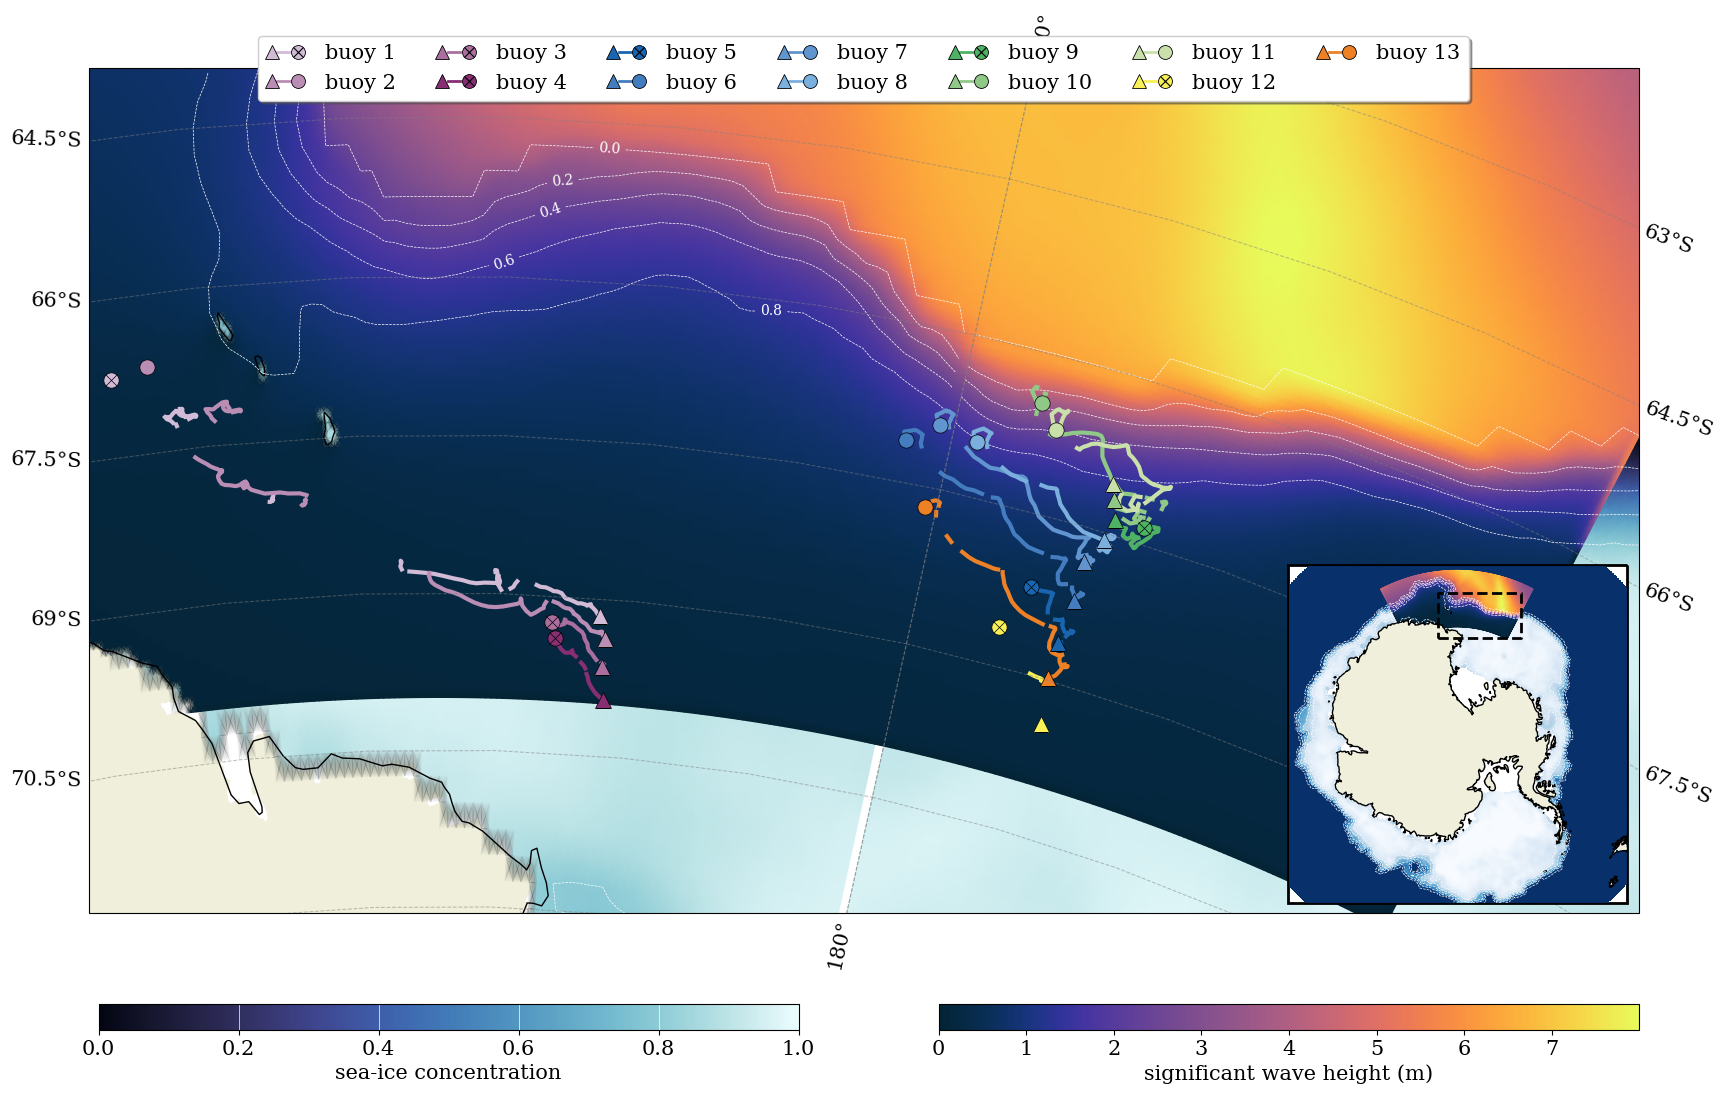

In [18]:
mdat = datetime(2017,6,15)
out_file = 'bouy_era5midJune.png'
cont = plot_buoy_hs_era5(mdat,ds_ww3,out_file)


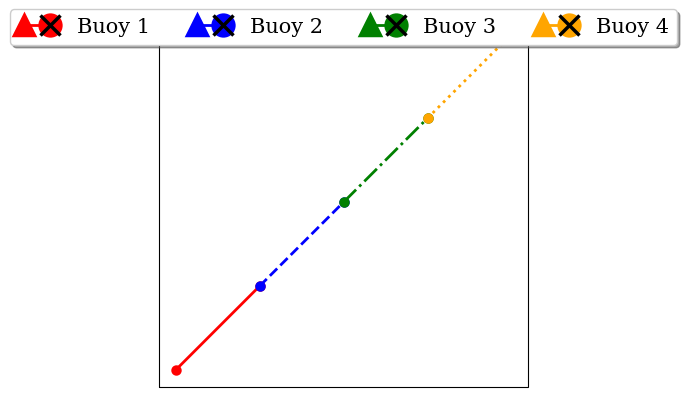

In [39]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cartopy.crs as ccrs

# Define AnyObjectHandler (you already have this class)
class AnyObjectHandler:
    def __init__(self, color):
        self.color = color  # Store the specific color from the array

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        
        # Set up the scaling factors for positioning
        symbol_spacing = 0.25 * width
        
        # Draw triangle at the start
        triangle = Line2D([x0 + symbol_spacing / 2], [y0 + height / 2],
                          color=self.color, marker='^', markersize=fontsize,
                          linestyle='none')
        handlebox.add_artist(triangle)
        
        # Draw short line after the triangle
        line = Line2D([x0 + symbol_spacing, x0 + symbol_spacing + 0.3 * width], 
                      [y0 + height / 2, y0 + height / 2],
                      color=self.color, linewidth=2)
        handlebox.add_artist(line)
        
        # Draw circle with an "x" on top
        circle = Line2D([x0 + symbol_spacing + 0.5 * width], [y0 + height / 2],
                        color=self.color, marker='o', markersize=fontsize,
                        linestyle='none')
        handlebox.add_artist(circle)
        
        x_marker = Line2D([x0 + symbol_spacing + 0.5 * width], [y0 + height / 2],
                          color='k', marker='x', markersize=fontsize,
                          linestyle='none')
        handlebox.add_artist(x_marker)

        return handlebox

# Example of plotting with Cartopy and adding the custom legend symbols
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Example color list for buoys
colrs = ['red', 'blue', 'green', 'orange']

# Plot some dummy data for buoys
pcols = []
for i in range(len(colrs)):
    p = ax.plot([i, i+1], [i, i+1], linewidth=2, marker='o', color=colrs[i],
                label=f'Buoy {i+1}', transform=ccrs.PlateCarree())
    pcols.append(p)

# Create custom handlers for each buoy with corresponding color
handlers = {p[0]: AnyObjectHandler(color=colrs[i]) for i, p in enumerate(pcols)}

# Create the legend with the custom handlers
ax.legend(handler_map=handlers, loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=len(colrs), fancybox=True, shadow=True)

# Draw coastlines
ax.coastlines('50m')

# Display the plot
plt.show()


In [16]:
l = [];
l.append(3)

In [96]:
vs = cont.clabel()
vs[:]

[Text(-1801960.261360556, 2413117.4421975724, '0.0'),
 Text(1848296.7662365548, 2302930.042084746, '0.0'),
 Text(-2472560.2587842606, -1471018.7733142534, '0.2'),
 Text(2241497.561590746, 600607.4614645913, '0.2'),
 Text(-1085332.9298976995, -2620225.4790491597, '0.4'),
 Text(2223138.876595173, -272967.130788899, '0.4'),
 Text(-184184.60482887924, -3243593.8187108277, '0.6'),
 Text(1093128.065400105, 2484322.5074284803, '0.6'),
 Text(1815260.0293110088, -2768731.6750305467, '0.8'),
 Text(-1908722.4245471433, 1993877.4568882883, '0.8'),
 Text(2192080.6660657637, 1592639.8287151204, '0.8'),
 Text(-1333989.4681640193, -2765646.407164561, '0.0'),
 Text(-1394004.2732134275, 2735887.4313278086, '0.0'),
 Text(772228.473345004, 2606999.6353268456, '0.0'),
 Text(2298178.225468315, 1158377.186989545, '0.0'),
 Text(-369578.6051521562, -3243749.7869296498, '0.2'),
 Text(-2874655.410891805, -1103476.8253613077, '0.2'),
 Text(1822513.7829044424, 2270805.110648012, '0.2'),
 Text(2125225.044246219, -1

In [22]:
import tol_colors as tc
cset = tc.tol_cset('muted')
cset

mut_cset(rose='#CC6677', indigo='#332288', sand='#DDCC77', green='#117733', cyan='#88CCEE', wine='#882255', teal='#44AA99', olive='#999933', purple='#AA4499', pale_grey='#DDDDDD', black='#000000')

Older format, these create individual scatter and time plots for each buoy, and a variety of summary plots.

## Correlation Scatter Plots

### Setup for scatter plots

#### General Setup

In [95]:
def mean_profile_data_all():
    freq = np.array(data['freq'][:,0])
    spec_all = np.array(data['psd_filt'])    
    spec_m = np.zeros(55)
    for spec in spec_all[0,:]:
        spec[np.isnan(spec)] = 0
        spec_m += np.nanmean(spec, axis=1)
    return spec_m/4, freq

# takes frequency bounds a creats a period label string
def f_make_label(key):
    if key[0] != 0:
        sp1 = str(int(1/key[0]))
    else:
        sp1 = "inf"
    if key[1] != 1:
        sp2 = str(int(1/key[1]))
    else:
        sp2 = '0'
    #sl = sp2 + "s < T < " + sp1 + "s : np = " + str(np)
    sl = sp2 + " s < T < " + sp1 + " s"
    return sl


def plot_count_hist(ax,bcount,p_split,bt):
    count = np.count_nonzero(~np.isnan(bcount), axis=1)
    wid = []
    x = []
    pl = []
    pcounts = []
    for i in range(len(p_split)-1):
        p0 = p_split[i]
        p = p_split[i+1]
        pl.append('{0:1.2g} to {1:1.2g}'.format(p0,p))
        x.append(p0)
        wid.append((p-p0)*0.96)
        pcounts.append(np.sum(count[np.where((freq>p0) & (freq<p))]))
    #ax.bar(x, pcounts,wid, bottom=None,align='edge', data=None)  
    ax.bar(pl, pcounts,width=0.8, bottom=None)
    ax.set_ylabel("number non-nan values")
    ax.set_xlabel("frequency band")
    ax.set_title(bt)
    ax.set_xticklabels(pl,rotation=35)

In [17]:
# eliminates obs where swh is below thresh
# including corrosponding ice conc data
def eliminate_thresh_ic(b_dat,m_dat,bcount,mtime,ice_conc,thresh):
    bd = np.zeros(len(list(b_dat.values())[0]))
    for key in m_dat:
        bd += np.array(b_dat[key])
    mo = 4*np.sqrt(bd)
    model_dat = {}
    buoy_dat = {}
    #l_inds = np.delete(l_inds,np.where(mo<thresh),0)
    for key in m_dat:
        
        modd = np.delete(m_dat[key],np.where(mo<thresh ),0)
        buoyd = np.delete(b_dat[key],np.where(mo<thresh ),0)
        ice_cc  = np.delete(ice_conc,np.where(mo<thresh),0)
        #nan_indices = np.isnan(buoyd)
        model_dat[key] = modd
        buoy_dat[key] = buoyd
        ice_out = ice_cc
    bcount = np.delete(bcount, np.where(mo<thresh ),1)
    mtime = np.delete(mtime, np.where(mo<thresh ),0)
    return buoy_dat,model_dat,bcount,mtime, ice_out

In [18]:
# eliminates obs where swh is below thresh
def eliminate_thresh(b_dat,m_dat,bcount,mtime,thresh):
    bd = np.zeros(len(list(b_dat.values())[0]))
    for key in m_dat:
        bd += np.array(b_dat[key])
    mo = 4*np.sqrt(bd)
    model_dat = {}
    buoy_dat = {}
    #l_inds = np.delete(l_inds,np.where(mo<thresh),0)
    for key in m_dat:
        
        modd = np.delete(m_dat[key],np.where(mo<thresh ),0)
        buoyd = np.delete(b_dat[key],np.where(mo<thresh ),0)
        #nan_indices = np.isnan(buoyd)
        model_dat[key] = modd
        buoy_dat[key] = buoyd

    bcount = np.delete(bcount, np.where(mo<thresh ),1)
    mtime = np.delete(mtime, np.where(mo<thresh ),0)
    return buoy_dat,model_dat,bcount,mtime

#### Significant Wave Height (ice conc) Setup

In [19]:
# integrate the full spectrum
def bm_int_spec_swh(bspec,mspec,lat,lon):
    split = [0,1]
    overlap_time_range = slice(bspec.time.min(), mspec.time.max())
    mspec = mspec.sel(time=overlap_time_range)
    mtime = mspec['time']
    ltime = bspec['time']
    #bspec = bspec.interp(time=mtime)
    bspec = buoy_interp(bspec,mtime)
    ice_conc = np.array(bspec.seaice)
    
    bcount = np.array(bspec)
    # get the coords 
    int_lat = np.interp(mtime, ltime, lat)
    int_lon = np.interp(mtime, ltime, lon)
    
    
    lons_ww3 = np.array(mspec['longitude'])[0,:]
    lats_ww3 = np.array(mspec['latitude'])[0,:]
    if any(np.isnan(lats_ww3)) | any(np.isnan(lons_ww3)):
        #print("Warning: NAN in station coords")
        lons_ww3 = lons_ww3[~np.isnan(lats_ww3)]
        lats_ww3 = lats_ww3[~np.isnan(lats_ww3)]
        lats_ww3 = lats_ww3[~np.isnan(lons_ww3)]
        lons_ww3 = lons_ww3[~np.isnan(lons_ww3)]
    
    
    iw = np.zeros(len(int_lat))
    for i in range(len(int_lat)):
        iw[i] = np.argmin(np.abs(lons_ww3-int_lon[i]) + np.abs(lats_ww3-int_lat[i]))
  
    #msp = mspec.efth
    #ind = xr.DataArray([np.array(mtime), iw], dims=["time", "station"])
    
    # mspec and bspec now have the same time (mtime)
    bs = bspec.interp(frequency=split, kwargs={'fill_value': 0})
    bs_int = xr.concat([bs, bspec], dim='frequency')
    bs_int = bs_int.sortby('frequency')

  
    ms = mspec.efth.interp(frequency=split, kwargs={'fill_value': 0})
    ms_int = xr.concat([ms, mspec.efth], dim='frequency')
    ms_int = ms_int.sortby('frequency')

    buoy_data  = {}
    model_data = {}
    
    p1 = 0
    p2 = 1
    pair = (p1,p2)
    
    # Spectrum integration
   
    bsl = bs_int.sel(frequency=slice(p1,p2))
    bsl = bsl.fillna(0)
    bsl_ar = np.array(bsl.integrate('frequency') )  
    buoy_data[pair] = bsl_ar

    msl = ms_int.sel(frequency=slice(p1,p2))
    msl_ar = np.array(msl.integrate('frequency'))
    eth = np.zeros(len(int_lat))
    for i in range(len(int_lat)):
        eth[i] = msl_ar[i,int(iw[i])]

    model_data[pair] = eth
    
    return mtime, buoy_data, model_data, bcount, ice_conc

In [20]:
# swh split by ice conc plot (no time plot - covered by pwh plot)
def make_axes_plot_swh_ic(ax_p,bouy_dat,model_dat,mtime,ice_conc,buoy,runtim = 0):
    ax = ax_p[0]
    ax.plot([-1,10], [-1,10], color="grey",linestyle="solid")
    ax.set_prop_cycle(ice_cycler)
    bd = np.zeros(len(list(model_dat.values())[0]))
    md = np.zeros(len(list(model_dat.values())[0]))

    pears = {}
    
    for key in reversed(model_dat):
        bd += np.array(bouy_dat[key])
        md += np.array(model_dat[key])#*np.pi/180 This is no longer needed if rIC files are loaded
        #bdat = np.copy(bouy_dat[key])
        #mdat = np.copy(model_dat[key])*np.pi/180
        #mdat = np.delete(mdat,np.where(bdat==0),0)
        #bdat = np.delete(bdat,np.where(bdat==0),0)
        
        #pr = np.NaN
        #print(inds)
        #bdat = bdat[inds]
        #mdat = mdat[inds]
        #if any(bdat):
            #sl = f_make_label(key,bdat)
            #ax.plot(bdat, mdat, label = sl, alpha = 0.5)
            #ax.loglog(4*np.sqrt(bdat), 4*np.sqrt(mdat), label = sl, alpha = 0.6 )
            #pr = pearsonr(bdat,mdat)
        #pears[key] = pr
    #pears[(0,1)] = pearsonr(bd,md)
    bd = 4*np.sqrt(bd)
    md = 4*np.sqrt(md)
    bout = {}
    mout = {}
    
    for i in range(len(c_split)-1):
        c0 = c_split[i]
        c1 = c_split[i+1]
        
        pair = (c0,c1)
        
        lab = str(c0*100)+' to '+str(c1*100)
        bd_ic = np.zeros(len(list(model_dat.values())[0]))
        md_ic = np.zeros(len(list(model_dat.values())[0]))
        ice_ind = np.where(np.logical_and(ice_conc>c0,ice_conc<c1))[0]
        bd_ic = bd[ice_ind]
        md_ic = md[ice_ind]
        
        bout[pair] = bd_ic
        mout[pair] = md_ic
        
        if len(bd_ic)>2 and len(md_ic)>2:
            pears[pair] = pearsonr(bd_ic,md_ic)
        else:
            pears[pair] = np.nan
        
        ax.loglog(bd_ic, md_ic,label = lab, zorder=0)
        
    
    ax.legend(prop = { "size": 18 }, loc ="lower left")
    #plt.plot([-1,1], [-1,1], color="grey",linestyle="solid", alpha = 0.4)
    ax.grid()
    ax.tick_params(direction='in', length=4, width=1.5, grid_alpha=0.5)
    ax.set_ylabel("model")
    ax.set_xlabel("observation")
    #ax.set_xlim([-0.005,0.25])
    #ax.set_ylim([-0.005,0.25])
    ax.set_xlim([1e-3,10])
    ax.set_ylim([1e-3,10])
    ax.set_title(bt)
    
    # time plot
    #ax = ax_p[1]
    #ax.plot(mtime,bd, color="grey",label = "buoy data")
    #ax.plot(mtime,md, color="teal",label = "model data",alpha=0.7)
    #ax.grid()
    #ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    #ax.tick_params(direction='in', length=4, width=1.5, grid_alpha=0.5)
    #if runtim == 1:
        #ax.set_ylabel("significant wave height")
    #ax.set_xlabel("time")
    #ax.legend(prop = { "size": 9 }, loc ="upper right")
    #ax.set_title(bt)
    return pears, bd, md, bout, mout

In [21]:
# currently unused
# swh plot with no other variable
def make_axes_plot_swh(ax_p,bouy_dat,model_dat,mtime,runtim = 0):
    ax = ax_p[0]
    ax.plot([-1,10], [-1,10], color="grey",linestyle="solid")
    bd = np.zeros(len(list(model_dat.values())[0]))
    md = np.zeros(len(list(model_dat.values())[0]))
    pears = {}
    for key in reversed(model_dat):
        bd += np.array(bouy_dat[key])
        md += np.array(model_dat[key])#*np.pi/180 this is no longer needed if rIC files are loaded
        #bdat = np.copy(bouy_dat[key])
        #mdat = np.copy(model_dat[key])*np.pi/180
        #mdat = np.delete(mdat,np.where(bdat==0),0)
        #bdat = np.delete(bdat,np.where(bdat==0),0)
        
        #pr = np.NaN
        #print(inds)
        #bdat = bdat[inds]
        #mdat = mdat[inds]
        #if any(bdat):
            #sl = f_make_label(key,bdat)
            #ax.plot(bdat, mdat, label = sl, alpha = 0.5)
            #ax.loglog(4*np.sqrt(bdat), 4*np.sqrt(mdat), label = sl, alpha = 0.6 )
            #pr = pearsonr(bdat,mdat)
        #pears[key] = pr
    #pears[(0,1)] = pearsonr(bd,md)
    bd = 4*np.sqrt(bd)
    md = 4*np.sqrt(md)

    #ax.plot(bd, md, color="rosybrown", label = 'Total', zorder=0)
    ax.loglog(bd, md, color="lightseagreen",label = 'Significant Wave Height', zorder=0)
    
    
    ax.legend(prop = { "size": 9 }, loc ="lower left")
    #plt.plot([-1,1], [-1,1], color="grey",linestyle="solid", alpha = 0.4)
    ax.grid()
    ax.tick_params(direction='in', length=4, width=1.5, grid_alpha=0.5)
    ax.set_ylabel("model")
    ax.set_xlabel("observation")
    #ax.set_xlim([-0.005,0.25])
    #ax.set_ylim([-0.005,0.25])
    ax.set_xlim([1e-5,10])
    ax.set_ylim([1e-5,10])
    ax.set_title(bt)
    
    # time plot
    #ax = ax_p[1]
    #ax.plot(mtime,bd, color="grey",label = "buoy data")
    #ax.plot(mtime,md, color="teal",label = "model data",alpha=0.7)
    #ax.grid()
    #ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    #ax.tick_params(direction='in', length=4, width=1.5, grid_alpha=0.5)
    #if runtim == 1:
        #ax.set_ylabel("significant wave height")
    #ax.set_xlabel("time")
    #ax.legend(prop = { "size": 9 }, loc ="upper right")
    #ax.set_title(bt)
    return pears

#### Partial Wave Height Setup

In [22]:
# pwh plots split by pwh
def make_axes_plot_pwh(ax_p,bouy_dat,model_dat,mtime,runtim = 0):
    ax = ax_p[0]
    ax.plot([-1,10], [-1,10], color="grey",linestyle="solid")
    ax.set_prop_cycle(scatter_cycler)
    bd = np.zeros(len(list(model_dat.values())[0]))
    md = np.zeros(len(list(model_dat.values())[0]))
    pears = {}
    mout = {}
    bout = {}
    for key in reversed(model_dat):
        bd += np.array(bouy_dat[key])
        md += np.array(model_dat[key])#*np.pi/180
        bdat = np.copy(bouy_dat[key])
        mdat = np.copy(model_dat[key])#*np.pi/180
        mdat = np.delete(mdat,np.where(bdat==0),0)
        bdat = np.delete(bdat,np.where(bdat==0),0)
        
        pr = np.NaN
        #print(inds)
        #bdat = bdat[inds]
        #mdat = mdat[inds]
        if any(bdat):
            sl = f_make_label(key)
            #ax.plot(bdat, mdat, label = sl, alpha = 0.5)
            ax.loglog(4*np.sqrt(bdat), 4*np.sqrt(mdat), label = sl, alpha = 0.6 )
            pr = pearsonr(4*np.sqrt(bdat),4*np.sqrt(mdat))
        pears[key] = [pr,len(bdat)]
        mout[key] = 4*np.sqrt(mdat)
        bout[key] = 4*np.sqrt(bdat)
        
    bd = 4*np.sqrt(bd)
    md = 4*np.sqrt(md)
    pears[(0,1)] = [pearsonr(bd,md),len(bd)]
    mout[(0,1)] = md
    bout[(0,1)] = bd

    
    #ax.plot(bd, md, color="rosybrown", label = 'Total', zorder=0)
    ax.loglog(bd, md, color="forestgreen",label = 'Total', zorder=0)
    
    
    ax.legend(prop = { "size": 9 }, loc ="lower left")
    #plt.plot([-1,1], [-1,1], color="grey",linestyle="solid", alpha = 0.4)
    ax.grid()
    ax.tick_params(direction='in', length=4, width=1.5, grid_alpha=0.5)
    ax.set_ylabel("model")
    ax.set_xlabel("observation")
    #ax.set_xlim([-0.005,0.25])
    #ax.set_ylim([-0.005,0.25])
    ax.set_xlim([1e-5,10])
    ax.set_ylim([1e-5,10])
    ax.set_title(bt)
    
    # time plot
    ax = ax_p[1]
    ax.plot(mtime,bd, color="grey",label = "buoy data")
    ax.plot(mtime,md, color="teal",label = "model data",alpha=0.7)
    ax.grid()
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    ax.tick_params(direction='in', length=4, width=1.5, grid_alpha=0.5)
    ax.set_ylabel("significant wave height")
    ax.set_xlabel("time")
    ax.legend(prop = { "size": 9 }, loc ="upper right")
    ax.set_title(bt)
    return pears, mout, bout

In [23]:
# integrate different bands of the spectrum
def bm_int_spec_pwh(bspec,mspec,split,lat,lon):
    overlap_time_range = slice(bspec.time.min(), mspec.time.max())
    mspec = mspec.sel(time=overlap_time_range)
    mtime = mspec['time']
    ltime = bspec['time']
    #bspec = bspec.interp(time=mtime)
    bspec = buoy_interp(bspec,mtime)
    bcount = np.array(bspec)
    # get the coords 
    int_lat = np.interp(mtime, ltime, lat)
    int_lon = np.interp(mtime, ltime, lon)
    
    
    lons_ww3 = np.array(mspec['longitude'])[0,:]
    lats_ww3 = np.array(mspec['latitude'])[0,:]
    if any(np.isnan(lats_ww3)) | any(np.isnan(lons_ww3)):
        #print("Warning: NAN in station coords")
        lons_ww3 = lons_ww3[~np.isnan(lats_ww3)]
        lats_ww3 = lats_ww3[~np.isnan(lats_ww3)]
        lats_ww3 = lats_ww3[~np.isnan(lons_ww3)]
        lons_ww3 = lons_ww3[~np.isnan(lons_ww3)]
    
    
    iw = np.zeros(len(int_lat))
    for i in range(len(int_lat)):
        iw[i] = np.argmin(np.abs(lons_ww3-int_lon[i]) + np.abs(lats_ww3-int_lat[i]))
  
    #msp = mspec.efth
    #ind = xr.DataArray([np.array(mtime), iw], dims=["time", "station"])
    
    # mspec and bspec now have the same time (mtime)
    bs = bspec.interp(frequency=split, kwargs={'fill_value': 0})
    bs_int = xr.concat([bs, bspec], dim='frequency')
    bs_int = bs_int.sortby('frequency')

  
    ms = mspec.efth.interp(frequency=split, kwargs={'fill_value': 0})
    ms_int = xr.concat([ms, mspec.efth], dim='frequency')
    ms_int = ms_int.sortby('frequency')

    buoy_data  = {}
    model_data = {}
    # Split the dataset
    for i in range(len(split)-1):
        p1 = split[i]
        p2 = split[i+1]
        pair = (p1,p2)
        bsl = bs_int.sel(frequency=slice(p1,p2))
        bsl = bsl.fillna(0)
        bsl_ar = np.array(bsl.integrate('frequency') )  
        buoy_data[pair] = bsl_ar
        
        msl = ms_int.sel(frequency=slice(p1,p2))
        msl = np.array(msl.integrate('frequency'))
        eth = np.zeros(len(int_lat))
        for i in range(len(int_lat)):
            eth[i] = msl[i,int(iw[i])]
        
        model_data[pair] = eth
    return mtime, buoy_data, model_data, bcount

#### Mean Wave Period Setup

In [24]:
# integrate the spectrum for both halves of the mean wave period fraction 
# returns both halves of the mwp fraction to be combined in the make_plot function
def bm_int_spec_mwp(bspec,mspec,lat,lon):
    split=[0,1]
    overlap_time_range = slice(bspec.time.min(), mspec.time.max())
    mspec = mspec.sel(time=overlap_time_range)
    mtime = mspec['time']
    ltime = bspec['time']
    #bspec = bspec.interp(time=mtime)
    bspec = buoy_interp(bspec,mtime)
    bcount = np.array(bspec)
    # get the coords 
    int_lat = np.interp(mtime, ltime, lat)
    int_lon = np.interp(mtime, ltime, lon)
    
    
    lons_ww3 = np.array(mspec['longitude'])[0,:]
    lats_ww3 = np.array(mspec['latitude'])[0,:]
    if any(np.isnan(lats_ww3)) | any(np.isnan(lons_ww3)):
        #print("Warning: NAN in station coords")
        lons_ww3 = lons_ww3[~np.isnan(lats_ww3)]
        lats_ww3 = lats_ww3[~np.isnan(lats_ww3)]
        lats_ww3 = lats_ww3[~np.isnan(lons_ww3)]
        lons_ww3 = lons_ww3[~np.isnan(lons_ww3)]
    
    
    iw = np.zeros(len(int_lat))
    for i in range(len(int_lat)):
        iw[i] = np.argmin(np.abs(lons_ww3-int_lon[i]) + np.abs(lats_ww3-int_lat[i]))
  
    #msp = mspec.efth
    #ind = xr.DataArray([np.array(mtime), iw], dims=["time", "station"])
    
    # mspec and bspec now have the same time (mtime)
    bs = bspec.interp(frequency=split, kwargs={'fill_value': 0})
    bs_int = xr.concat([bs, bspec], dim='frequency')
    bs_int = bs_int.sortby('frequency')

  
    ms = mspec.efth.interp(frequency=split, kwargs={'fill_value': 0})
    ms_int = xr.concat([ms, mspec.efth], dim='frequency')
    ms_int = ms_int.sortby('frequency')

    buoy_data_num  = {}
    model_data_num = {}
    buoy_data_den  = {}
    model_data_den = {}
    
    p1 = 0
    p2 = 1
    pair = (p1,p2)
    
    # Numerator integration
   
    bsl = bs_int.sel(frequency=slice(p1,p2))
    bsl = bsl.fillna(0)
    bsl_ar = np.array(bsl.integrate('frequency') )  
    buoy_data_num[pair] = bsl_ar

    msl = ms_int.sel(frequency=slice(p1,p2))
    msl = np.array(msl.integrate('frequency'))
    eth = np.zeros(len(int_lat))
    for i in range(len(int_lat)):
        eth[i] = msl[i,int(iw[i])]

    model_data_num[pair] = eth
    
    # Denominator integration - times frequency squared

    bsl = bs_int.sel(frequency=slice(p1,p2))
    bsl = bsl.fillna(0)
    bsl = bsl*((bsl.frequency)**2)
    bsl_ar = np.array(bsl.integrate('frequency') )  
    buoy_data_den[pair] = bsl_ar
    
    msl = ms_int.sel(frequency=slice(p1,p2))
    msl = msl*((msl.frequency)**2)
    msl = np.array(msl.integrate('frequency'))
    eth = np.zeros(len(int_lat))
    for i in range(len(int_lat)):
        eth[i] = msl[i,int(iw[i])]

    model_data_den[pair] = eth
        
    return mtime, buoy_data_num, model_data_num, buoy_data_den, model_data_den, bcount

In [25]:
def make_axes_plot_mwp(ax_p,buoy_dat,model_dat,buoy_den,model_den,mtime,runtim = 0):
    ax = ax_p[0]
    ax.plot([-1,100], [-1,100], color="grey",linestyle="solid")
    bdd = np.zeros(len(list(model_dat.values())[0]))
    mdd = np.zeros(len(list(model_dat.values())[0]))
    bdn = np.zeros(len(list(model_den.values())[0]))
    mdn = np.zeros(len(list(model_den.values())[0]))
    pears = {}
    mout = {}
    bout = {}
    for key in reversed(model_dat):
        bdd += np.array(buoy_dat[key])
        mdd += np.array(model_dat[key])#*np.pi/180
        bdn += np.array(buoy_den[key])
        mdn += np.array(model_den[key])#*np.pi/180
        #bdat = np.copy(bouy_dat[key])
        #mdat = np.copy(model_dat[key])*np.pi/180
        #mdat = np.delete(mdat,np.where(bdat==0),0)
        #bdat = np.delete(bdat,np.where(bdat==0),0)
        
        #pr = np.NaN
        #print(inds)
        #bdat = bdat[inds]
        #mdat = mdat[inds]
        #if any(bdat):
            #sl = f_make_label(key,bdat)
            #ax.plot(bdat, mdat, label = sl, alpha = 0.5)
            #ax.loglog(4*np.sqrt(bdat), 4*np.sqrt(mdat), label = sl, alpha = 0.7 )
            #pr = pearsonr(bdat,mdat)
        #pears[key] = pr
    #pears[(0,1)] = pearsonr(bd,md)
    bd = np.sqrt(bdd/bdn)
    md = np.sqrt(mdd/mdn)
    mout[(0,1)] = md
    bout[(0,1)] = bd
    
    indices = ~(np.logical_or(np.isinf(bd), np.isinf(md)))     
    indices = np.array(indices)
    bd_if = bd[indices]
    md_if = md[indices]
    
    indices = ~(np.logical_or(np.isnan(bd_if), np.isnan(md_if)))     
    indices = np.array(indices)
    bd_f = bd_if[indices]
    md_f = md_if[indices]
    if len(bd_f)>2 and len(md_f)>2:
        pears[(0,1)] = pearsonr(bd_f,md_f)
    else:
        pears[(0,1)] = np.nan
    
    #pears[(0,1)] = pearsonr(bd,md)

    #ax.plot(bd, md, color="rosybrown", label = 'Total', zorder=0)
    ax.plot(bd, md, color="goldenrod", label = 'Mean Wave Period', zorder=0)
    
    
    ax.legend(prop = { "size": 9 }, loc ="lower left")
    #plt.plot([-1,1], [-1,1], color="grey",linestyle="solid", alpha = 0.4)
    ax.grid()
    ax.tick_params(direction='in', length=4, width=1.5, grid_alpha=0.5)
    ax.set_ylabel("model")
    ax.set_xlabel("observation")
    #ax.set_xlim([-0.005,0.25])
    #ax.set_ylim([-0.005,0.25])
    ax.set_xlim([0,30])
    ax.set_ylim([0,30])
    ax.set_title(bt)
    
    # time plot
    ax = ax_p[1]
    ax.plot(mtime,bd, color="grey",label = "buoy data")
    ax.plot(mtime,md, color="goldenrod",label = "model data",alpha=0.7)
    ax.grid()
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    ax.tick_params(direction='in', length=4, width=1.5, grid_alpha=0.5)
    ax.set_ylabel("mean wave period")
    ax.set_xlabel("time")
    ax.legend(prop = { "size": 9 }, loc ="upper right")
    ax.set_title(bt)
    return pears, bout, mout

In [26]:
# eliminates obs where swh is below thresh
# including both halves of the mwp fraction
def eliminate_thresh_mwp(b_dat,m_dat,b_den, m_den, bcount,mtime,thresh):
    bd = np.zeros(len(list(b_dat.values())[0]))
    for key in m_dat:
        bd += np.array(b_dat[key])
    mo = 4*np.sqrt(bd)
    model_dat = {}
    buoy_dat = {}
    model_den = {}
    buoy_den = {}
    #l_inds = np.delete(l_inds,np.where(mo<thresh),0)
    for key in m_dat:
        moddn = np.delete(m_dat[key],np.where(mo<thresh ),0)
        buoydn = np.delete(b_dat[key],np.where(mo<thresh ),0)
        moddd = np.delete(m_den[key],np.where(mo<thresh),0)
        buoydd = np.delete(b_den[key],np.where(mo<thresh),0)
        #nan_indices = np.isnan(buoyd)
        model_dat[key] = moddn
        buoy_dat[key] = buoydn
        model_den[key] = moddd
        buoy_den[key] = buoydd
        
    bcount = np.delete(bcount, np.where(mo<thresh ),1)
    mtime = np.delete(mtime, np.where(mo<thresh ),0)
    return buoy_dat,model_dat,buoy_den,model_den,bcount,mtime

#### Final Setup

In [10]:
freq = np.array(data_in['freq'][:,0])
#time_64 = np.arange(np.datetime64('2017-04-21T04:00:00'), np.datetime64('2017-07-07T04:01:00'), np.timedelta64(15, 'm'))

# splits to use for pwh and ice
p_split = [0,1/20,1/16,1/12,1/8,1]
c_split = [0,0.5,0.6,0.7,0.8,0.9,1]
# make all the plots
file_names = os.listdir(ddir)
#filtered_files = [ filename for filename in file_names if ( filename.startswith("IC") and ('0' not in filename))]
# to adjust order of models or run only a subset
filtered_files = ['IC5VEMOD3.nc',
'IC5VEMOD2.nc',
 'IC5VEMOD1.nc',
 'IC4M7.nc',
 'IC4M6.nc',
 'IC4M5.nc',
 'IC4M4.nc',
 'IC4M3.nc',
 'IC4M2.nc',
 'IC4M1.nc',
 'IC3.nc',
 'IC2.nc',
 'IC1.nc']
filtered_files2 = ['IC5VEMOD2.nc']
filtered_files4 = ['IC4M7.nc']

### Making plots

## Correlation Summary Plots

### General setup

In [11]:
# convert the list of file names from filtered_files to a list of model names, eg IC1.nc -> IC1
filtered_names = ['1']*len(filtered_files)
for i in range(len(filtered_names)):
    fn = filtered_files[i]
    fns = fn.split('.')
    filtered_names[i] = fns[0]

# convert the boundries from the splits to a list of tuples, eg [0,0.5,0.6...] -> [(0,0.5),(0.5,0.6)...]
splits = list(range(len(p_split)-1))
for i in range(len(p_split)-1):
    p0 = p_split[i]
    p1 = p_split[i+1]
    splits[i] = (p0,p1)
c_splits = list(range(len(c_split)-1))
for i in range(len(c_split)-1):
    p0 = c_split[i]
    p1 = c_split[i+1]
    c_splits[i] = (p0,p1)

In [29]:
with open('correlation_pwh.pkl', 'rb') as f:
    cor_pwh = pickle.load(f)

with open('buoy_points_pwh.pkl', 'rb') as f:
    bp_pwh = pickle.load(f)
    
with open('model_points_pwh.pkl', 'rb') as f:
    mp_pwh = pickle.load(f)

with open('correlation_mwp.pkl', 'rb') as f:
    cor_mwp = pickle.load(f)
    
with open('buoy_points_mwp.pkl', 'rb') as f:
    bp_mwp = pickle.load(f)
    
with open('model_points_mwp.pkl', 'rb') as f:
    mp_mwp = pickle.load(f)
    
with open('correlation_mwp_cut.pkl', 'rb') as f:
    cor_mwp_cut = pickle.load(f)
    
with open('buoy_points_mwp_cut.pkl', 'rb') as f:
    bp_mwp_cut = pickle.load(f)
    
with open('model_points_mwp_cut.pkl', 'rb') as f:
    mp_mwp_cut = pickle.load(f)
    
with open('buoy_points_ice_swh.pkl', 'rb') as f:
    bp_ice = pickle.load(f)
    
with open('model_points_ice_swh.pkl', 'rb') as f:
    mp_ice = pickle.load(f)

with open('correlation_swh_ice.pkl', 'rb') as f:
    cor_ice = pickle.load(f)

### Pearson correlation CI plots

These calculate and plot the pearson coefficients for all the buoys combined, with a 95% CI.

In [30]:
# getting pearson coefficients for the pwh data not split by buoy
def filter_pts(bp,mp,split=(0,1)):
    cor_pwh_pt = [0]*len(filtered_names)
    cor_pwh_ci = [0]*len(filtered_names)
    for model in range(len(filtered_names)):
        fn = filtered_names[model]
        bp_fn = bp[fn][split]
        mp_fn = mp[fn][split]
        
        pears = pearsonr(bp_fn,mp_fn)
        
        cor_pwh_pt[model] = pears.statistic
        lower = pears.confidence_interval().low
        upper = pears.confidence_interval().high
        cor_pwh_ci[model] = [lower,upper]
        cor_pwh_ci_out = cor_pwh_ci
    return cor_pwh_pt, cor_pwh_ci_out

In [31]:
# getting pearson coefficients for the mwp data not split by buoy
def filter_pts_mwp(bp,mp,split=(0,1)):
    cor_pwh_pt = [0]*len(filtered_names)
    cor_pwh_ci = [0]*len(filtered_names)
    for model in range(len(filtered_names)):
        fn = filtered_names[model]
        bp_fn = bp[fn][split]
        mp_fn = mp[fn][split]
        
        indices = ~(np.logical_or(np.isnan(bp_fn), np.isnan(mp_fn)))     
        indices = np.array(indices)
        bp_fn_nn = bp_fn[indices]
        mp_fn_nn = mp_fn[indices]
        
        if len(bp_fn_nn)>2 and len(mp_fn_nn)>2:
            pears = pearsonr(bp_fn_nn,mp_fn_nn)
        else:
            pears = np.nan
        
        cor_pwh_pt[model] = pears.statistic
        lower = pears.confidence_interval().low
        upper = pears.confidence_interval().high
        cor_pwh_ci[model] = [lower,upper]
        cor_pwh_ci_out = cor_pwh_ci
    return cor_pwh_pt, cor_pwh_ci_out

In [32]:
# plots the mwp correlation - unreliable sorting
def cor_all_plot_mwp(cor_stat_plot,cor_ci,ptitle):
    
    ci_upper = [0]*len(cor_ci)
    ci_lower = [0]*len(cor_ci)
    ci_arr = [0]*2
    
    # arrange the confidence interval
    for i in range(len(cor_ci)):
        ci_lower[i] = cor_ci[i][0]
    
    for i in range(len(cor_ci)):
        ci_upper[i] = cor_ci[i][1]
    
    # order the points
    cor_arr = (cor_stat_plot)
    cor_dsc = np.sort(cor_arr)
    
    box_order = np.zeros(len(filtered_files),dtype=int)
    for i in range(len(cor_dsc)):
        box_order[i]=np.where(cor_dsc[i] == cor_arr)[0]

    filtered_names_sort = np.copy(filtered_names)
    for i in range(len(filtered_names)):
        filtered_names_sort[i] = filtered_names[box_order[i]]
    
    ci_u_sort = np.copy(ci_upper)
    for i in range(len(filtered_names)):
        ci_u_sort[i] = ci_upper[box_order[i]]

    ci_l_sort = np.copy(ci_lower)
    for i in range(len(filtered_names)):
        ci_l_sort[i] = ci_lower[box_order[i]]
    
    
    ci_u_len = np.copy(ci_u_sort)
    for i in range(len(filtered_names)):
        ci_u_len[i] = abs(ci_u_sort[i]-cor_arr[i])

    ci_l_len = np.copy(ci_l_sort)
    for i in range(len(filtered_names)):
        ci_l_len[i] = abs(ci_l_sort[i]-cor_arr[i])
    
    ci_arr = [ci_l_len,ci_u_len]
    
    # plot the points
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
    
    box = ax1.errorbar(cor_dsc,filtered_names_sort,xerr=ci_arr,color='black',capsize=2,capthick=0.75,linewidth=0.75)
    
    ax1.xaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)
    
    ax1.set(
            title=ptitle,
            xlabel='pearson correlation coefficient (95% CI)',
            
        )
    plt.show()
    fig.savefig(ptitle,dpi=300)

In [33]:
# plots the pwh correlation - unreliable sorting
def cor_all_plot(ax,cor_stat_plot,cor_ci,split,xlims=[-1,1],label_type = 0):
    
    ci_upper = [0]*len(cor_ci)
    ci_lower = [0]*len(cor_ci)
    ci_arr = [0]*2
    
    # arrange the confidence interval
    for i in range(len(cor_ci)):
        ci_lower[i] = cor_ci[i][0]
    
    for i in range(len(cor_ci)):
        ci_upper[i] = cor_ci[i][1]
    
    # order the points
    cor_arr = (cor_stat_plot)
    cor_dsc = np.sort(cor_arr)
    
    box_order = np.zeros(len(filtered_files),dtype=int)
    for i in range(len(cor_dsc)):
        box_order[i]=np.where(cor_dsc[i] == cor_arr)[0]

    filtered_names_sort = np.copy(filtered_names)
    for i in range(len(filtered_names)):
        filtered_names_sort[i] = filtered_names[box_order[i]]
    
    ci_u_sort = np.copy(ci_upper)
    for i in range(len(filtered_names)):
        ci_u_sort[i] = ci_upper[box_order[i]]

    ci_l_sort = np.copy(ci_lower)
    for i in range(len(filtered_names)):
        ci_l_sort[i] = ci_lower[box_order[i]]
    
    
    ci_u_len = np.copy(ci_u_sort)
    for i in range(len(filtered_names)):
        ci_u_len[i] = abs(ci_u_sort[i]-cor_arr[i])

    ci_l_len = np.copy(ci_l_sort)
    for i in range(len(filtered_names)):
        ci_l_len[i] = abs(ci_l_sort[i]-cor_arr[i])
    
    ci_arr = [ci_l_len,ci_u_len]
    
    # plot the points
    
    box = ax.errorbar(cor_dsc,filtered_names_sort,xerr=ci_arr,color='black',capsize=2,capthick=0.75,linewidth=0.75)
    
    ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)
    if label_type == 0:     
        ptitle = f_make_label(split)
        
    if label_type == 1:
        ptitle = str(split)
    
    ax.set(
            title=ptitle,
            xlabel='pearson correlation coefficient (95% CI)',
            xlim = xlims
            
        )

In [34]:
# makes a single image of all 6 pwh splits
def pearson_sub(b_pwh,mp_pwh):
    
    fig1, ax1 = plt.subplots(2, 3, figsize=(25, 15))
    
    for i  in range(len(splits)):
        split = splits[i]
        axes = ax1.flat[i]
        cor_all, cor_ci = filter_pts(bp_pwh,mp_pwh,split)
        cor_all_plot(axes,cor_all, cor_ci,split,[-0.1,0.7],label_type=0)
    plt.subplots_adjust(wspace=0.3)
    plt.show()
    fig1.savefig('pearson_correlation_subplots',dpi=300)

In [35]:
# makes a single image of all 6 ice splits
def pearson_sub_ice(b_ice,m_ice):
    
    fig1, ax1 = plt.subplots(2, 3, figsize=(25, 15))
    
    for i  in range(len(c_splits)):
        split = c_splits[i]
        axes = ax1.flat[i]
        cor_all, cor_ci = filter_pts(b_ice,m_ice,split)
        cor_all_plot(axes,cor_all, cor_ci,split,[-0.1,1],label_type=1)
    plt.subplots_adjust(wspace=0.3)
    plt.show()
    fig1.savefig('pearson_correlation_ice_subplots',dpi=300)

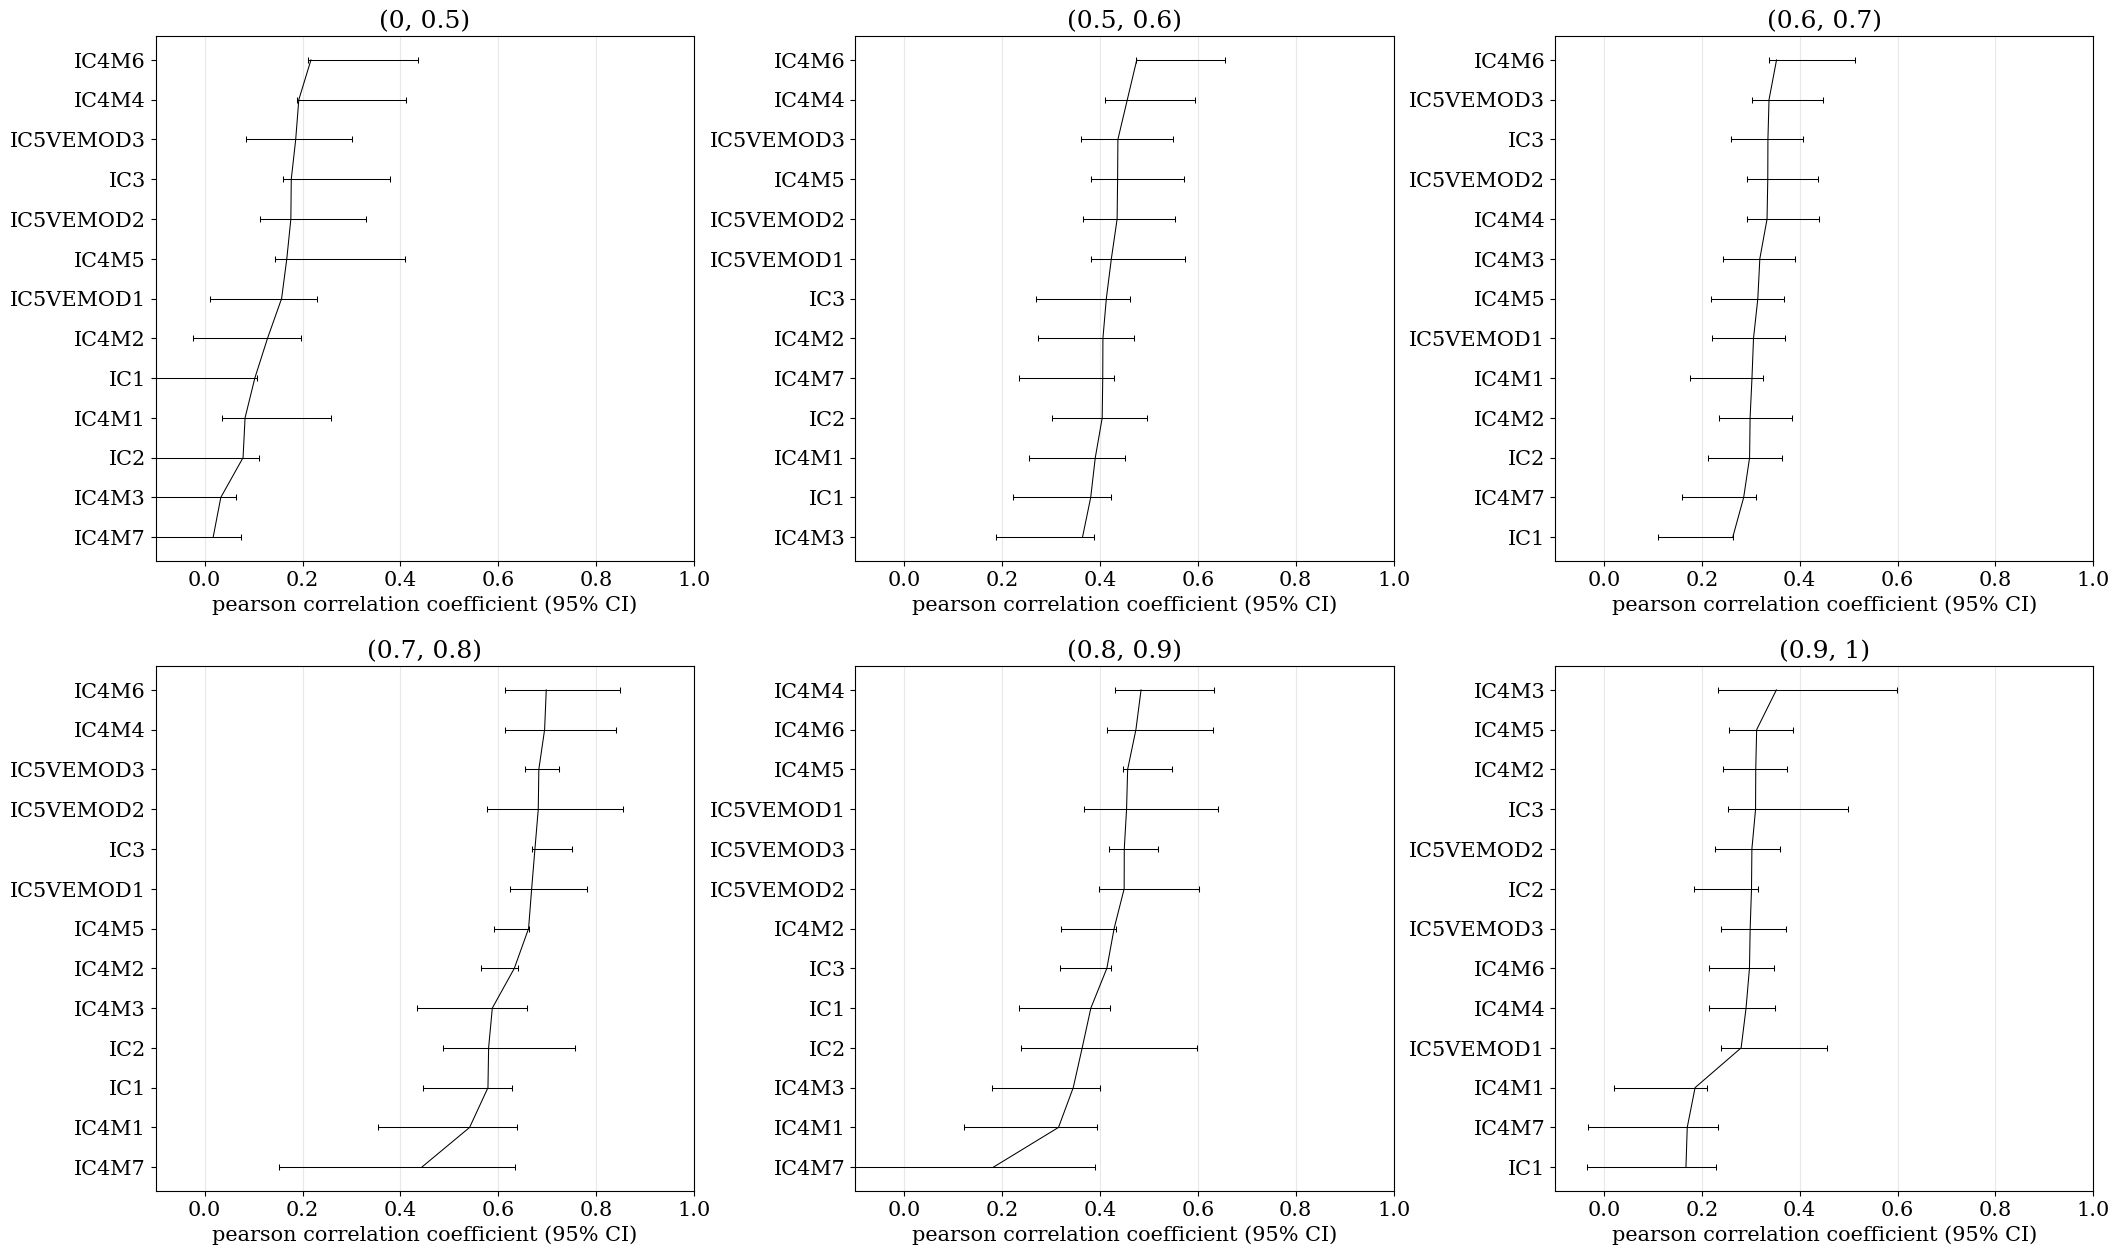

In [36]:
pearson_sub_ice(bp_ice,mp_ice)

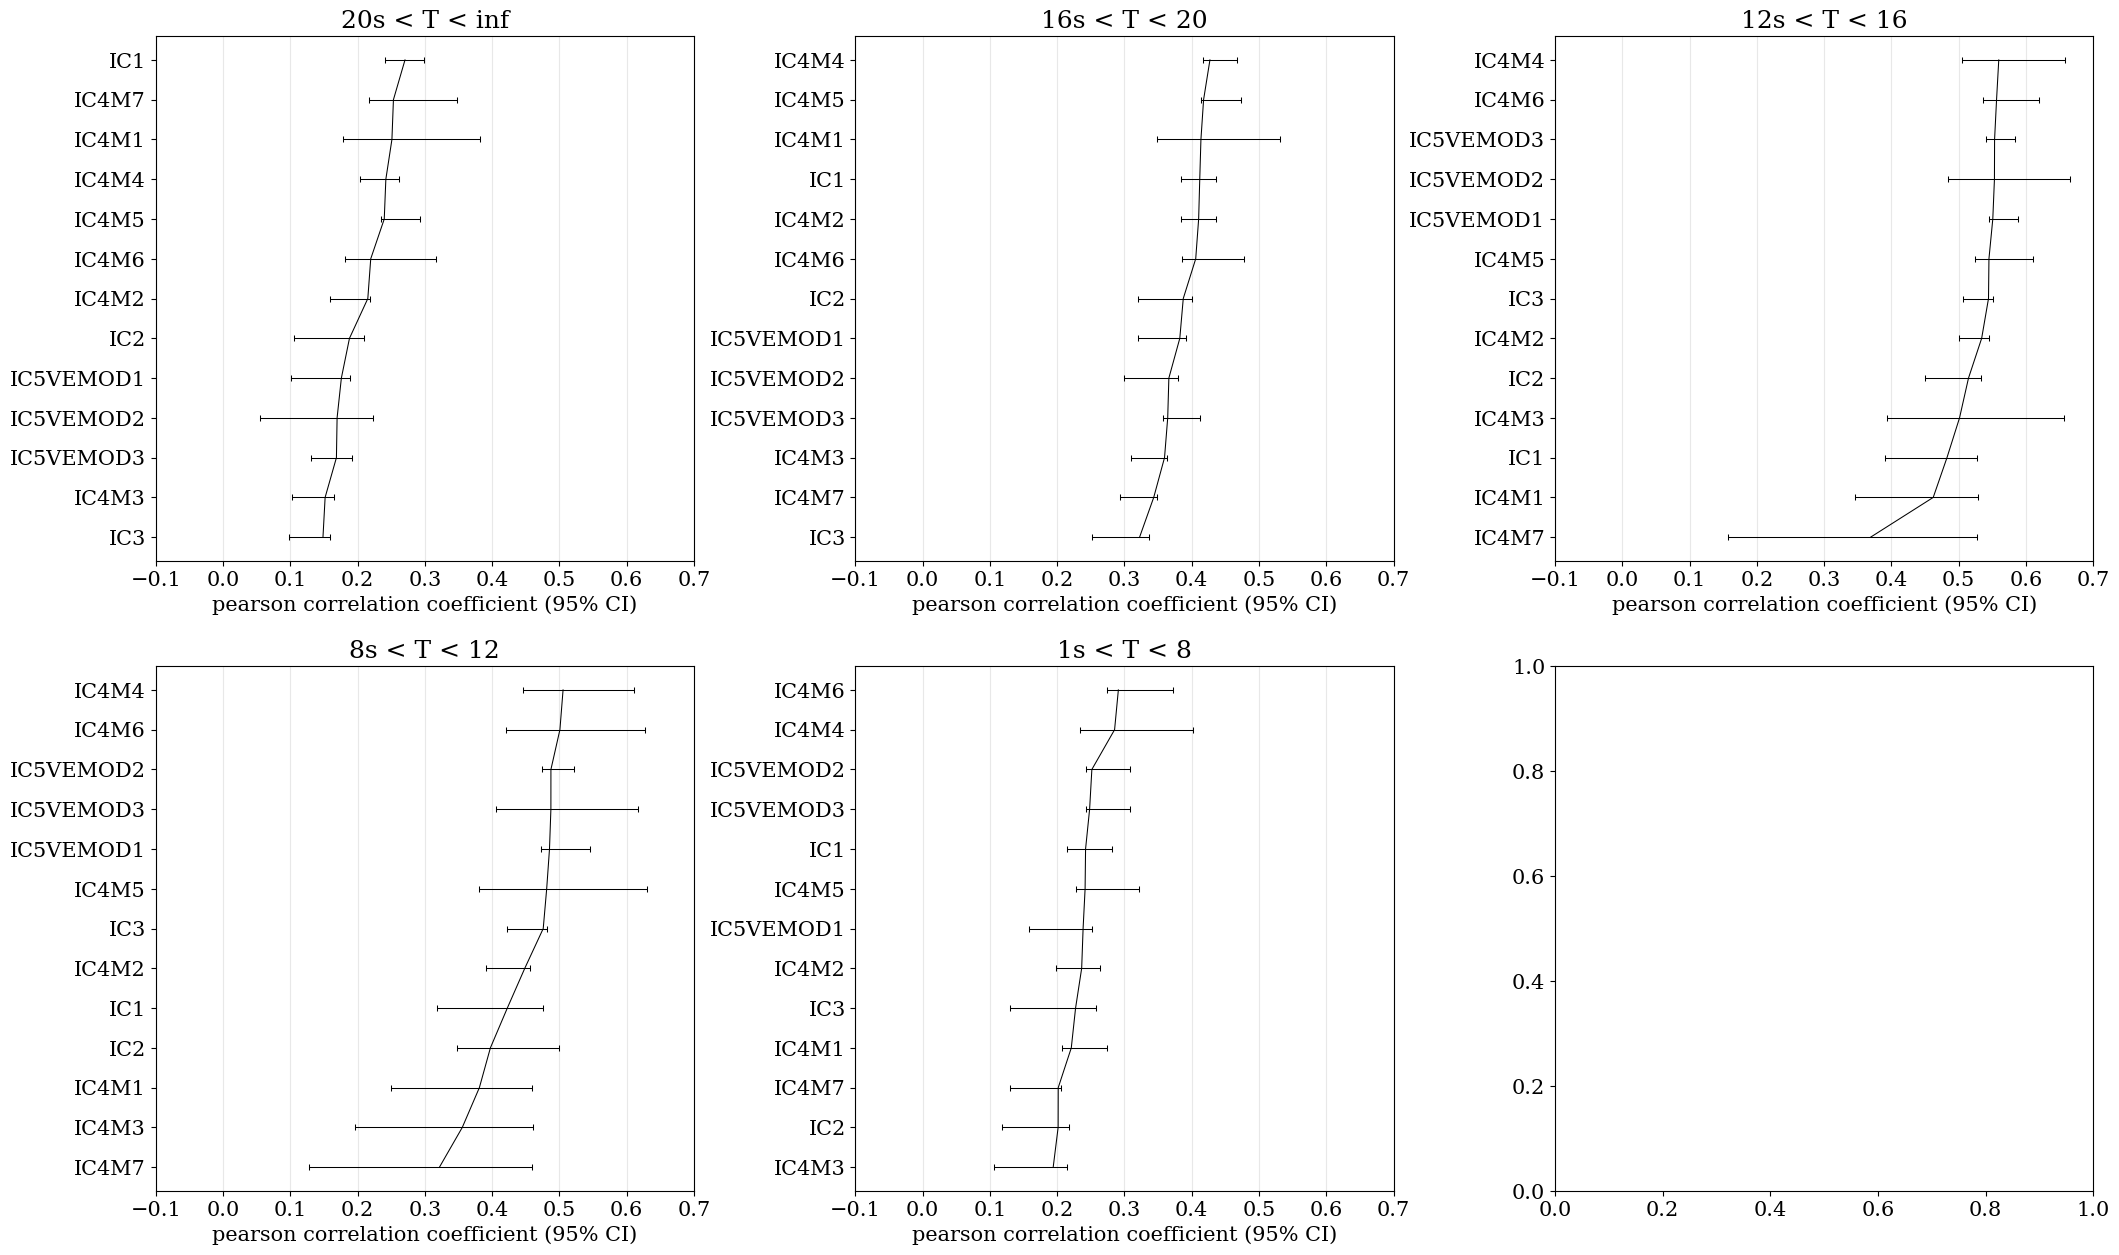

In [37]:
pearson_sub(bp_pwh,mp_pwh)

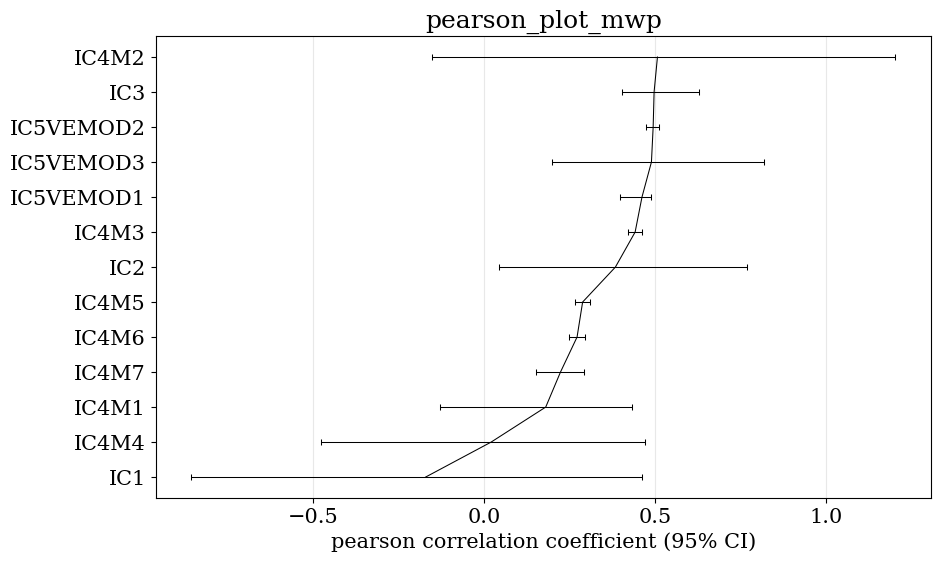

In [38]:
cor_all, cor_ci = filter_pts_mwp(bp_mwp,mp_mwp)
cor_all_plot_mwp(cor_all, cor_ci,'pearson_plot_mwp')

### Pearson correlaton boxplots

These plot the pearson coefficients for each buoy seperately as a boxplot

In [39]:
# Sorting out the correlation statistics by model
def filter_cor_mwp(cor_stat):
    cor_out = {}
    split = (0,1)
    for fn in filtered_files:
        fns = fn.split('.')
        bcorr = {}
        for buoy in range(len(cor_stat[fns[0]])):
            if hasattr(cor_stat[fns[0]][buoy][split],'statistic'):
                bcorr[buoy] = cor_stat[fns[0]][buoy][split].statistic
            else:
                bcorr[buoy] = cor_stat[fns[0]][buoy][split]
            cor_out[fns[0]] = bcorr
    return cor_out

In [40]:
# Sorting out the correlation statistics by model
def filter_cor(cor_stat,split=(0,1)):
    cor_out = {}
    for fn in filtered_files:
        fns = fn.split('.')
        bcorr = {}
        for buoy in range(len(cor_stat[fns[0]])):
            if hasattr(cor_stat[fns[0]][buoy][split][0],'statistic'):
                bcorr[buoy] = cor_stat[fns[0]][buoy][split][0].statistic
            else:
                bcorr[buoy] = cor_stat[fns[0]][buoy][split][0]
        cor_out[fns[0]] = bcorr
    return cor_out

In [41]:
def make_cor_box(ax,cor_stat,split):
    # makes the correaltion statistics into a list, and removes nans
    data = list()
    for model in range(len(filtered_files)):
        fn = filtered_files[model]
        fns = fn.split('.')[0]
        cor_points = np.zeros(len(cor_stat[fns]))
        for buoy in range(len(cor_stat[fns])):
            cor_points[buoy] = (np.array(cor_stat[fns][buoy]))
        data.append(cor_points)
    mask = ~np.isnan(data)
    cor_stat_plot = [d[m] for d, m in zip(data, mask)]

    # getting the boxes in median order
    cor_med = list()
    for i in range(len(cor_stat_plot)):
        cor_med.append(np.median(cor_stat_plot[i]))
    cor_med = np.array(cor_med)
    cor_dsc = (np.sort(cor_med))
    box_order = np.zeros(len(filtered_files))
    for i in range(len(cor_dsc)):
        box_order[i]=np.where(cor_med[i] == cor_dsc)[0]
    box_order = (box_order)

    # making the boxplot
    box = ax.boxplot(cor_stat_plot, notch=False, sym='.', vert=False, whis=1.5, positions=(box_order))
    plt.setp(box['boxes'], color='black')
    plt.setp(box['whiskers'], color='black')
    plt.setp(box['fliers'], color='red', marker='+')

    ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)

    plot_title = f_make_label(split)
    
    ax.set(
        axisbelow=True,  # Hide the grid behind plot objects
        title=plot_title,
        xlabel='buoy pearson correlation coefficient',
        yticklabels=filtered_names,
        xlim = [-1,1]
    )

In [42]:
def boxplot_sub(cor_stat):
    
    fig1, ax1 = plt.subplots(2, 3, figsize=(25, 15))
    
    for i  in range(len(splits)):
        split = splits[i]
        axes = ax1.flat[i]
        cor_fil = filter_cor(cor_stat,split)
        make_cor_box(axes,cor_fil,split)
    plt.subplots_adjust(wspace=0.3)
    plt.show()
    fig1.savefig('pearson_correlation_boxplots',dpi=300)

In [43]:
def make_cor_box_mwp(cor_stat,plot_title):
    # makes the correaltion statistics into a list, and removes nans
    data = list()
    for model in range(len(filtered_files)):
        fn = filtered_files[model]
        fns = fn.split('.')[0]
        cor_points = np.zeros(len(cor_stat[fns]))
        for buoy in range(len(cor_stat[fns])):
            cor_points[buoy] = (np.array(cor_stat[fns][buoy]))
        data.append(cor_points)
    mask = ~np.isnan(data)
    cor_stat_plot = [d[m] for d, m in zip(data, mask)]

    # getting the boxes in median order
    cor_med = list()
    for i in range(len(cor_stat_plot)):
        cor_med.append(np.median(cor_stat_plot[i]))
    cor_med = np.array(cor_med)
    cor_dsc = (np.sort(cor_med))
    box_order = np.zeros(len(filtered_files))
    for i in range(len(cor_dsc)):
        box_order[i]=np.where(cor_med[i] == cor_dsc)[0]
    box_order = (box_order)

    # making the boxplot
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
    box = ax1.boxplot(cor_stat_plot, notch=False, sym='.', vert=False, whis=1.5, positions=(box_order))
    plt.setp(box['boxes'], color='black')
    plt.setp(box['whiskers'], color='black')
    plt.setp(box['fliers'], color='red', marker='+')

    ax1.xaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)

    ax1.set(
        axisbelow=True,  # Hide the grid behind plot objects
        title=plot_title,
        xlabel='pearson correlation coefficient',
        yticklabels=filtered_names,
        xlim = [-1,1]
    )

    plt.show()
    fig.savefig(plot_title,dpi=300)

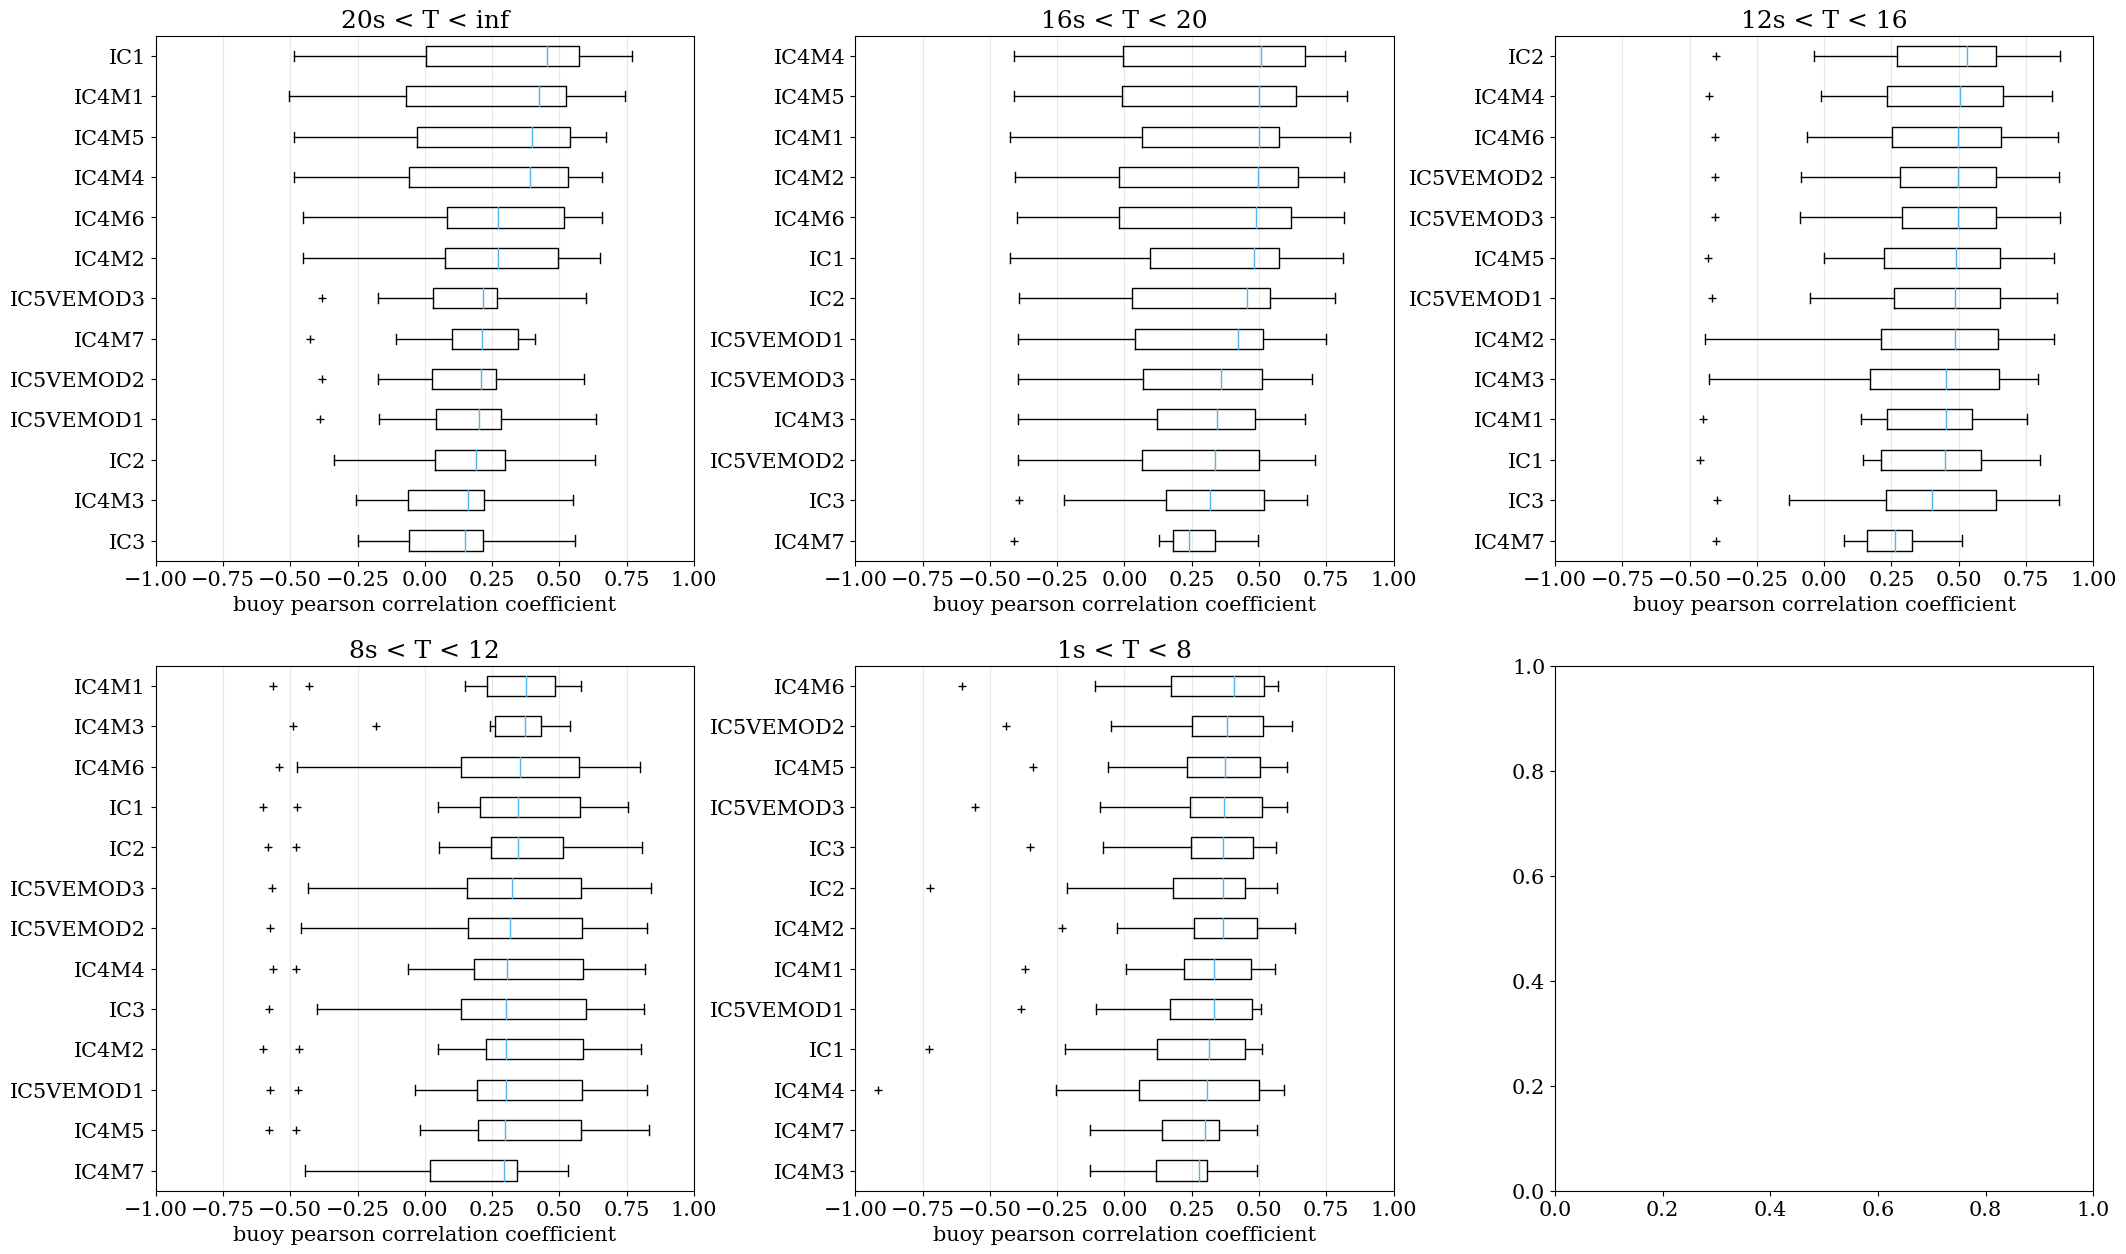

In [44]:
boxplot_sub(cor_pwh)

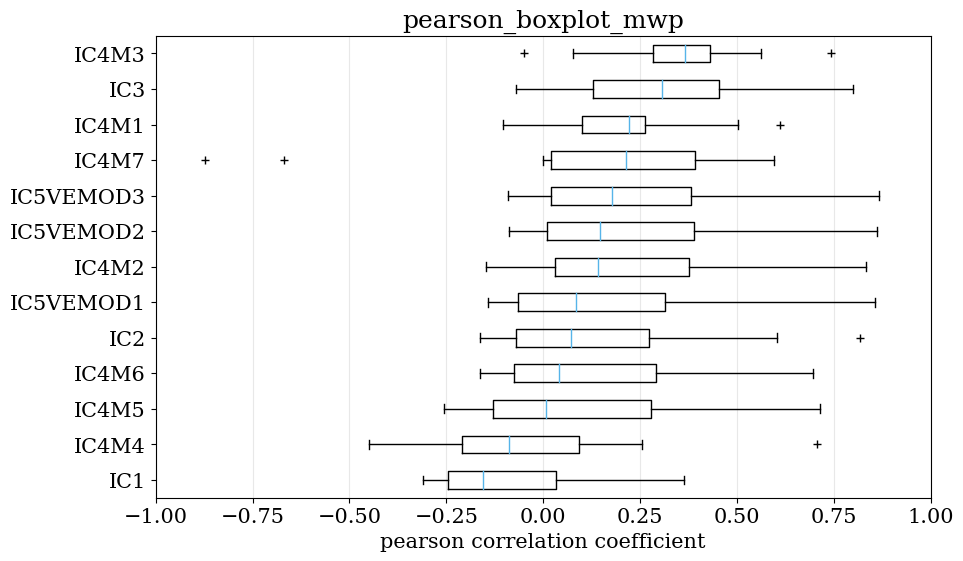

In [45]:
cor_fil = filter_cor_mwp(cor_mwp)
make_cor_box_mwp(cor_fil,'pearson_boxplot_mwp')

### Residual Boxplots

These plot the difference between the model and buoy data

In [46]:
def filter_res_mb_mwp2(mp_pwh,bp_pwh,split=(0,1)):
    res_out = {}
    res_stn = {}
    for fn in filtered_files:
        fns = fn.split(".")[0]
        res_raw = np.subtract(mp_pwh[fns][split],bp_pwh[fns][split])
        res_sd = np.std(res_raw[np.where(~np.isnan(res_raw))])
        res_out[fns] = np.divide(res_raw,res_sd)
    return res_out

In [47]:
def filter_res_mb_mwp(mp_pwh,bp_pwh,split=(0,1)):
    res_out = {}
    res_stn = {}
    for fn in filtered_files:
        fns = fn.split(".")[0]
        res_raw = np.subtract(mp_pwh[fns][split],bp_pwh[fns][split])
        res_out[fns] = res_raw
    return res_out

In [48]:
def make_res_box_mwp(cor_stat,plot_title):
    # makes the correaltion statistics into a list, and removes nans
    data = list()
    for model in range(len(filtered_files)):
        fn = filtered_files[model]
        fns = fn.split('.')[0]
        cor_points = np.zeros(len(cor_stat[fns]))
        for buoy in range(len(cor_stat[fns])):
            cor_points[buoy] = (np.array(cor_stat[fns][buoy]))
        data.append(cor_points)
    mask = ~np.isnan(data)
    cor_stat_plot = [d[m] for d, m in zip(data, mask)]

    # getting the boxes in median order
    cor_med = []
    for i in range(len(cor_stat_plot)):
        cor_med.append(np.median(cor_stat_plot[i]))
    cor_med = np.array(cor_med)
    cor_dsc = (np.sort(cor_med))[::-1]
    box_order = np.zeros(len(filtered_files))
    for i in range(len(cor_dsc)):
        box_order[i]=np.where(cor_med[i] == cor_dsc)[0]
    box_order = (box_order)

    # making the boxplot
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
    box = ax1.boxplot(cor_stat_plot, notch=False, sym='.', vert=False, whis=1.5, positions=(box_order))
    plt.setp(box['boxes'], color='black')
    plt.setp(box['whiskers'], color='black')
    plt.setp(box['fliers'], color='red', marker='+')

    ax1.xaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)

    ax1.set(
        axisbelow=True,  # Hide the grid behind plot objects
        title=plot_title,
        xlabel='residuals',
        yticklabels=filtered_names,
    )

    plt.show()
    fig.savefig(plot_title,dpi=300)
    return 

In [49]:
def filter_res_mb(mp_pwh,bp_pwh,split=(0,1)):
    res_out = {}
    res_stn = {}
    for fn in filtered_files:
        fns = fn.split(".")[0]
        res_raw = np.subtract(mp_pwh[fns][split],bp_pwh[fns][split])
        res_out[fns] = res_raw
    return res_out

In [50]:
def make_res_box(ax,cor_stat,split):
    # makes the correaltion statistics into a list, and removes nans
    data = list()
    for model in range(len(filtered_files)):
        fn = filtered_files[model]
        fns = fn.split('.')[0]
        cor_points = np.zeros(len(cor_stat[fns]))
        for buoy in range(len(cor_stat[fns])):
            cor_points[buoy] = (np.array(cor_stat[fns][buoy]))
        data.append(cor_points)
    mask = ~np.isnan(data)
    cor_stat_plot = [d[m] for d, m in zip(data, mask)]

    # getting the boxes in median order
    cor_med = []
    for i in range(len(cor_stat_plot)):
        cor_med.append(np.median(cor_stat_plot[i]))
    cor_med = np.array(cor_med)
    cor_dsc = (np.sort(cor_med))[::-1]
    box_order = np.zeros(len(filtered_files))
    for i in range(len(cor_dsc)):
        box_order[i]=np.where(cor_med[i] == cor_dsc)[0]
    box_order = (box_order)

    # making the boxplot
    box = ax.boxplot(cor_stat_plot, notch=False, sym='.', vert=False, whis=1.5, positions=(box_order))
    plt.setp(box['boxes'], color='black')
    plt.setp(box['whiskers'], color='black')
    plt.setp(box['fliers'], color='red', marker='+')

    ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)

    plot_title = f_make_label(split)
    ax.set(
        axisbelow=True,  # Hide the grid behind plot objects
        title=plot_title,
        xlabel='residuals',
        xlim = [-10,10],
        yticklabels = filtered_names
    )

In [51]:
def res_boxplot_sub(mp_pwh,bp_pwh):
    
    fig1, ax1 = plt.subplots(2, 3, figsize=(25, 15))
    
    for i  in range(len(splits)):
        split = splits[i]
        axes = ax1.flat[i]
        res_fil = filter_res_mb(mp_pwh,bp_pwh,split)
        make_res_box(axes,res_fil,split)
    plt.subplots_adjust(wspace=0.3)
    plt.show()
    fig1.savefig('pearson_residual_boxplots',dpi=300)

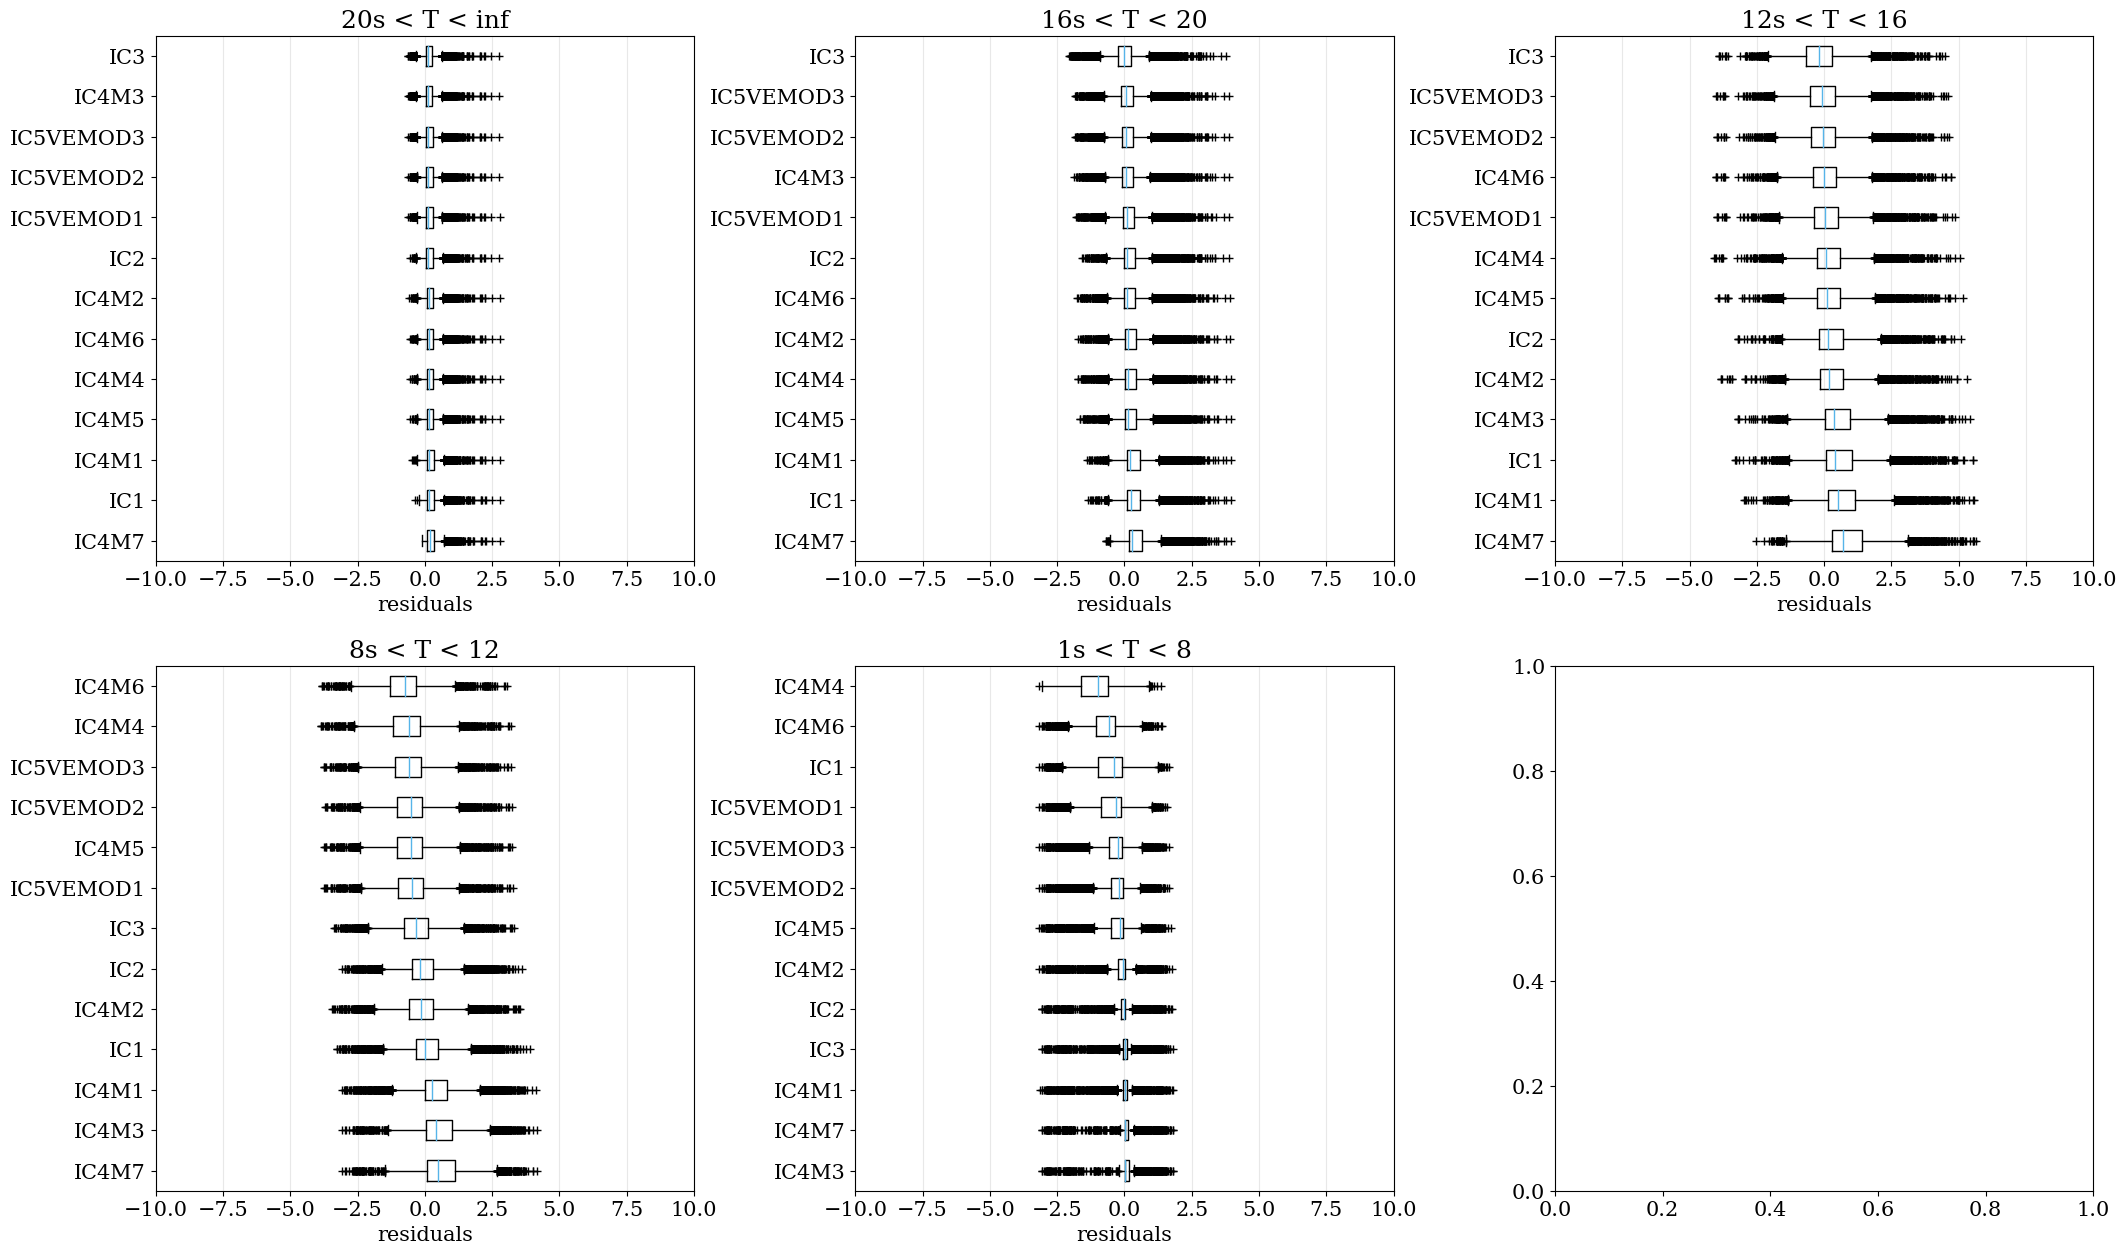

In [52]:
res_boxplot_sub(mp_pwh,bp_pwh)

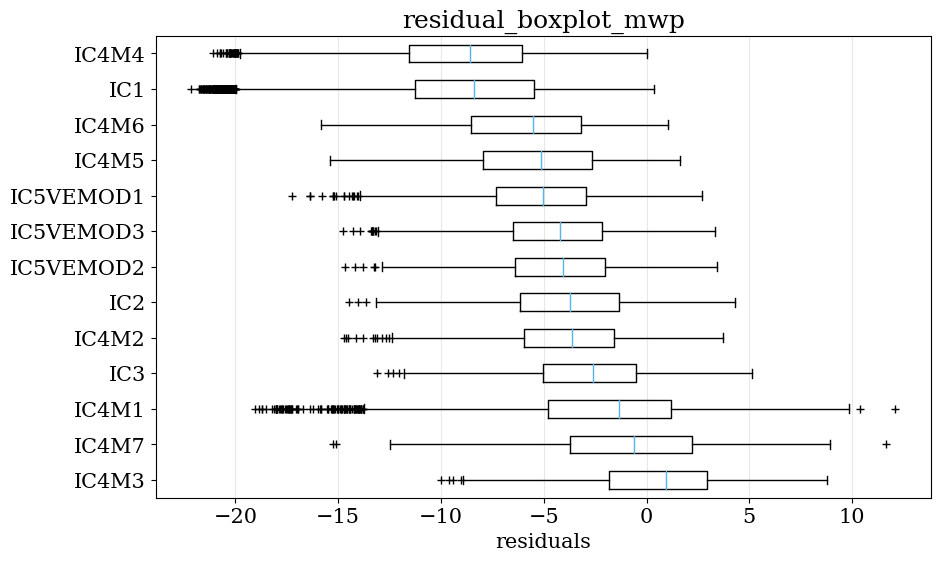

In [53]:
res_mwp = filter_res_mb_mwp(mp_mwp,bp_mwp)
make_res_box_mwp(res_mwp,'residual_boxplot_mwp')

# 2024 Format Scatter and Summary Plots

Newer format, a single scatter plot maker that creates the different plots as one image. This is the one I'd reccommend using.

## Setup for scatter plots

### Integration and Threshold

In [6]:
def f_make_label(key):
    if key[0] != 0:
        sp1 = str(int(1/key[0]))
    else:
        sp1 = "inf"
    if key[1] != 1:
        sp2 = str(int(1/key[1]))
    else:
        sp2 = '0'
    #sl = sp2 + "s < T < " + sp1 + "s : np = " + str(np)
    sl = sp2 + " s < T < " + sp1 + " s"
    return sl

def bm_int_spec_multi(bspec,mspec,split,lat,lon):
    overlap_time_range = slice(bspec.time.min(), mspec.time.max())
    mspec = mspec.sel(time=overlap_time_range)
    mtime = mspec['time']
    ltime = bspec['time']
    
    # interpolate the buoy data to the model time
    bspec = buoy_interp(bspec,mtime)
    bcount = np.array(bspec)
    ice_conc = np.array(bspec.seaice)
    
    # get the coords 
    int_lat = np.interp(mtime, ltime, lat)
    int_lon = np.interp(mtime, ltime, lon)
    #print(" int_lat length is ", len(int_lat))
    #print(" lat length is ", len(lat))
    
    lons_ww3 = np.array(mspec['longitude'])[0,:]
    lats_ww3 = np.array(mspec['latitude'])[0,:]
    if any(np.isnan(lats_ww3)) | any(np.isnan(lons_ww3)):
        #print("Warning: NAN in station coords")
        lons_ww3 = lons_ww3[~np.isnan(lats_ww3)]
        lats_ww3 = lats_ww3[~np.isnan(lats_ww3)]
        lats_ww3 = lats_ww3[~np.isnan(lons_ww3)]
        lons_ww3 = lons_ww3[~np.isnan(lons_ww3)]
    
    
    iw = np.zeros(len(int_lat))
    for i in range(len(int_lat)):
        iw[i] = np.argmin(np.abs(lons_ww3-int_lon[i]) + np.abs(lats_ww3-int_lat[i]))
        #dists= np.sqrt(np.abs(lons_ww3-int_lon[i])**2 + np.abs(lats_ww3-int_lat[i])**2)
        #print( np.min(dists))

    

    # interpolate bspec and mspec to new_freq (must be defined)
    bsp = bspec.interp(frequency=new_freq, kwargs={'fill_value': np.NaN})
    msp = mspec.efth.interp(frequency=new_freq, kwargs={'fill_value': np.NaN})

    nan_mask = bsp.isnull()
    nan_mask_expanded = nan_mask.expand_dims(station=msp.station)
    msp = msp.where(~nan_mask_expanded, np.NaN)
    
    
    # pull out the spectrum from the buoy data
    # THESE NEXT FEW LINES MIGHT NEED TO BE REINTRODUCED IF NEW_FREQ IS NOT USED
    #bs = bsp.interp(frequency=split, kwargs={'fill_value': np.NaN})
    #bs_in = xr.concat([bs, bsp], dim='frequency')
    #bs_int = bs_in.sortby('frequency')
    
    #ms = msp.interp(frequency=split, kwargs={'fill_value': np.NaN})
    #ms_in = xr.concat([ms, msp], dim='frequency')
    #ms_int = ms_in.sortby('frequency')

    # create a mask from bouy data
    # for s in ms_in.station:
    #print(bs_int['frequency'])
    #print(ms_int['frequency'])
        
    #nan_mask_expanded = nan_mask.exp

    # create dicts to store the integrated spectrum
    buoy_data  = {}
    model_data = {}
    buoy_data_div  = {}
    model_data_div = {}

    # fill nans
    #bs_int = bs_int.fillna(0)
    #ms_int = ms_int.fillna(0)
    bs_int = bsp.fillna(0)
    ms_int = msp.fillna(0)
    ms_np = ms_int.values
    bddat = np.array(bs_int)
    bddat = bddat.T
    
    # integrate for partial wave height over different bands (including the full spectrum)
    for i in range(len(split)-1):
        p1 = split[i]
        p2 = split[i+1]
        pair = (p1,p2)
        bsl = bs_int.sel(frequency=slice(p1,p2))
        bsl_ar = np.array(bsl.integrate('frequency') )  
        buoy_data[pair] = bsl_ar
        
        msl = ms_int.sel(frequency=slice(p1,p2))
        msl = np.array(msl.integrate('frequency'))
        eth = np.zeros(len(int_lat))
        # only store the integrated model spectrum at a location and point in time where there is a corrosponding buoy data point
        for i in range(len(int_lat)):
            eth[i] = msl[i,int(iw[i])]
        model_data[pair] = eth
    
    # integrate the denominator for mean wave period
    bsl = bs_int.sel(frequency=slice(0,1))
    bsl = bsl*((bsl.frequency)**2)
    bsl_ar = np.array(bsl.integrate('frequency') )  
    buoy_data_div = bsl_ar
    
    msl = ms_int.sel(frequency=slice(0,1))
    msd = ms_int.sel(frequency=slice(0,1))
    msl = msl*((msl.frequency)**2)
    msl = np.array(msl.integrate('frequency'))
    eth = np.zeros(len(int_lat))
    mddat = []
    
    # only store the integrated model spectrum at a location and point in time where there is a corrosponding buoy data point
    for i in range(len(int_lat)):
        eth[i] = msl[i,int(iw[i])]
        mddat.append(ms_np[i,int(iw[i]),:])
        #print(i)
        #mddat[i] = np.array(msd[i,int(iw[i]),:])
    mddat = np.array(mddat)
    model_data_div = eth

    return mtime, buoy_data, model_data, buoy_data_div, model_data_div, bcount, ice_conc, mddat, bddat


def eliminate_thresh_multi(b_dat,m_dat,b_den, m_den, bcount,mtime,ice_conc,thresh,mddata,bddata):
    bd = np.zeros(len(list(b_dat.values())[0]))
    for key in m_dat:
        bd += np.array(b_dat[key])
    # find the significant wave height
    mo = 4*np.sqrt(bd)
    model_dat = {}
    buoy_dat = {}
    model_den = {}
    buoy_den = {}

    print( "Number of SWH greater then 10cm: ",(mo>thresh).sum())
    # eliminate all the data points where the significant wave height is below thresh for the pwh bands
    for key in m_dat:
        modd = np.delete(m_dat[key],np.where(mo<thresh ),0)
        buoyd = np.delete(b_dat[key],np.where(mo<thresh ),0)
        model_dat[key] = modd
        buoy_dat[key] = buoyd
    
    # eliminate all the data points where the significant wave height is below thresh for the rest of the data
    ice_cc  = np.delete(ice_conc,np.where(mo<thresh),0)    
    ice_out = ice_cc
    mod_den = np.delete(m_den,np.where(mo<thresh),0)
    buoy_den = np.delete(b_den,np.where(mo<thresh),0)
    mdout    =  np.delete(mddata,np.where(mo<thresh),0)
    bdout    =  np.delete(bddata,np.where(mo<thresh),0)
    print('mddata',np.shape(mddata))
    print('mdout',np.shape(mdout))
    model_den = mod_den
    buoy_den = buoy_den
    
    bcount = np.delete(bcount, np.where(mo<thresh ),1)
    mtime = np.delete(mtime, np.where(mo<thresh ),0)
 
    return buoy_dat,model_dat,buoy_den,model_den,bcount,mtime, ice_out, mdout, bdout

### Plot 
***
Note that all of the time plots use the variable mtime that is not passed through to the function. Make sure that the correct times are stored in mtime for the respective plots.

In [7]:
def make_time_plot_swh(ax_p, b_swh, m_swh, model='ALL',buoy='ALL'):
    N = len(b_swh)
    ax2 = ax_p
    p1 = ax2.plot(mtime,b_swh, color="grey",label = "buoy data",linestyle='none',marker='.')
    p2 = ax2.plot(mtime,m_swh, color="lightseagreen",label = "model data",alpha=0.8,linestyle='none',marker='.')
    ax2.grid()
    ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax2.xaxis.get_major_locator()))
    ax2.tick_params(direction='in', length=4, width=1.5, grid_alpha=0.5)
    ax2.set_ylabel("significant wave height",fontsize=30)
    ax2.set_xlabel("time",fontsize=30)
    l = ax2.legend(prop = { "size": 25 }, loc ="upper right",markerscale=5)
    ax2.set_title(model+' vs B'+buoy +' SWH, N = '+str(N),fontsize=30)
    return p1,p2,l

def make_time_plot2_swh(ax_p, points, lab, cl, ll = 'solid', mk=''):
    N = len(points)
    ax2 = ax_p
    p1 = ax2.plot(mtime,points, cl,label = lab, linestyle=ll, marker=mk, linewidth = 3)
    ax2.grid()
    ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax2.xaxis.get_major_locator()))
    ax2.tick_params(direction='in', length=4, width=1.5, grid_alpha=0.5)
    ax2.set_ylabel("significant wave height",fontsize=30)
    ax2.set_xlabel("time",fontsize=30)
    #l = ax2.legend(prop = { "size": 25 }, loc ="upper right",markerscale=5)
    #ax2.set_title(model+' vs B'+buoy +' SWH, N = '+str(N),fontsize=30)
    return p1

def make_time_plot2_mwp(ax_p, points, lab, cl, ll = 'solid', mk=''):
    N = len(points)
    ax2 = ax_p
    p1 = ax2.plot(mtime,points, cl,label = lab, linestyle=ll, marker=mk, linewidth = 3)
    ax2.grid()
    ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax2.xaxis.get_major_locator()))
    ax2.tick_params(direction='in', length=4, width=1.5, grid_alpha=0.5)
    ax2.set_ylabel("mean wave period",fontsize=30)
    ax2.set_xlabel("time",fontsize=30)
    #l = ax2.legend(prop = { "size": 25 }, loc ="upper right",markerscale=5)
    #ax2.set_title(model+' vs B'+buoy +' SWH, N = '+str(N),fontsize=30)
    return p1

def make_time_plot_bias(ax_p, b_swh, m_swh, model='ALL',buoy='ALL'):
    # These use mtime from the calling scope
    N = len(b_swh)
    ax2 = ax_p
    p1 = ax2.plot(mtime,m_swh - b_swh, color="xkcd:merlot",label = "model - buoy data",linestyle='none',marker='.')
    ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax2.xaxis.get_major_locator()))
    ax2.tick_params(direction='in', length=4, width=1.5, grid_alpha=0.5)
    ax2.set_ylabel("significant wave height",fontsize=30)
    ax2.set_xlabel("time",fontsize=30)
    l = ax2.legend(prop = { "size": 25 }, loc ="upper right",markerscale=5)
    ax2.set_title(model+' vs B'+buoy +' bias, N = '+str(N),fontsize=30)
    return p1,l

def make_time_plot_mwp(ax_p,b_mwp, m_mwp,model='ALL',buoy ='ALL'):
    N = len(b_mwp)
    ax1 = ax_p
    p1 = ax1.plot(mtime,b_mwp, color="grey",label = "buoy data",linestyle='none',marker='.')
    p2 = ax1.plot(mtime,m_mwp, color="goldenrod",label = "model data",alpha=0.8,linestyle='none',marker='.')
    ax1.grid()
    ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))
    ax1.tick_params(direction='in', length=4, width=1.5, grid_alpha=0.5)
    ax1.set_ylabel("mean wave period",fontsize=30)
    ax1.set_xlabel("time",fontsize=30)
    l = ax1.legend(prop = { "size": 25 }, loc ="upper right",markerscale=5)
    ax1.set_title(model+' vs B'+buoy +' SWH, N = '+str(N),fontsize=30)
    return p1,p2,l

def make_axes_plot_mwp_multi(ax_p,buoy_dat,model_dat,buoy_den,model_den,mtime,ice_conc,runtim = 0):
    ax = ax_p
    ax.plot([-1,50], [-1,50], color="grey",linestyle="solid")
    ax.set_prop_cycle(ice_cycler)
    bd_num = np.zeros(len(list(model_dat.values())[0]))
    md_num = np.zeros(len(list(model_dat.values())[0]))
    bd_div = np.zeros(len(model_den))
    md_div = np.zeros(len(model_den))
    pears = {}
    mout = {}
    bout = {}
    for key in reversed(model_dat):
        bd_num += np.array(buoy_dat[key])
        md_num += np.array(model_dat[key])#*np.pi/180
    bd_div = np.array(buoy_den)
    md_div = np.array(model_den)#*np.pi/180
        
    bd = np.sqrt(bd_num/bd_div)
    md = np.sqrt(md_num/md_div)
    mout[(0,1)] = md
    bout[(0,1)] = bd
    
    indices = ~(np.logical_or(np.isinf(bd), np.isinf(md)))     
    indices = np.array(indices)
    bd_if = bd[indices]
    md_if = md[indices]
    
    indices = ~(np.logical_or(np.isnan(bd_if), np.isnan(md_if)))     
    indices = np.array(indices)
    bd_f = bd_if[indices]
    md_f = md_if[indices]

    for i in range(len(c_split)-1):
        c0 = c_split[i]
        c1 = c_split[i+1]
        
        pair = (c0,c1)
        
        lab = str(round(c0*100))+'% to '+str(round(c1*100)) +'%'
        bd_ic = np.zeros(len(list(model_dat.values())[0]))
        md_ic = np.zeros(len(list(model_dat.values())[0]))
        ice_ind = np.where(np.logical_and(ice_conc>c0,ice_conc<c1))[0]
        bd_ic = bd[ice_ind]
        md_ic = md[ice_ind]
        
        
        ax.plot(bd_ic, md_ic,label = lab, zorder=0,mew=1,alpha=0.5)
    
    if buoy == 0:
        ax.legend(prop = { "size": 18 }, loc ="upper left",markerscale=5,title='ice concentration')
    
    ax.grid()
    ax.tick_params(direction='in', length=4, width=1.5, grid_alpha=0.5)
    ax.set_ylabel("model",fontsize=20)
    ax.set_xlabel("observation",fontsize=20)
    #ax.set_xlim([-0.005,0.25])
    #ax.set_ylim([-0.005,0.25])
    ax.set_xlim([0,30])
    ax.set_ylim([0,30])
    ax.set_title('Mean Wave Period Comparison',fontsize=20)
    
    return bout, mout

def make_axes_plot_pwh_multi(ax_p,bouy_dat,model_dat,mtime,runtim = 0):
    ax = ax_p
    ax.plot([-1,10], [-1,10], color="grey",linestyle="solid")
    ax.set_prop_cycle(scatter_cycler)
    bd = np.zeros(len(list(model_dat.values())[0]))
    md = np.zeros(len(list(model_dat.values())[0]))
    pears = {}
    mout = {}
    bout = {}
    for key in reversed(model_dat):
        bd += np.array(bouy_dat[key])
        md += np.array(model_dat[key])#*np.pi/180
        bdat = np.copy(bouy_dat[key])
        mdat = np.copy(model_dat[key])#*np.pi/180
        mdat = np.delete(mdat,np.where(bdat==0),0)
        bdat = np.delete(bdat,np.where(bdat==0),0)
        
        pr = np.NaN
        #print(inds)
        #bdat = bdat[inds]
        #mdat = mdat[inds]
        if (np.count_nonzero(bdat)>1) & (len(bdat)==len(mdat)):
            sl = f_make_label(key)
            #ax.plot(bdat, mdat, label = sl, alpha = 0.5)
            ax.loglog(4*np.sqrt(bdat), 4*np.sqrt(mdat), label = sl,mew=0.5,alpha=0.5)
            pr = pearsonr(4*np.sqrt(bdat),4*np.sqrt(mdat))
        else:
            print(bdat)
            print(mdat)
        pears[key] = [pr,len(bdat)]
        mout[key] = 4*np.sqrt(mdat)
        bout[key] = 4*np.sqrt(bdat)
        
    bd = 4*np.sqrt(bd)
    md = 4*np.sqrt(md)
    if (np.count_nonzero(bd)>1) & (len(bd)==len(md)):
        pears[(0,1)] = [pearsonr(bd,md),len(bd)]
    else:
        pears[(0,1)] = [np.NaN,len(bd)]
        print(bd)
        print(md)
    mout[(0,1)] = md
    bout[(0,1)] = bd
    
    #ax.plot(bd, md, color="rosybrown", label = 'Total', zorder=0)
    #ax.loglog(bd, md, color="black",label = '0 s < T < inf s', zorder=0,mew=0.5)
    
    if buoy ==0:
        ax.legend(prop = { "size": 18 }, loc ="upper left",markerscale=5, title='integrated period')
    #plt.plot([-1,1], [-1,1], color="grey",linestyle="solid", alpha = 0.4)
    ax.grid()
    ax.tick_params(direction='in', length=4, width=1.5, grid_alpha=0.5)
    ax.set_ylabel("model",fontsize=20)
    ax.set_xlabel("observation",fontsize=20)
    #ax.set_xlim([-0.005,0.25])
    #ax.set_ylim([-0.005,0.25])
    ax.set_xlim([1e-4,10])
    ax.set_ylim([1e-4,10])
    ax.set_title('Partial Wave Height Comparison',fontsize=20)
    
    
    return bout, mout

def make_axes_plot_swh_mwp_multi(ax_p,bouy_dat,model_dat,mtime,mwp,runtim = 0):
    ax = ax_p
    ax.plot([-1,10], [-1,10], color="grey",linestyle="solid")
    ax.set_prop_cycle(scatter_cycler)
    bd = np.zeros(len(list(model_dat.values())[0]))
    md = np.zeros(len(list(model_dat.values())[0]))

    #pears = {}
    
    #sum all the partial spectrum integrals to get the full integral
    for key in reversed(model_dat):
        bd += np.array(bouy_dat[key])
        md += np.array(model_dat[key])#*np.pi/180

    bd = 4*np.sqrt(bd)
    md = 4*np.sqrt(md)
    bout = {}
    mout = {}
    
    for i in range(len(t_split)-1):
        c0 = t_split[i]
        c1 = t_split[i+1]
        
        pair = (c0,c1)
        
        lab = str(c0) + " s < T < " + str(c1) + " s" 
        bd_ic = np.zeros(len(list(model_dat.values())[0]))
        md_ic = np.zeros(len(list(model_dat.values())[0]))
        mwp_ind = np.where(np.logical_and(mwp>c0,mwp<c1))[0]
        bd_ic = bd[mwp_ind]
        md_ic = md[mwp_ind]
        
        #bout[pair] = bd_ic
        #mout[pair] = md_ic
        
        #if len(bd_ic)>2 and len(md_ic)>2:
            #pears[pair] = pearsonr(bd_ic,md_ic)
        #else:
            #pears[pair] = np.nan
        
        
        ax.loglog(bd_ic, md_ic,label = lab, zorder=0,mew=1,alpha=0.5)
        
        
    if buoy == 0:
        ax.legend(prop = { "size": 18 }, loc ="upper left",markerscale=5,title='mean wave period')
    
    ax.grid()
    ax.tick_params(direction='in', length=4, width=1.5, grid_alpha=0.5)
    ax.set_ylabel("model",fontsize=20)
    ax.set_xlabel("observation",fontsize=20)
    #ax.set_xlim([-0.005,0.25])
    #ax.set_ylim([-0.005,0.25])
    ax.set_xlim([1e-3,10])
    ax.set_ylim([1e-3,10])
    ax.set_title('Significant Wave Height Comparison',fontsize=20)
    
    return bd, md

def make_axes_plot_swh_ice_multi(ax_p,bouy_dat,model_dat,mtime,ice_conc,runtim = 0):
    ax = ax_p
    ax.plot([-1,10], [-1,10], color="grey",linestyle="solid")
    ax.set_prop_cycle(ice_cycler)
    bd = np.zeros(len(list(model_dat.values())[0]))
    md = np.zeros(len(list(model_dat.values())[0]))

    #pears = {}
    
    #sum all the partial spectrum integrals to get the full integral
    for key in reversed(model_dat):
        bd += np.array(bouy_dat[key])
        md += np.array(model_dat[key])#*np.pi/180

    bd = 4*np.sqrt(bd)
    md = 4*np.sqrt(md)
    bout = {}
    mout = {}
    
    for i in range(len(c_split)-1):
        c0 = c_split[i]
        c1 = c_split[i+1]
        
        pair = (c0,c1)
        
        lab = str(round(100*c0))+'% to '+str(round(100*c1))+'%'
        bd_ic = np.zeros(len(list(model_dat.values())[0]))
        md_ic = np.zeros(len(list(model_dat.values())[0]))
        ice_ind = np.where(np.logical_and(ice_conc>c0,ice_conc<c1))[0]
        bd_ic = bd[ice_ind]
        md_ic = md[ice_ind]
        
        #bout[pair] = bd_ic
        #mout[pair] = md_ic
        
        #if len(bd_ic)>2 and len(md_ic)>2:
            #pears[pair] = pearsonr(bd_ic,md_ic)
        #else:
            #pears[pair] = np.nan
        
        
        ax.loglog(bd_ic, md_ic,label = lab, zorder=0,mew=1,alpha=0.5)
        
        
    if buoy == 0:
        ax.legend(prop = { "size": 18 }, loc ="upper left",markerscale=5,title='ice concentration')
    
    ax.grid()
    ax.tick_params(direction='in', length=4, width=1.5, grid_alpha=0.5)
    ax.set_ylabel("model",fontsize=2)
    ax.set_xlabel("observation",fontsize=20)
    #ax.set_xlim([-0.005,0.25])
    #ax.set_ylim([-0.005,0.25])
    ax.set_xlim([1e-3,10])
    ax.set_ylim([1e-3,10])
    ax.set_title('Significant Wave Height Comparison',fontsize=20)
    
    return bd, md

### Final Setup

In [8]:
freq = np.array(data_in['freq'][:,0])
file_names = os.listdir(ddir)

# set the splits for frequency and ice concentration
p_split = [0,1/20,1/16,1/12,1/8,1]
c_split = [0,0.6,0.7,0.8,0.9,1]

# set the split for period, should corrospond to the frequency split, this one is just for nicer labels
t_split = [0,8,12,16,20,np.inf]

# these are how you tell the scatter plot maker which models to use
filtered_files = ['rIC1.nc',
 'rIC5VEMOD3.nc',
 'rIC5VEMOD2.nc',
 'rIC5VEMOD1.nc',
 'rIC4M7.nc',
 'rIC4M6.nc',
 'rIC4M5.nc',
 'rIC4M4.nc',
 'rIC4M3.nc',
 'rIC4M2.nc',
 'rIC4M1.nc',
 'rIC3.nc',
 'rIC2.nc',
 'rIC0.nc',
 'rno_ice.nc']

#filtered_files = [ 'rno_ice.nc']
#filtered_files = ['IC4M2.nc','IC3.nc','IC2.nc','IC5VEMOD2.nc']
#filtered_files = ['IC1.nc']

# these numbered ones are convinient to check changes with a shorter runtime
#filtered_files2 = ['IC5VEMOD2.nc']
#filtered_files3 = ['IC4M7.nc']

### For checks and debugging

In [9]:
fn = 'IC5VEMOD2.nc'
fn = 'rIC0.nc'
model_data = read_models(ddir+fn)
period_range = np.linspace(3,29,(29-3)*2+1)
new_freq =np.flip(np.array([1/a for a in period_range]))


In [13]:
model_data['time']

<xarray.DataArray 'time' (time: 2209)>
array(['2017-05-01T00:00:00.000000000', '2017-05-01T01:00:00.000000000',
       '2017-05-01T02:00:00.000000000', ..., '2017-07-31T22:00:00.000000000',
       '2017-07-31T23:00:00.000000000', '2017-08-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-05-01 2017-05-01T01:00:00 ... 2017-08-01
Attributes:
    long_name:      julian day (UT)
    standard_name:  time
    conventions:    Relative julian days with decimal part (as parts of the day)
    axis:           T

model_data

In [14]:
period_range = np.linspace(3,29,(29-3)*2+1)
new_freq =np.flip(np.array([1/a for a in period_range]))
new_freq
bnum = 1
buoy = 0
lons = d_sorted[buoy][2]
lats = d_sorted[buoy][1]
l_inds = d_sorted[buoy][4]
buoy_data = d_sorted[buoy][3]
time_64 = buoy_data[buoy][0]

In [15]:
print('Buoy data  is :\n',buoy_data['frequency'])
print('Model data is :\n',model_data['frequency'])
overlap_time_range = slice(buoy_data.time.min(), buoy_data.time.max())
model_data = model_data.sel(time=overlap_time_range)
mtime = model_data['time']
ltime = buoy_data['time']
print('Length of sea-ice ',len(np.array(buoy_data.seaice)))
# interpolate the buoy data to the model time
bspec = buoy_interp(buoy_data,mtime)
bcount = np.array(bspec)
ice_conc = np.array(bspec.seaice)
print('Length of sea-ice after time interp',len(np.array(bspec.seaice)))
print
msp_pre = model_data.efth
bsp = bspec.interp(frequency=new_freq, kwargs={'fill_value': np.NaN})
msp = model_data.efth.interp(frequency=new_freq, kwargs={'fill_value': np.NaN})
print('******\n')
print('Buoy data  is :\n',bsp['frequency'])
print('Model data is :\n',msp['frequency'])

Buoy data  is :
 <xarray.DataArray 'frequency' (frequency: 55)>
array([0.03125 , 0.035156, 0.039062, 0.042969, 0.046875, 0.050781, 0.054688,
       0.058594, 0.0625  , 0.066406, 0.070312, 0.074219, 0.078125, 0.082031,
       0.085938, 0.089844, 0.09375 , 0.097656, 0.101562, 0.105469, 0.109375,
       0.113281, 0.117188, 0.121094, 0.125   , 0.128906, 0.132812, 0.136719,
       0.140625, 0.144531, 0.148438, 0.152344, 0.15625 , 0.160156, 0.164062,
       0.167969, 0.171875, 0.175781, 0.179688, 0.183594, 0.195312, 0.207031,
       0.21875 , 0.230469, 0.242188, 0.253906, 0.273438, 0.292969, 0.3125  ,
       0.339844, 0.367188, 0.394531, 0.421875, 0.449219, 0.476562])
Coordinates:
  * frequency  (frequency) float64 0.03125 0.03516 0.03906 ... 0.4492 0.4766
Model data is :
 <xarray.DataArray 'frequency' (frequency: 33)>
array([0.034   , 0.0374  , 0.04114 , 0.045254, 0.049779, 0.054757, 0.060233,
       0.066256, 0.072882, 0.08017 , 0.088187, 0.097006, 0.106707, 0.117377,
       0.129115, 0.14

In [16]:
#np.array(msp.isel(station=1000)[1,:])
msp10 = msp.isel(station=500)
np.max(msp10.values[:,:])

0.0

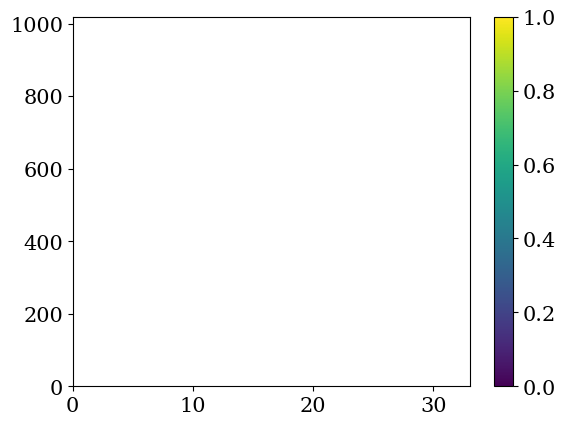

In [17]:
mpp = np.array(msp_pre.values[:,500,:])
mpp[mpp == 0] = np.nan
plt.pcolor(mpp)
plt.colorbar()

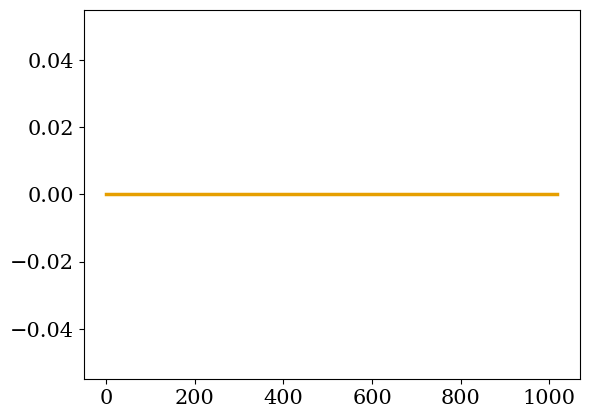

In [18]:
msp_pre_10 = msp_pre.isel(station=500)
int_mppre = np.array(msp_pre_10.integrate('frequency'))
swhpre = 4*np.sqrt(int_mppre#*np.pi/180)
plt.plot(swhpre)

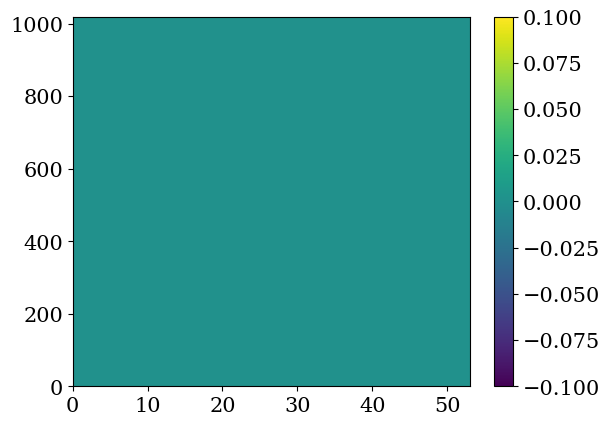

In [19]:
plt.pcolor(msp10.values[:,:])
plt.colorbar()

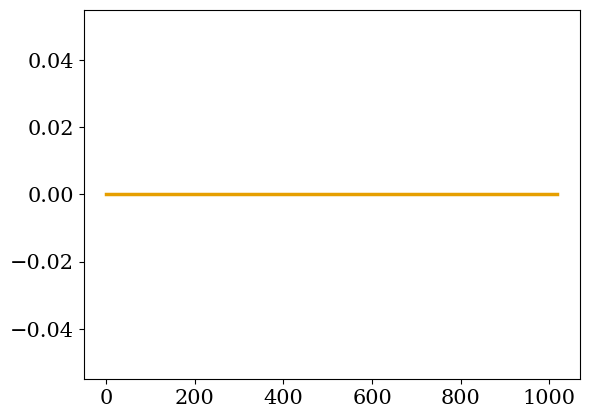

In [20]:
int_mp10 = np.array(msp10.integrate('frequency'))
swh10 = 4*np.sqrt(int_mp10)
plt.plot(swh10)

In [21]:
np.nanmin(mpp)
np.size(mpp)
dfs = new_freq[1:]-new_freq[:-1]
print(dfs)
print(np.shape(dfs))
print(np.shape(mpp))

[0.00060496 0.00062657 0.00064935 0.0006734  0.00069881 0.00072569
 0.00075415 0.00078431 0.00081633 0.00085034 0.00088652 0.00092507
 0.00096618 0.0010101  0.00105708 0.00110742 0.00116144 0.00121951
 0.00128205 0.00134953 0.00142248 0.0015015  0.0015873  0.00168067
 0.00178253 0.00189394 0.00201613 0.00215054 0.00229885 0.00246305
 0.0026455  0.002849   0.00307692 0.00333333 0.00362319 0.00395257
 0.004329   0.0047619  0.00526316 0.00584795 0.00653595 0.00735294
 0.00833333 0.00952381 0.01098901 0.01282051 0.01515152 0.01818182
 0.02222222 0.02777778 0.03571429 0.04761905]
(52,)
(1019, 33)


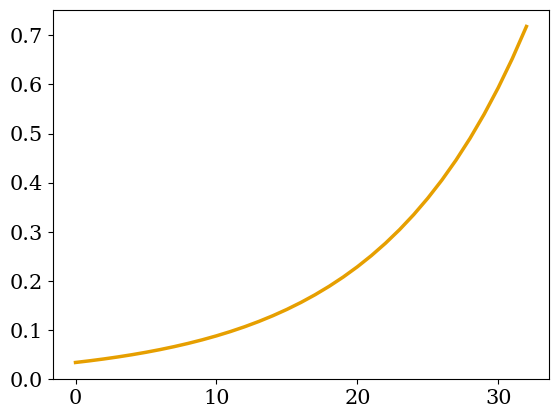

In [22]:
plt.plot(msp_pre['frequency'])

(53, 1019)


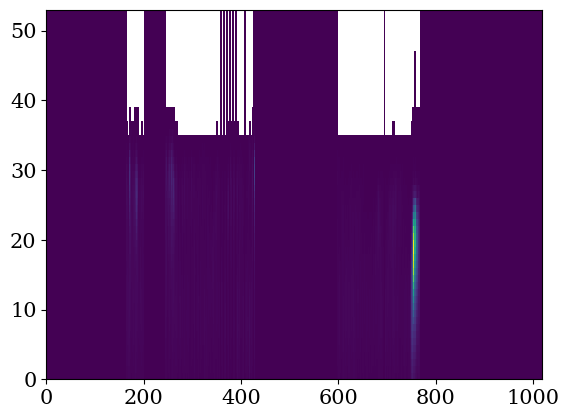

In [24]:
plt.pcolor(bsp)
print(np.shape(bsp))

In [25]:
nan_mask = bsp.isnull()
print(np.shape(nan_mask))
nan_mask_expanded = nan_mask.expand_dims(station=msp.station)
ms_in = msp.where(~nan_mask_expanded, np.nan)

(53, 1019)


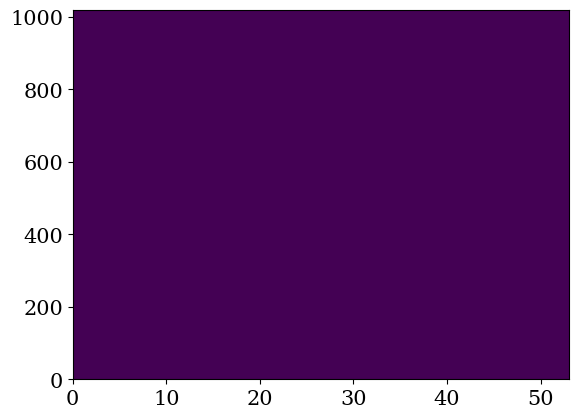

In [26]:
ms_in = ms_in.fillna(0)
plt.pcolor(ms_in.isel(station=1000))

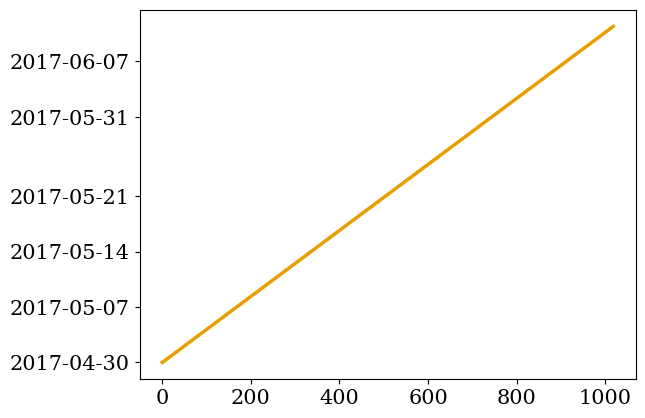

In [27]:
plt.plot(msp['time'])

## Scatter plots

In [ ]:
# scatter plot maker
# makes scatter plots of buoy data vs model data, and store that data for later plots and analysis
period_range = np.linspace(3,29,(29-3)*2+1)
new_freq =np.flip(np.array([1/a for a in period_range]))

# models to use for this run
models = filtered_files

# create dicts for storage of all the data
mpoints = {}
bpoints = {}

if not os.path.exists("./results/"):
    os.makedirs("./results/")

bd = "./results/"

#setup figure timeplots
sel_buoy = [0,5,9]
plot_list = ['IC2','IC3','IC4M2','IC5VEMOD2']
figs = []
axs  = []
figm = []
axm  = []
for i in range(len(sel_buoy)):
    fig_2s, ax_2s = plt.subplots(1, 1, figsize=(24, 12))
    fig_2m, ax_2m = plt.subplots(1, 1, figsize=(24, 12))
    figs.append(fig_2s)
    figm.append(fig_2m)
    axs.append(ax_2s)
    axm.append(ax_2m)

f2c = [bcyc_list[8],bcyc_list[14],bcyc_list[17],bcyc_list[25]]
frst = True
for fn in models:
    # get the model name out of the file name
    fns = fn.split('.')
    fns[0] = fns[0][1:]
    if frst:
        fn_init = fns[0]
        frst = False
    print("... working on ",fns[0],"...")
    bdr = bd+fns[0]+"/"
    if fns[0] in plot_list:
        chck_m2 = True
        f2c_p = plot_list.index(fns[0])
    else:
        chck_m2 = False
    
    if not os.path.exists(bdr):
        os.makedirs(bdr)
        
    # setup the scatterplots
    fig_pwh, ax_pwh = plt.subplots(1, 1, figsize=(12, 12))
    fig_pwh.suptitle(fns[0],size='xx-large')
    fig_swh_m, ax_swh_m = plt.subplots(1, 1, figsize=(12, 12))
    fig_swh_m.suptitle(fns[0],size='xx-large')
    fig_mwp, ax_mwp = plt.subplots(1, 1, figsize=(12, 12))
    fig_mwp.suptitle(fns[0],size='xx-large')
    fig_swh_c, ax_swh_c = plt.subplots(1, 1, figsize=(12, 12))
    fig_swh_c.suptitle(fns[0],size='xx-large')
    
    #setup the timeplots
    fig_tswh, ax_tswh = plt.subplots(1, 1, figsize=(24, 12))
    fig_tswh.suptitle(fns[0],size='xx-large')
    fig_tmwp, ax_tmwp = plt.subplots(1, 1, figsize=(24, 12))
    fig_tmwp.suptitle(fns[0],size='xx-large')
    fig_tbias, ax_tbias = plt.subplots(1, 1, figsize=(24, 12))
    fig_tbias.suptitle(fns[0],size='xx-large')



    
    
    sname_base = bdr + fns[0] + "_scatter_koz"
    tname_base = bdr + fns[0] + "_time_koz"
    bname = ddir+fn
    
    # create dicts to store final data for this model
    mp_out = {}
    bp_out = {}
    
    # create arrays to store integrated spectrum and concentration data
    bp_st_mwp = []
    bp_st_swh = []
    bp_st_pwh = []
    bp_st_ice = []
    mp_st_mwp = []
    mp_st_swh = []
    mp_st_pwh = []

    # an equivalent for storing all the different times
    st_time = np.datetime64()
    
    # get data for the current model
    model_data = read_models(bname)#.isel(string40=0)
    data_out = {}
    for buoy in range(len(d_sorted)):
#    for buoy in [3]:
        # which buoys to use for this run
        chck_b2 = False
        if chck_m2:
            if buoy in sel_buoy:
                chck_b2 = True
                bp2 = sel_buoy.index(buoy)
          
            

        
        if buoy < len(d_sorted):
            
            bt = "Buoy"+str(buoy+1)
            print("working on",bt)
            
            # extract the data for this buoy
            lons = d_sorted[buoy][2]
            lats = d_sorted[buoy][1]
            l_inds = d_sorted[buoy][4]
            buoy_data = d_sorted[buoy][3]
            time_64 = buoy_data[buoy][0]
            
            
            # interpolate data to model time and integrate the buoy and model spectrums for calculation of mwp and swh
            print("starting integration")
            mtime, obs_dat, mod_dat, obs_div, mod_div, bcount,ice_dat, md_data, bd_data = bm_int_spec_multi(buoy_data,model_data,p_split,lats[l_inds],lons[l_inds])
            print("integration done")
            print('buoy data shape:',np.shape(bd_data))
            print('model data shape:',np.shape(md_data))
            obs_d,mod_d,obs_mwpd,mod_mwpd,bcount,mtime, ice_c,md_data,bd_data = eliminate_thresh_multi(obs_dat,mod_dat,obs_div,mod_div,bcount,mtime,ice_dat,0.1,md_data,bd_data)
            print("threshold done")
            print('buoy shape',np.shape(bd_data))
            print('model shape',np.shape(md_data))
        
            data_out[bt] = { "b_data": bd_data, "m_data": md_data, "time": mtime, "seaice":ice_c, "freq":new_freq }   

            # store the time for the final plots
            st_time = np.append(st_time,mtime)
            
            # create the four scatterplots
            bp_swh, mp_swh = make_axes_plot_swh_ice_multi(ax_swh_c,obs_d,mod_d,mtime,ice_c)
            bp_mwp, mp_mwp = make_axes_plot_mwp_multi(ax_mwp,obs_d,mod_d,obs_mwpd,mod_mwpd,mtime,ice_c)
            bp_pwh, mp_pwh = make_axes_plot_pwh_multi(ax_pwh,obs_d,mod_d,mtime)
            make_axes_plot_swh_mwp_multi(ax_swh_m,obs_d,mod_d,mtime,bp_mwp[0,1])

            
            # create the three time plots
            make_time_plot_mwp(ax_tmwp,bp_mwp[0,1],mp_mwp[0,1],fns[0],str(buoy))
            make_time_plot_swh(ax_tswh,bp_swh,mp_swh,fns[0],str(buoy))
            make_time_plot_bias(ax_tbias,bp_swh,mp_swh,fns[0],str(buoy))

            # time plots paper figure 2
            if chck_b2:
                ax_2s = axs[bp2]
                ax_2m = axm[bp2]
                if buoy == 0:
                    make_time_plot2_swh(ax_2s, bp_swh, 'buoy data', 'dimgrey', 'dashed')
                    make_time_plot2_mwp(ax_2m, bp_mwp[0,1], 'buoy data', 'dimgrey', 'dashed')
                make_time_plot2_swh(ax_2s, mp_swh, fns[0], f2c[f2c_p])
                make_time_plot2_mwp(ax_2m, mp_mwp[0,1], fns[0], f2c[f2c_p])
 
                

            # save time plots figures
            fig_tswh.savefig(tname_base+'_B'+str(buoy+1)+'_swh.png',dpi=200)
            fig_tmwp.savefig(tname_base+'_B'+str(buoy+1)+'_mwp.png',dpi=200)
            fig_tbias.savefig(tname_base+'_B'+str(buoy+1)+'_bias.png',dpi=200)
           
            # store the data for the current buoy
            bp_st_mwp = np.append(bp_st_mwp,bp_mwp[0,1])
            bp_st_pwh = np.append(bp_st_pwh,bp_pwh)
            bp_st_ice = np.append(bp_st_ice,ice_c)
            bp_st_swh = np.append(bp_st_swh,bp_swh)
            mp_st_mwp = np.append(mp_st_mwp,mp_mwp[0,1])
            mp_st_pwh = np.append(mp_st_pwh,mp_pwh)
            mp_st_swh = np.append(mp_st_swh,mp_swh)

            # delete points and legend in figures
            ax_tswh.cla()
            ax_tmwp.cla()
            ax_tbias.cla()
            
    # store the data for the current model
    bp_out['mwp'] = bp_st_mwp
    bp_out['swh'] = bp_st_swh
    bp_out['ice'] = bp_st_ice
    bp_out['pwh'] = bp_st_pwh[0]
    bpoints[fns[0]] = bp_out
            
    mp_out['mwp'] = mp_st_mwp
    mp_out['pwh'] = mp_st_pwh[0]
    mp_out['swh'] = mp_st_swh
    mpoints[fns[0]] = mp_out
            
    fig_pwh.savefig(sname_base+'_pwh.png',dpi=200)
    if ax_pwh.get_legend():
        ax_pwh.get_legend().set_visible(False)
    fig_pwh.savefig(sname_base+'_nl_pwh.png',dpi=200)
    
    fig_mwp.savefig(sname_base+'_mwp.png',dpi=200)
    if ax_mwp.get_legend():
        ax_mwp.get_legend().set_visible(False)
    fig_mwp.savefig(sname_base+'_nl_mwp.png',dpi=200)
    
    fig_swh_m.savefig(sname_base+'_swh_m.png',dpi=200)
    if ax_swh_m.get_legend():
        ax_swh_m.get_legend().set_visible(False)
    fig_swh_m.savefig(sname_base+'_nl_swh_m.png',dpi=200)
    
    fig_swh_c.savefig(sname_base+'_swh_c.png',dpi=200)
    if ax_swh_c.get_legend():
        ax_swh_c.get_legend().set_visible(False)
    fig_swh_c.savefig(sname_base+'_nl_swh_c.png',dpi=200)
    
    # create the three time plots -> adjust the mtime variable
    mtime = st_time[1:]
    make_time_plot_mwp(ax_tmwp,bp_st_mwp,mp_st_mwp,fns[0])
    make_time_plot_swh(ax_tswh,bp_st_swh,mp_st_swh,fns[0])
    make_time_plot_bias(ax_tbias,bp_st_swh,mp_st_swh,fns[0])
  
    fig_tbias.savefig(tname_base+'_bias.png',dpi = 200)
    io.savemat(fns[0]+"_data.mat", data_out)

    with open(bd+'model_pm_'+fn_init+'to'+fns[0]+'.pkl', 'wb') as f:
        pickle.dump(mpoints, f)
    with open(bd+'buoy_pm_'+fn_init+'to'+fns[0]+'.pkl', 'wb') as f:
        pickle.dump(bpoints, f)


for i in range(len(sel_buoy)):
    fig = figs[i]
    ax = axs[i]
    fig.savefig(tname_base+'_B'+str(i)+'_nl_swh.png',dpi=200)            
    ax.legend(prop = { "size": 18 }, loc ="upper left")
    fig.savefig(tname_base+'_B'+str(i)+'_swh.png',dpi=200)

    fig = figm[i]
    ax = axm[i]
    fig.savefig(tname_base+'_B'+str(i)+'_nl_mwp.png',dpi=200)            
    ax.legend(prop = { "size": 18 }, loc ="upper left")
    fig.savefig(tname_base+'_B'+str(i)+'_mwp.png',dpi=200)

... working on  IC1 ...
working on Buoy1
starting integration
integration done
buoy data shape: (2445, 53)
model data shape: (2445, 53)
Number of SWH greater then 10cm:  234
mddata (2445, 53)
mdout (234, 53)
threshold done
buoy shape (234, 53)
model shape (234, 53)
working on Buoy2
starting integration
integration done
buoy data shape: (2438, 53)
model data shape: (2438, 53)
Number of SWH greater then 10cm:  253
mddata (2438, 53)
mdout (253, 53)
threshold done
buoy shape (253, 53)
model shape (253, 53)
working on Buoy3
starting integration
integration done
buoy data shape: (2432, 53)
model data shape: (2432, 53)
Number of SWH greater then 10cm:  89
mddata (2432, 53)
mdout (89, 53)
threshold done
buoy shape (89, 53)
model shape (89, 53)
working on Buoy4
starting integration
integration done
buoy data shape: (2423, 53)
model data shape: (2423, 53)
Number of SWH greater then 10cm:  78
mddata (2423, 53)
mdout (78, 53)
threshold done
buoy shape (78, 53)
model shape (78, 53)
working on Buoy5

In [38]:
# save the data to use in the summary plots later
with open('model_points_multi.pkl', 'wb') as f:
    pickle.dump(mpoints, f)
with open('buoy_points_multi.pkl', 'wb') as f:
    pickle.dump(bpoints, f)

## Summary Plots

### Summary Setup

In [13]:
# convert the list of file names from filtered_files to a list of model names, eg IC1.nc -> IC1
filtered_names = ['1']*len(filtered_files)
for i in range(len(filtered_names)):
    fn = filtered_files[i]
    fns = fn.split('.')
    filtered_names[i] = fns[0][1:]

# convert the boundries from the splits to a list of tuples, eg [0,0.5,0.6...] -> [(0,0.5),(0.5,0.6)...]
p_splits = list(range(len(p_split)))
for i in range(len(p_split)-1):
    p0 = p_split[i]
    p1 = p_split[i+1]
    p_splits[i+1] = (p0,p1)
p_splits[0] = (0,1)
c_splits = list(range(len(c_split)-1))
for i in range(len(c_split)-1):
    p0 = c_split[i]
    p1 = c_split[i+1]
    c_splits[i] = (p0,p1)

t_splits2 = list(range(len(t_split)-1))
for i in range(len(t_split)-1):
    p0 = t_split[i]
    p1 = t_split[i+1]
    t_splits2[i] = (p0,p1)

# set some other splits to use in the summary plots
t_splits = [(0,np.inf),(0,10),(10,12),(12,16),(16,20),(20,np.inf)]

c4_splits = [(0,1),(0,0.65),(0.65,0.85),(0.85,1)]
t4_splits = [(0,np.inf),(0,12),(12,16),(16,np.inf)]

c41_splits = [(0,0.65),(0.65,0.85),(0.85,1)]
t41_splits = [(0,12),(12,16),(16,np.inf)]

c42_splits = [(0,1)]
t42_splits = [(0,np.inf)]

c3_splits = [(0,0.75),(0.75,0.85),(0.85,1)]
t3_splits = [(0,12),(12,16),(16,np.inf)]

In [14]:
bd = "./results/"
# load the data from the scatter plots
with open(bd+'model_pm_IC1tono_ice.pkl', 'rb') as f:
    m_pts = pickle.load(f)
    
with open(bd+'buoy_pm_IC1tono_ice.pkl', 'rb') as f:
    b_pts = pickle.load(f)

In [15]:
ice_sub_50 = [0]*len(filtered_names)
for i in range(len(filtered_names)):
    model = filtered_names[i]
    ice = b_pts[model]['ice']
    ice_sub_50[i] = len(np.where(ice<0.5)[0])
ice_sub_50

[203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203]

In [16]:
# for a given ice conc band, calculate the pearson coefficeints and confidence intervals for mwp
def filter_cor_mwp_by_ice(bp,mp,split):
    c0 = split[0]
    c1 = split[1]

    cor_pt = [0]*len(filtered_names)
    cor_ci = [0]*len(filtered_names)
    for model in range(len(filtered_names)):
        fn = filtered_names[model]
        bp_fn_nans = bp[fn]['mwp']
        mp_fn_nans = mp[fn]['mwp']

        no_nan_inds = np.where(~np.isnan(mp_fn_nans))[0]
        bp_fn = bp_fn_nans[no_nan_inds]
        mp_fn = mp_fn_nans[no_nan_inds]
        ice_no_nans = bp[fn]['ice'][no_nan_inds]


        ice_ind = np.array(np.where(np.logical_and(ice_no_nans>c0,ice_no_nans<c1))[0])
        bp_fn_ice = bp_fn[ice_ind]
        mp_fn_ice = mp_fn[ice_ind]

        pears = pearsonr(bp_fn_ice,mp_fn_ice)

        cor_pt[model] = pears.statistic
        lower = pears.confidence_interval().low
        upper = pears.confidence_interval().high
        cor_ci[model] = [lower,upper]
    cor_ci_out = cor_ci
    
        
    return cor_pt, cor_ci_out

In [17]:
# for a given ice conc band, calculate the pearson coefficeints and confidence intervals for swh
def filter_cor_ice(bp,mp,split):
    c0 = split[0]
    c1 = split[1]

    cor_pt = [0]*len(filtered_names)
    cor_ci = [0]*len(filtered_names)
    for model in range(len(filtered_names)):
        fn = filtered_names[model]
        bp_fn = bp[fn]['swh']
        mp_fn = mp[fn]['swh']

        ice_ind = np.array(np.where(np.logical_and(bp[fn]['ice']>c0,bp[fn]['ice']<c1))[0])
        bp_fn_ice = bp_fn[ice_ind]
        mp_fn_ice = mp_fn[ice_ind]

        pears = pearsonr(bp_fn_ice,mp_fn_ice)

        cor_pt[model] = pears.statistic
        lower = pears.confidence_interval().low
        upper = pears.confidence_interval().high
        cor_ci[model] = [lower,upper]
    cor_ci_out = cor_ci
    
    return cor_pt, cor_ci_out

In [18]:
# for a given mwp band, calculate the pearson coefficeints and confidence intervals for swh
def filter_cor_period(bp,mp,split):
    p0 = split[0]
    p1 = split[1]

    cor_pt = [0]*len(filtered_names)
    cor_ci = [0]*len(filtered_names)
    for model in range(len(filtered_names)):
        fn = filtered_names[model]
        bp_fn = bp[fn]['swh']
        mp_fn = mp[fn]['swh']

        p_ind = np.array(np.where(np.logical_and(bp[fn]['mwp']>p0,bp[fn]['mwp']<p1))[0])
        bp_fn_p = bp_fn[p_ind]
        mp_fn_p = mp_fn[p_ind]
        
        if len(bp_fn_p)>2 and len(mp_fn_p)>2:
            pears = pearsonr(bp_fn_p,mp_fn_p)
        else:
            pears = np.nan
        
        if hasattr(pears,'statistic'):
            cor_pt[model] = pears.statistic
            lower = pears.confidence_interval().low
            upper = pears.confidence_interval().high
        else: 
            cor_pt[model] = np.nan
            lower = np.nan
            upper = np.nan
        
        cor_ci[model] = [lower,upper]
    cor_ci_out = cor_ci
        
    return cor_pt, cor_ci_out

In [19]:
# for a given ice conc and mwp band, calculate the pearson coefficeints and confidence intervals for swh
def filter_cor_ice_period(bp,mp,ice_split,period_split):
    p0 = period_split[0]
    p1 = period_split[1]
    c0 = ice_split[0]
    c1 = ice_split[1]

    cor_pt = [0]*len(filtered_names)
    cor_ci = [0]*len(filtered_names)
    for model in range(len(filtered_names)):
        fn = filtered_names[model]
        bp_fn = bp[fn]['swh']
        mp_fn = mp[fn]['swh']

        p_ind = np.array(np.where(np.logical_and(np.logical_and(bp[fn]['ice']>c0,bp[fn]['ice']<c1),np.logical_and(bp[fn]['mwp']>p0,bp[fn]['mwp']<p1)))[0])
        bp_fn_p = bp_fn[p_ind]
        mp_fn_p = mp_fn[p_ind]
        
        if len(bp_fn_p)>2 and len(mp_fn_p)>2:
            pears = pearsonr(bp_fn_p,mp_fn_p)
        else:
            pears = np.nan
        
        if hasattr(pears,'statistic'):
            cor_pt[model] = pears.statistic
            lower = pears.confidence_interval().low
            upper = pears.confidence_interval().high
        else: 
            cor_pt[model] = np.nan
            lower = np.nan
            upper = np.nan
        
        cor_ci[model] = [lower,upper]
    cor_ci_out = cor_ci
        
    return cor_pt, cor_ci_out

### Summary Plots

#### Ice concentration

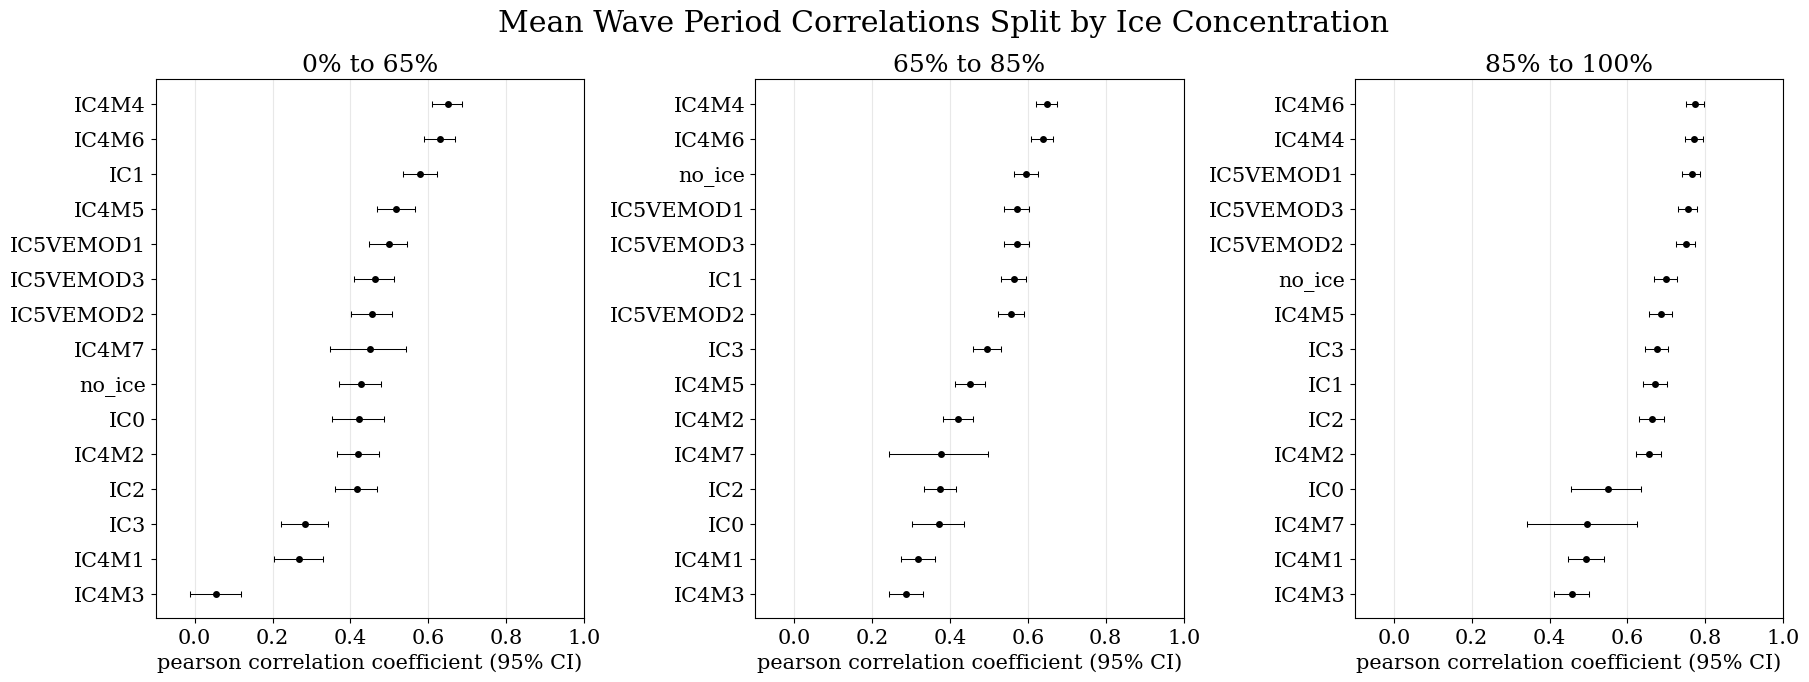

In [36]:
# make a plot of the mwp pearson correlations for different ice concentrations

fig1, ax1 = plt.subplots(1, 3, figsize=(21, 7))
sort = 1
    
for i  in range(len(c41_splits)):
    split = c41_splits[i]
    ax = ax1.flat[i]
    fig1.suptitle('Mean Wave Period Correlations Split by Ice Concentration',size='x-large')
    
    # filter the data for the band in 'split' and find the pearson correlations
    cor_pt, cor_ci = filter_cor_mwp_by_ice(b_pts,m_pts,split)
    
    ci_lower = [0]*len(cor_pt)
    ci_upper = [0]*len(cor_pt)
    
    #change ci from upper and lower values to errors
    for i in range(len(cor_ci)):
        ci_lower[i] = abs(cor_ci[i][0]-cor_pt[i])

    for i in range(len(cor_ci)):
        ci_upper[i] = abs(cor_ci[i][1]-cor_pt[i])
    
    # create a dataframe to store the correlations
    cor_df = pd.DataFrame(
    {'cor': cor_pt,
     'ci_l': ci_lower,
     'ci_u': ci_upper,
     'model': filtered_names
    })
    
    # sort by point estimate - comment out for a consistent order across the catagories
    if sort:
        cor_df = cor_df.sort_values('cor')
    
    # plot the data
    ax.errorbar(cor_df.cor,cor_df.model,xerr=[cor_df.ci_l,cor_df.ci_u],color='black',capsize=2,capthick=0.75,linewidth=0.75,linestyle='none',marker='.')
    ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)
    
    ptitle = str(round(100*split[0]))+'% to '+str(round(100*split[1]))+'%'
    
    ax.set(title=ptitle, xlabel='pearson correlation coefficient (95% CI)',xlim = [-0.1,1])
    
plt.subplots_adjust(wspace=0.4)
plt.show()
# comment out for proper file names
if sort:
    fig1.savefig('pearson_ci_subplot_mwp_by_ice_koz_sorted',dpi=300)
else:
    fig1.savefig('pearson_ci_subplot_mwp_by_koz_ice',dpi=300)

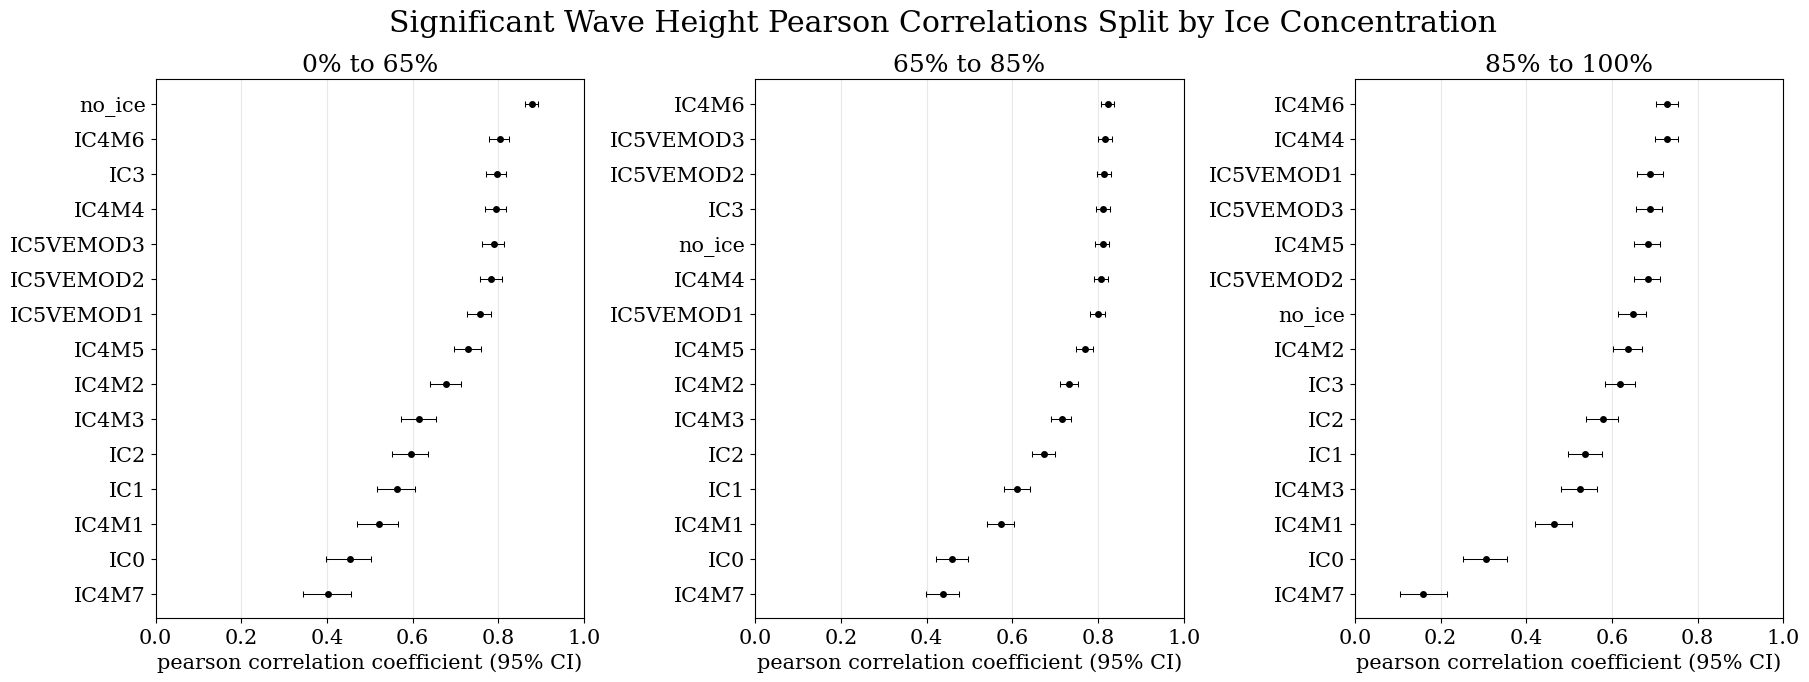

In [37]:
# make a plot of the swh pearson correlations for different ice concentrations

fig1, ax1 = plt.subplots(1, 3, figsize=(21, 7))
sort = 1

for i  in range(len(c41_splits)):
    split = c41_splits[i]
    ax = ax1.flat[i]
    fig1.suptitle('Significant Wave Height Pearson Correlations Split by Ice Concentration',size='x-large')
    
    # filter the data for the band in 'split' and find the pearson correlations
    cor_pt, cor_ci = filter_cor_ice(b_pts,m_pts,split)
    
    ci_lower = [0]*len(cor_pt)
    ci_upper = [0]*len(cor_pt)
    
    #change ci from upper and lower values to errors
    for i in range(len(cor_ci)):
        ci_lower[i] = abs(cor_ci[i][0]-cor_pt[i])

    for i in range(len(cor_ci)):
        ci_upper[i] = abs(cor_ci[i][1]-cor_pt[i])
    
    # create a dataframe to store the correlations
    cor_df = pd.DataFrame(
    {'cor': cor_pt,
     'ci_l': ci_lower,
     'ci_u': ci_upper,
     'model': filtered_names
    })
    
    # sort by point estimate - comment out for a consistent order across the catagories
    if sort:
        cor_df = cor_df.sort_values('cor')
    
    # plot the data
    ax.errorbar(cor_df.cor,cor_df.model,xerr=[cor_df.ci_l,cor_df.ci_u],color='black',capsize=2,capthick=0.75,linewidth=0.75,linestyle='none',marker='.')
    
    ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)
    
    ptitle = str(round(100*split[0]))+'% to '+str(round(100*split[1]))+'%'
    
    ax.set(
            title=ptitle,
            xlabel='pearson correlation coefficient (95% CI)',
            xlim = [0,1]
    )
    
plt.subplots_adjust(wspace=0.4)
plt.show()
# comment out for proper file names
if sort:
    fig1.savefig('pearson_ci_subplot_ice_koz_sorted',dpi=300)
else:
    fig1.savefig('pearson_ci_subplot_ice_koz',dpi=300)

#### Wave period

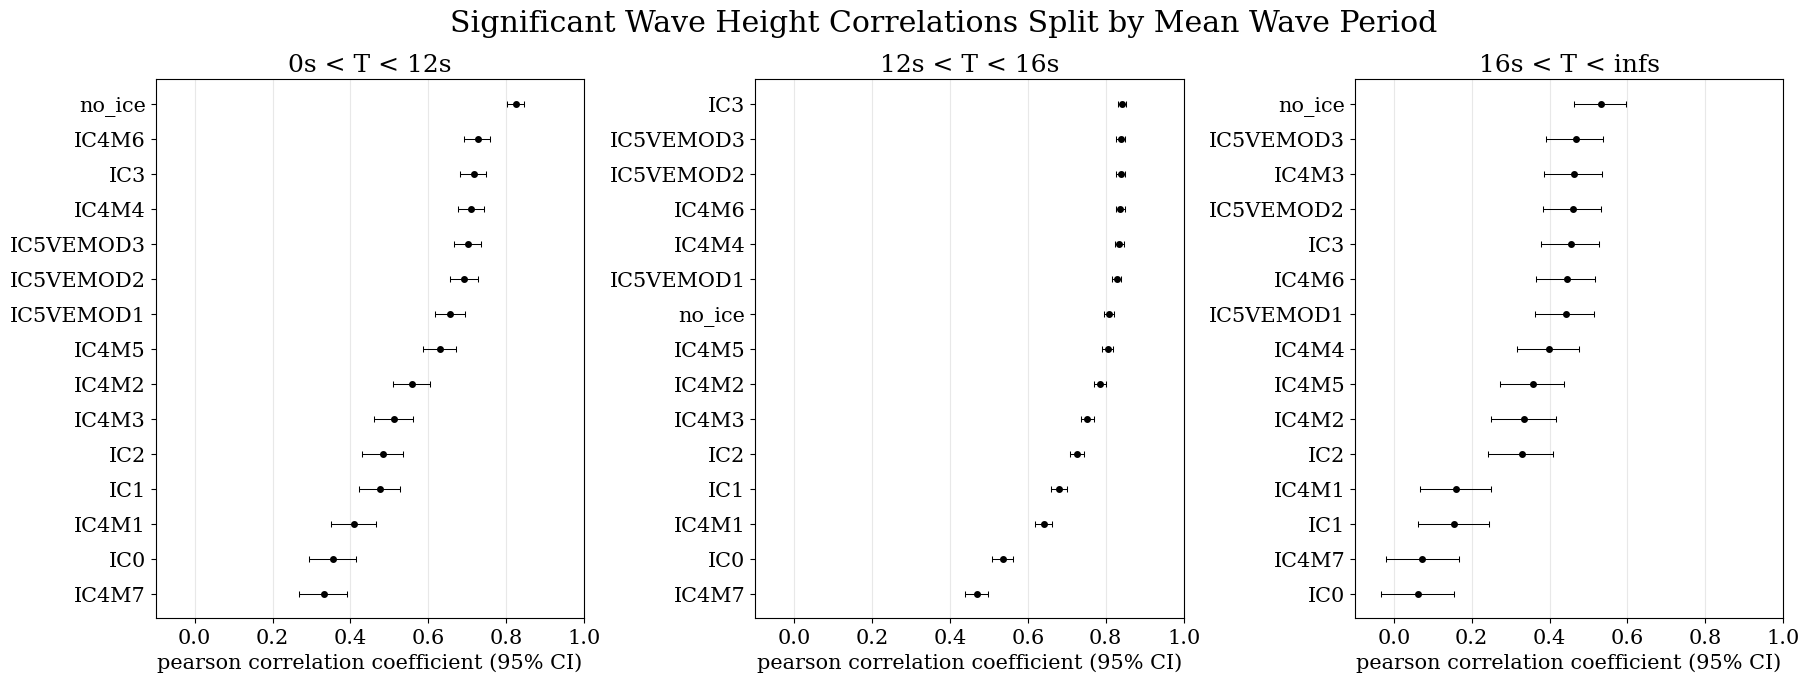

In [38]:
# make a plot of the swh pearson correlations for different mean wave periods

fig1, ax1 = plt.subplots(1, 3, figsize=(21, 7))
sort = 1

for i  in range(len(t41_splits)):
    split = t41_splits[i]
    ax = ax1.flat[i]
    fig1.suptitle('Significant Wave Height Correlations Split by Mean Wave Period',size='x-large')
    
    # filter the data for the band in 'split' and find the pearson correlations
    cor_pt, cor_ci = filter_cor_period(b_pts,m_pts,split)
    
    ci_lower = [0]*len(cor_pt)
    ci_upper = [0]*len(cor_pt)
    
    #change ci from upper and lower values to errors
    for i in range(len(cor_ci)):
        ci_lower[i] = abs(cor_ci[i][0]-cor_pt[i])

    for i in range(len(cor_ci)):
        ci_upper[i] = abs(cor_ci[i][1]-cor_pt[i])
    
    # create a dataframe to store the correlations
    cor_df = pd.DataFrame(
    {'cor': cor_pt,
     'ci_l': ci_lower,
     'ci_u': ci_upper,
     'model': filtered_names
    })
    
    # sort by point estimate - comment out for a consistent order across the catagories
    if sort:
        cor_df = cor_df.sort_values('cor')
    
    # plot the data
    ax.errorbar(cor_df.cor,cor_df.model,xerr=[cor_df.ci_l,cor_df.ci_u],color='black',capsize=2,capthick=0.75,linewidth=0.75,linestyle='none',marker='.')
    ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)
    
    #ptitle = str(round(100*split[0]))+'% to '+str(round(100*split[1]))+'%'
    ptitle = str(split[0]) + "s < T < " + str(split[1]) + "s" 
    
    ax.set(
            title=ptitle,
            xlabel='pearson correlation coefficient (95% CI)',
            xlim = [-0.1,1]
    )
    
plt.subplots_adjust(wspace=0.4)
plt.show()
# comment out for proper file names
if sort:
    fig1.savefig('pearson_ci_subplot_mwp_koz_sorted',dpi=300)
else:
    fig1.savefig('pearson_ci_subplot_mwp_koz',dpi=300)


#### Combined

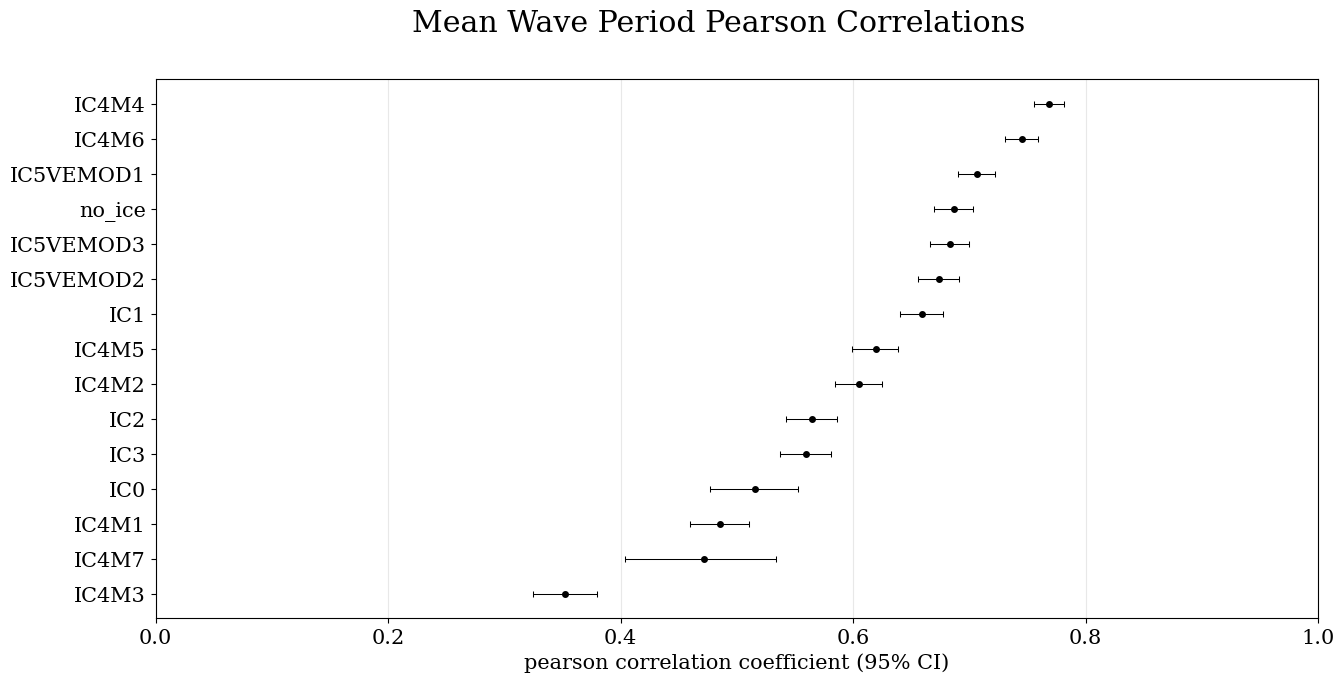

In [39]:
# make a plot of the mwp pearson correlations overall

fig1, ax1 = plt.subplots(1, 1, figsize=(15, 7))
sort = 1

split = (0,1)
ax = ax1
fig1.suptitle('Mean Wave Period Pearson Correlations',size='x-large')

# filter the data for the band in 'split' and find the pearson correlations
cor_pt, cor_ci = filter_cor_mwp_by_ice(b_pts,m_pts,split)

ci_lower = [0]*len(cor_pt)
ci_upper = [0]*len(cor_pt)

#change ci from upper and lower values to errors
for i in range(len(cor_ci)):
    ci_lower[i] = abs(cor_ci[i][0]-cor_pt[i])

for i in range(len(cor_ci)):
    ci_upper[i] = abs(cor_ci[i][1]-cor_pt[i])

# create a dataframe to store the correlations
cor_df = pd.DataFrame(
{'cor': cor_pt,
 'ci_l': ci_lower,
 'ci_u': ci_upper,
 'model': filtered_names
})

# sort by point estimate - comment out for a consistent order across the catagories
if sort:
    cor_df = cor_df.sort_values('cor')

# plot the data
ax.errorbar(cor_df.cor,cor_df.model,xerr=[cor_df.ci_l,cor_df.ci_u],color='black',capsize=2,capthick=0.75,linewidth=0.75,linestyle='none',marker='.')

ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
ax.set(
        xlabel='pearson correlation coefficient (95% CI)',
        xlim = [0,1]
)

plt.subplots_adjust(wspace=0.4)
plt.show()
# comment out for proper file names
if sort:
    fig1.savefig('pearson_ci_subplot_mwp_total_koz_sorted',dpi=300)
else:
    fig1.savefig('pearson_ci_subplot_mwp_total_koz',dpi=300)

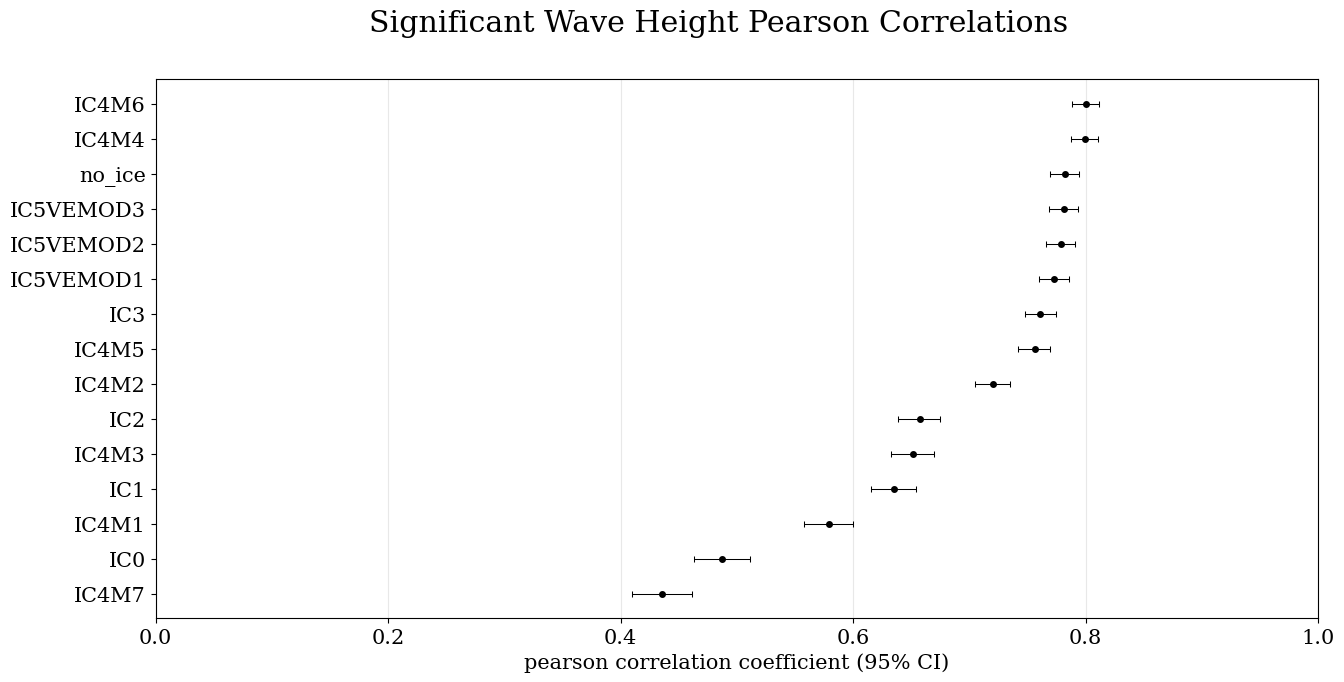

In [40]:
# make a plot of the swh pearson correlations overall

fig1, ax1 = plt.subplots(1, 1, figsize=(15, 7))
sort = 1

split = (0,1)
ax = ax1
fig1.suptitle('Significant Wave Height Pearson Correlations',size='x-large')

# filter the data for the band in 'split' and find the pearson correlations
cor_pt, cor_ci = filter_cor_ice(b_pts,m_pts,split)

ci_lower = [0]*len(cor_pt)
ci_upper = [0]*len(cor_pt)

#change ci from upper and lower values to errors
for i in range(len(cor_ci)):
    ci_lower[i] = abs(cor_ci[i][0]-cor_pt[i])

for i in range(len(cor_ci)):
    ci_upper[i] = abs(cor_ci[i][1]-cor_pt[i])

# create a dataframe to store the correlations
cor_df = pd.DataFrame(
{'cor': cor_pt,
 'ci_l': ci_lower,
 'ci_u': ci_upper,
 'model': filtered_names
})

# sort by point estimate - comment out for a consistent order across the catagories
if sort:
    cor_df = cor_df.sort_values('cor')

# plot the data
ax.errorbar(cor_df.cor,cor_df.model,xerr=[cor_df.ci_l,cor_df.ci_u],color='black',capsize=2,capthick=0.75,linewidth=0.75,linestyle='none',marker='.')

ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
ax.set(
        xlabel='pearson correlation coefficient (95% CI)',
        xlim = [0,1]
)

plt.subplots_adjust(wspace=0.4)
plt.show()
# comment out for proper file names
if sort:
    fig1.savefig('pearson_ci_subplot_total_koz_sorted',dpi=300)
else:
    fig1.savefig('pearson_ci_subplot_total_koz',dpi=300)

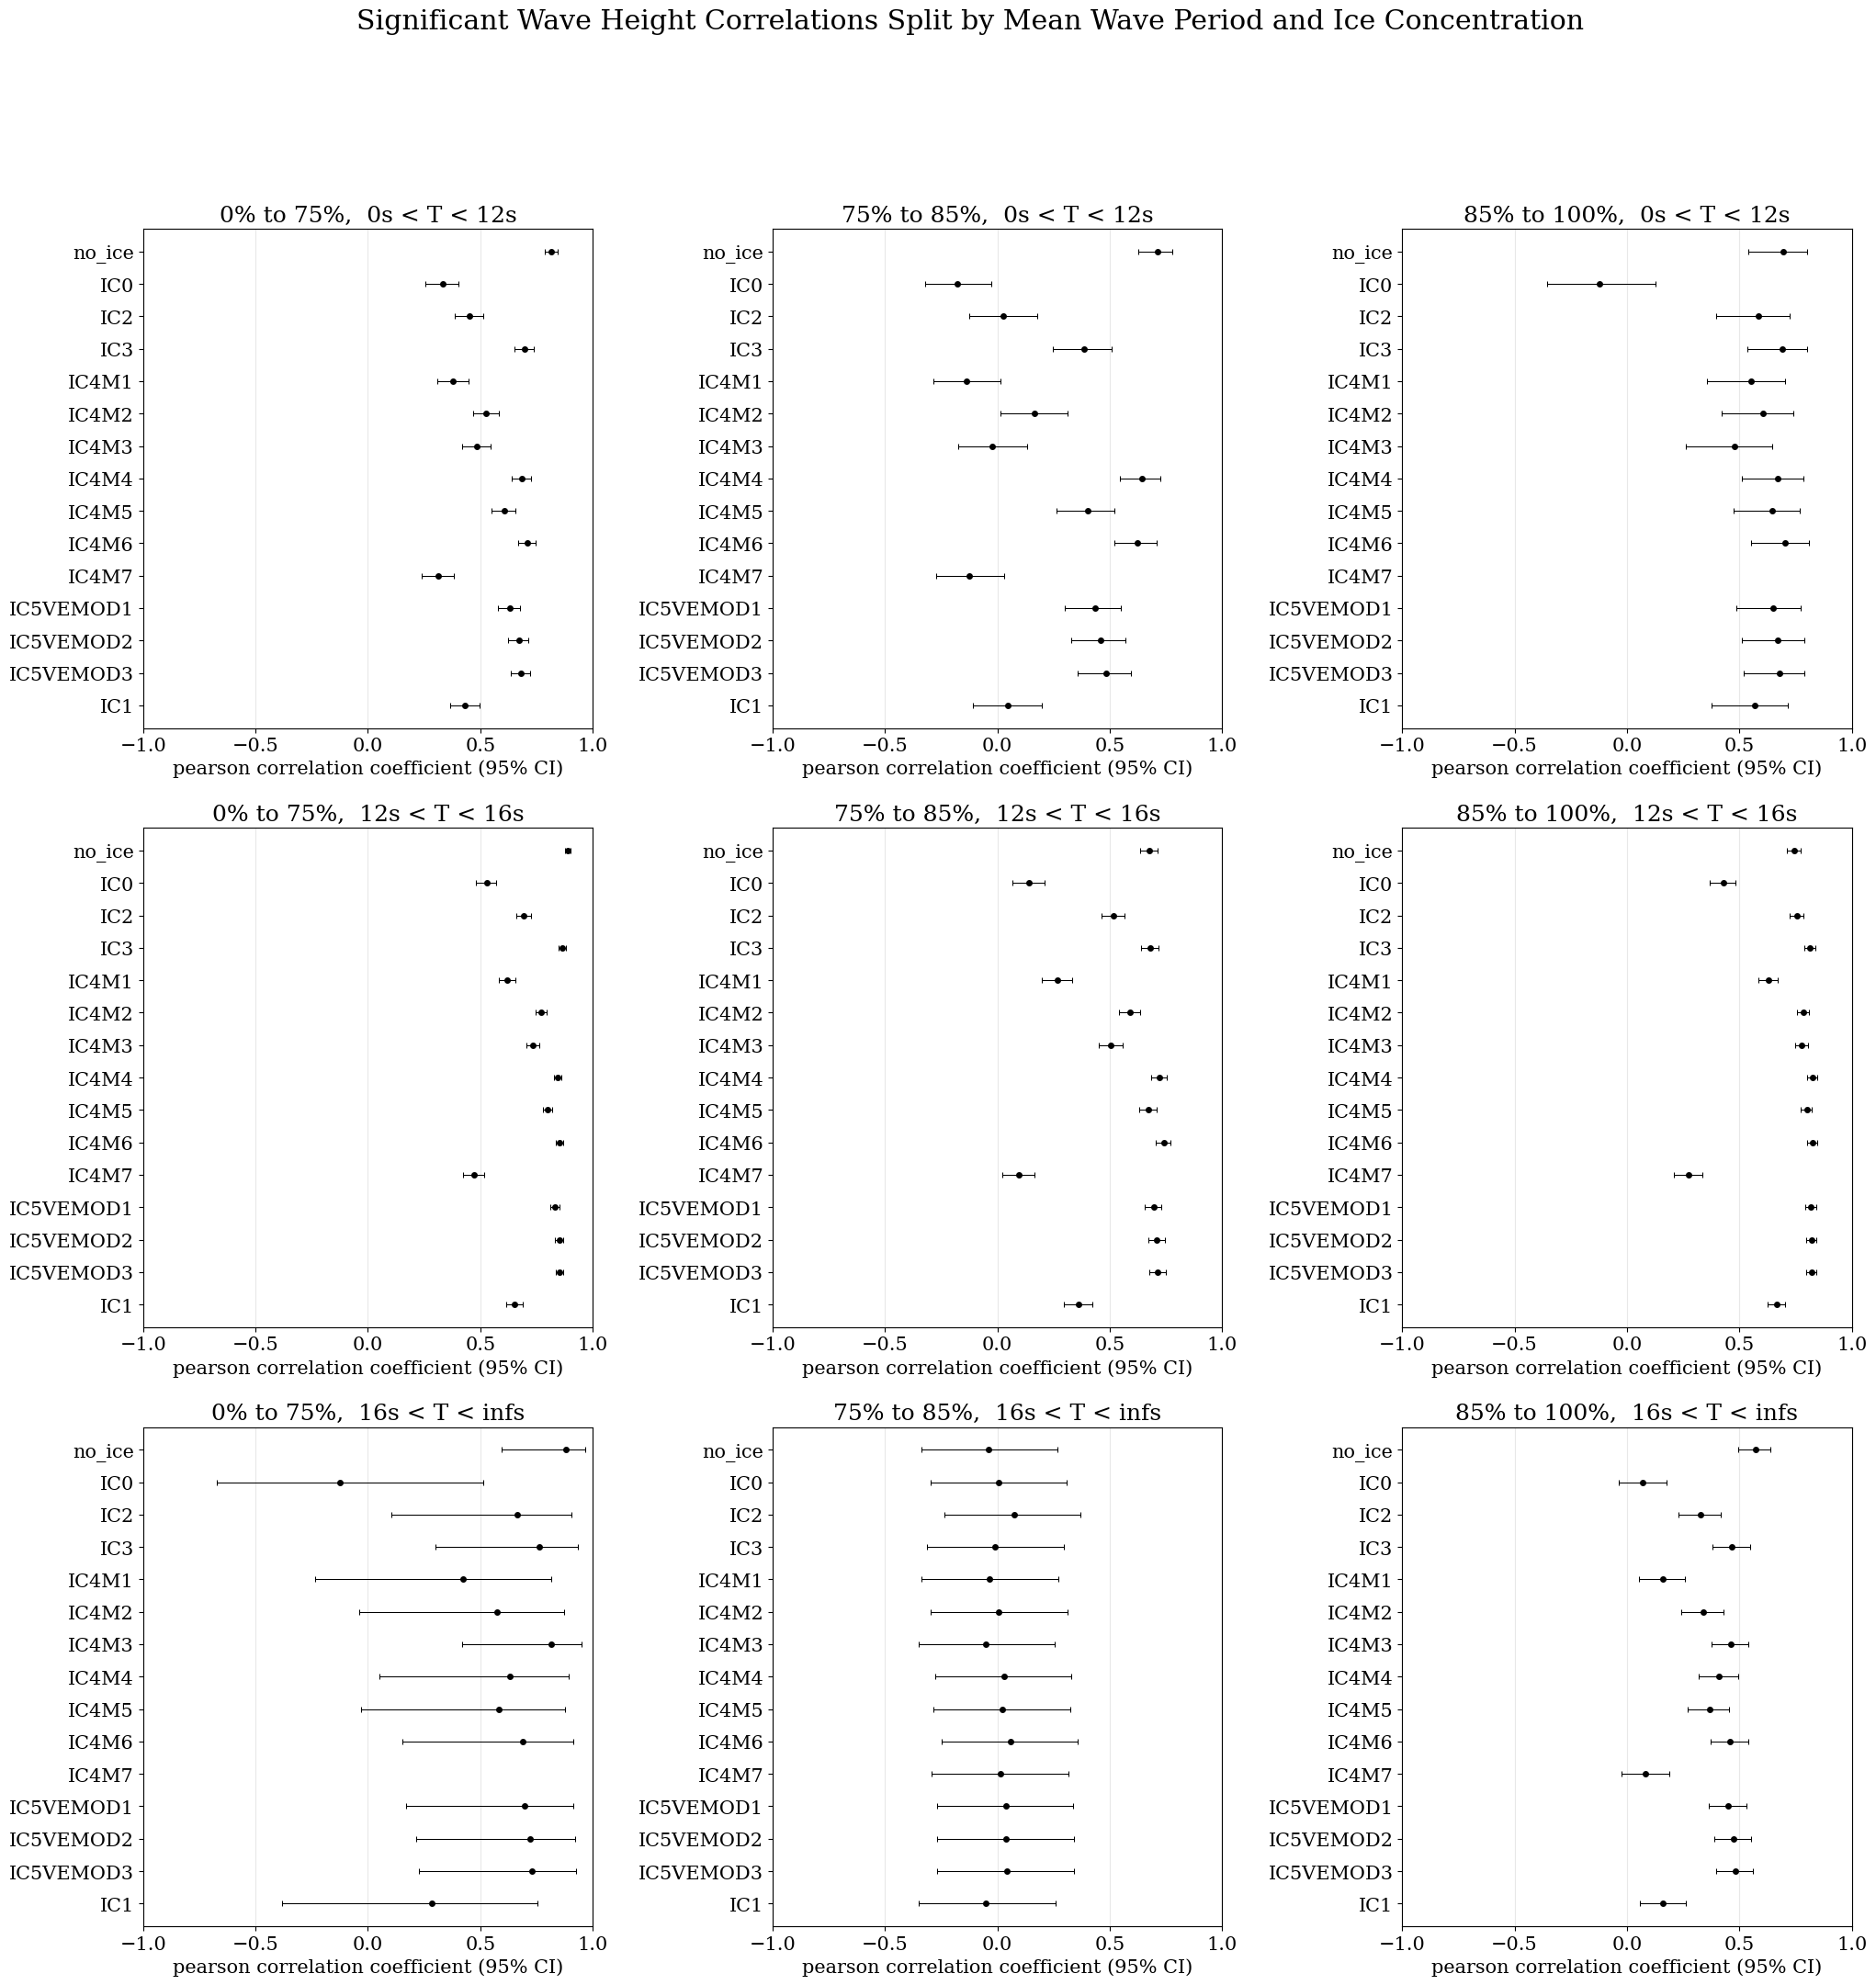

In [34]:
# make a plot of the pearson correlations for different mean wave periods

fig1, ax1 = plt.subplots(3, 3, figsize=(24, 24))
fig1.suptitle('Significant Wave Height Correlations Split by Mean Wave Period and Ice Concentration',size='x-large')
    
for n  in range(len(t3_splits)):
    pr_split = t3_splits[n]
    ax2 = ax1[n]
    for i in range(len(c3_splits)):
        ax = ax2[i]
        ic_split = c3_splits[i]
        
        # filter the data for the band in 'split' and find the pearson correlations
        cor_pt, cor_ci = filter_cor_ice_period(b_pts,m_pts,ic_split,pr_split)
        
        ci_lower = [0]*len(cor_pt)
        ci_upper = [0]*len(cor_pt)

        #change ci from upper and lower values to errors
        for i in range(len(cor_ci)):
            ci_lower[i] = abs(cor_ci[i][0]-cor_pt[i])

        for i in range(len(cor_ci)):
            ci_upper[i] = abs(cor_ci[i][1]-cor_pt[i])

        # create a dataframe to store the correlations
        cor_df = pd.DataFrame(
        {'cor': cor_pt,
         'ci_l': ci_lower,
         'ci_u': ci_upper,
         'model': filtered_names
        })

        # sort by point estimate - comment out for a consistent order across the catagories
        #cor_df = cor_df.sort_values('cor')

        # plot the data
        ax.errorbar(cor_df.cor,cor_df.model,xerr=[cor_df.ci_l,cor_df.ci_u],color='black',capsize=2,capthick=0.75,linewidth=0.75,linestyle='none',marker='.')
        ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)

        ptitle = str(round(100*ic_split[0]))+'% to '+str(round(100*ic_split[1]))+'%,  '+str(pr_split[0]) + "s < T < " + str(pr_split[1]) + "s"

        ax.set(
                title=ptitle,
                xlabel='pearson correlation coefficient (95% CI)',
                xlim = [-1,1]
        )
    
plt.subplots_adjust(wspace=0.4)
plt.show()
# comment out for proper file names
fig1.savefig('pearson_ci_subplot_mwp_ice',dpi=300)
#fig1.savefig('pearson_ci_subplot_mwp_ice_sorted',dpi=300)